In [1]:
from commons import *
from libruntimepredictionanalysis import *
import logging
#import warnings;
#warnings.filterwarnings('error');

In [2]:
FILENAME_LEARNINGCURVES = "data/workdata/learningcurves.csv"
FILENAME_PREDICTIONS_DEFAULT = "data/workdata/newpredictions-default.csv"
FILENAME_PREDICTIONS_PARAMETRIZED = "data/workdata/newpredictions-parametried.csv"
FILENAME_PREDICTIONS_POSTERIOR = "data/workdata/newpredictions-posterior.csv"

In [3]:
# read in data
dfComplete = pd.read_csv("data/runtimes/runtimes_atomic.csv")
dfErrored = dfComplete[dfComplete["error"].notna()]
df = dfComplete[dfComplete["fittime"] >= 0].copy()
df["fittime"] /= 1000 # talk about seconds here
df["applicationtimeperkinstances"] /= 1000 # talk about seconds here
df["af1"] = df["fitsize"] * df["fitattributes"]
df["af2"] = df["fitsize"] * df["fitattributes"] ** 2

for f in ["fitsize", "fitattributes", "af1", "af2"]:
    missingIndices = df[f].isna()
    missing = np.count_nonzero(missingIndices)
    if missing > 0:
        raise Exception("There are " + str(missing) + " input entries that do not have a value for \"" + f + "\".\n\n" + str(df[missingIndices]))

/home/felix/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
%%time
G_array = getEvaluationGridPoints()
G = [list(gp) for gp in G_array]
compatibleFitAttributes = {}
compatibleFitSizes = {}
for fitsize in set([gp[0] for gp in G]):
    compatibleFitAttributes[fitsize] = [gp[1] for gp in G if gp[0] == fitsize]
for fitattributes in set([gp[1] for gp in G]):
    compatibleFitSizes[fitattributes] = [gp[0] for gp in G if gp[1] == fitattributes]
dfGrid = df[df.apply(lambda row: row["fitattributes"] in compatibleFitAttributes[row["fitsize"]] , axis=1)]

CPU times: user 38.7 s, sys: 1.92 s, total: 40.6 s
Wall time: 42.7 s


In [5]:
validationCombos = [[5000, 100], [10000, 100], [20000, 100], [50000, 100], [100000, 100], [15000, 1000], [20000, 1000], [30000, 1000], [50000, 1000]]

In [6]:
dfDefault = df[df["algorithmoptions"].isnull()]
dfConfigured = df[df["algorithmoptions"].notnull()]

In [7]:
datasets = sorted(pd.unique(df["openmlid"]))
D_fitsize = sorted(pd.unique(df["fitsize"]))
D_fitattributes = sorted(pd.unique(df["fitsize"]))
G_fitsizes = np.unique(G_array[:,0])
G_fitattributes = np.unique(G_array[:,1])

# 0. Data Completeness Checks

In [8]:
def getOpenMLIdsForGrid(observationsPerGridPoint, seed = None):
    rows = {}
    rrIndex = 0
    shuffledDatasets = datasets.copy()
    r = random.Random(seed)
    r.shuffle(shuffledDatasets)
    for i, fitsize in enumerate(G_fitsizes):
        for j, fitattributes in enumerate(G_fitattributes):
            if [fitsize, fitattributes] in G:
                openmlids = []
                isValidationPoint = [fitsize, fitattributes] in validationCombos

                for k in range(observationsPerGridPoint):
                    openmlid = shuffledDatasets[rrIndex]
                    openmlids.append(openmlid)
                    rrIndex += 1
                    if rrIndex == len(shuffledDatasets): # when the datasets are exhausted, re-shuffle them in a way, that the first elements are not contained in the openmlids already considered for this grid point
                        while True:
                            r.shuffle(shuffledDatasets)
                            prefix = shuffledDatasets[:observationsPerGridPoint - k]
                            if len([x for x in openmlids if x in prefix]) == 0:
                                break
                        rrIndex = 0
                rows[(fitsize, fitattributes)] = openmlids
    return rows


# connects each row in the dataframe with parametrizations
def getPosteriorJoin(dfParametrized, dfDefault = None):
    if np.count_nonzero(dfParametrized["algorithmoptions"].isna()) > 0:
        raise Exception("dataframe contains entries for non-parametrized runs.")
    if dfDefault is None:
        dfDefault = dfGrid[dfGrid["algorithmoptions"].isna()]
    return dfParametrized.merge(dfDefault, on=["algorithm", "openmlid", "fitsize", "fitattributes", "seed"], suffixes=(None,"_default"))

In [9]:
# this draws 10 potentially different samples using latin hypercube sampling
def getAlgorithmOptionListForGrid(algorithm, fitsize, fitattributes, n, salt, attempts=10):
    hc = (fitsize + 13) * fitattributes + salt
    out = None
    i = 0
    size = 0
    while out is None or (len(set(out)) < n and i < attempts):
        candidate = getRandomAlgorithmOptions(algorithm, n, seed=hc + i)
        if len(set(candidate)) > size:
            size = len(set(candidate))
            out = candidate
        i+=1
    return out

def getObservationStatusFrame(algorithm, observationsPerGridPoint, numObservationsPerValidationPoint = 10):
    
    rows = []
    
    if observationsPerGridPoint > 20:
        raise Exception("Only up to 20 points are supported for the grid. Otherwise we cannot guarantee that the grid points will be identical.")
    
    # we generate the grid as if it *was* for 20 points and then cut below. This is important for later augments, so that the grid will be a superset of the former one
    requiredOpenMLIdsInConfiguredGrid = getOpenMLIdsForGrid(20, seed=0)
    
    dfAlgo = dfGrid[(dfGrid["algorithm"] == algorithm)]
    dfAlgoErrored = dfErrored[(dfErrored["algorithm"] == algorithm)]

    # count numbers of observation per coordinate
    for i, fitsize in enumerate(G_fitsizes):
        dfFitsize = dfAlgo[dfAlgo["fitsize"] == fitsize]
        for j, fitattributes in enumerate(G_fitattributes):
            dfFitattributes = dfFitsize[dfFitsize["fitattributes"] == fitattributes]
            if (fitsize + 1500) * fitattributes <= 3 * 10**8:
                isValidationPoint = [fitsize, fitattributes] in validationCombos
                if isValidationPoint:
                    requiredDatasets = requiredDatasetsForGlobalTraining = coredatasets + [d for d in datasets if not d in coredatasets]
                else:
                    requiredDatasetsForGlobalTraining = requiredOpenMLIdsInConfiguredGrid[(fitsize, fitattributes)]
                    requiredDatasets = coredatasets + [d for d in requiredDatasetsForGlobalTraining if not d in coredatasets]
                
                # search for the 10 parametrized observations
                errorIndex1 = (dfAlgoErrored["fitsize"] == fitsize) & (dfAlgoErrored["fitattributes"] == fitattributes)
                for seed in range(numObservationsPerValidationPoint if isValidationPoint else 1):
                    requiredParametrizations = getAlgorithmOptionListForGrid(algorithm, fitsize, fitattributes, len(requiredDatasets), seed) if algorithm in parametrizablealgorithms else [None for __ in range(len(requiredDatasets))]
                    consideredPointsForGlobalTraining = 0
                    for k, params in enumerate(requiredParametrizations):

                        if (not isValidationPoint) and (consideredPointsForGlobalTraining >= observationsPerGridPoint and k >= len(coredatasets)): # stop here if we have enough
                            break
                                
                        openmlid = requiredDatasets[k]
                        if openmlid in requiredDatasetsForGlobalTraining:
                            consideredPointsForGlobalTraining += 1
                        
                        enabledForGlobalTraining = openmlid in requiredDatasetsForGlobalTraining
                        matchesDataset = dfFitattributes["openmlid"] == openmlid
                        matchesParams = None if params is None else dfFitattributes["algorithmoptions"] == params
                        #if fitsize == 20000 and fitattributes == 1000 and params == "-K 8 -E -X":
                            #for row in dfFitattributes[dfFitattributes["algorithmoptions"].notna()]["algorithmoptions"].values:
                             #   print("'" + row + "'", row == params, "openmlid:", openmlid)

                        # check that the parametrized observation is there
                        errorIndex2 = None
                        if not params is None:
                            numberRequirementsFound = np.count_nonzero(matchesDataset & matchesParams)
                            if numberRequirementsFound > 0:
                                status = "ok"
                            else:
                                errorIndex2 = errorIndex1 & (dfAlgoErrored["openmlid"] == openmlid) & (dfAlgoErrored["seed"] == seed)                                    
                                #print(openmlid, seed, fitsize, fitattributes, params, np.count_nonzero(errorIndex2), np.count_nonzero(errorIndex2 & (dfAlgoErrored["algorithmoptions"] == params)))
                                if np.count_nonzero(errorIndex2 & (dfAlgoErrored["algorithmoptions"] == params)) > 0:
                                    status = "failed"
                                else:
                                    status = "missing"
                            rows.append([algorithm, fitsize, fitattributes, isValidationPoint, enabledForGlobalTraining, openmlid, params, seed, status])

                        # check that the observation for default configurations is there
                        numberRequirementsFound = np.count_nonzero(matchesDataset & dfFitattributes["algorithmoptions"].isna())
                        if numberRequirementsFound > 0:
                            status = "ok"
                        else:
                            if errorIndex2 is None:
                                errorIndex2 = errorIndex1 & (dfAlgoErrored["openmlid"] == openmlid) & (dfAlgoErrored["seed"] == seed)
                            if np.count_nonzero(errorIndex2 & (dfAlgoErrored["algorithmoptions"].isna())) > 0:
                                status = "failed"
                            else:
                                status = "missing"
                        rows.append([algorithm, fitsize, fitattributes, isValidationPoint, enabledForGlobalTraining, openmlid, np.nan, seed, status])
                            

    # produce output frame and conduct same sanity checks
    dfOut = pd.DataFrame(rows, columns=["algorithm", "fitsize", "fitattributes", "validation", "forglobalmodel", "openmlid", "algorithmoptions", "seed", "status"])
    
    for dfTest in [dfOut[dfOut["algorithmoptions"].isna()], dfOut[dfOut["algorithmoptions"].notna()]] if algorithm in parametrizablealgorithms else [dfOut[dfOut["algorithmoptions"].isna()]]:
    
        # is there exactly one observation for each core dataset on each point in the grid (10 for validation points)?
        for index, group in dfTest[dfTest["openmlid"].isin(coredatasets)].groupby(["fitsize", "fitattributes"]):
            seenGroup = sorted(group["openmlid"].values)
            isValidationPoint = [index[0], index[1]] in validationCombos
            expectedGroup = sorted([openmlid for i in range(numObservationsPerValidationPoint if isValidationPoint else 1) for openmlid in coredatasets])
            if seenGroup != expectedGroup:
                print("Expected to see entries for openmlids " + str(expectedGroup) + " on grid point " + str(index) + " but only observed", seenGroup)

        # check 1: is there a grid point used for the global model with a number of observations different from 10?
        for index, group in dfTest[(dfTest["forglobalmodel"]) & (~dfTest["validation"])].groupby(["fitsize", "fitattributes"]):
            if len(group) != observationsPerGridPoint:
                print("Grid point for non-validation point " + str(index) + " has too few entries. Expected " + str(observationsPerGridPoint) + " but saw", len(group))

        # check 2: are there exactly 10490 for core datasets and 1049 * observationsPerGridPoint = (1058 - 9) * observationsPerGridPoint instances marked as training (not validation) for global training?
        numPointsForCoreTraining = np.count_nonzero((dfTest["openmlid"].isin(coredatasets)) & (~dfTest["validation"]))
        if numPointsForCoreTraining != 10490:
            print("Expected to see " + str(10490) + " entries for non-validation points having a core dataset but observed", numPointsForCoreTraining)
        numPointsForGlobalTraining = np.count_nonzero((dfTest["forglobalmodel"]) & (~dfTest["validation"]))
        if numPointsForGlobalTraining != 1049 * observationsPerGridPoint:
            print("Expected to see " + str(1049 * observationsPerGridPoint) + " entries for non-validation points marked as \"forglobalmodel\" but observed", numPointsForGlobalTraining)

        # check 3: are there exactly 90 * numObservationsPerValidationPoint resp. 15660 = 174 * 9 * numObservationsPerValidationPoint instances marked as validation for local/global training?
        numPointsForLocalValidation = np.count_nonzero((dfTest["openmlid"].isin(coredatasets)) & (dfTest["validation"]))
        if numPointsForLocalValidation != (90 * numObservationsPerValidationPoint):
            print("Expected to see " + str(90 * numObservationsPerValidationPoint) + " entries for validation with entries for a core dataset but observed", numPointsForLocalValidation)
        numPointsForGlobalValidation = np.count_nonzero((dfTest["forglobalmodel"]) & (dfTest["validation"]))
        if numPointsForGlobalValidation != 1566 * numObservationsPerValidationPoint:
            print("Expected to see " + str(1566 * numObservationsPerValidationPoint) + " entries for validation points marked as \"forglobalmodel\" but observed", numPointsForGlobalValidation)
    
    
    return dfOut

In [10]:
GRID_DENSITY = 10
STATUS_TABLES = {}
STATUS_TABLE_COMPLETE = None
for algorithm in tqdm(algorithms):
    STATUS_TABLES[algorithm] = getObservationStatusFrame(algorithm, GRID_DENSITY, numObservationsPerValidationPoint=GRID_DENSITY)
    STATUS_TABLE_COMPLETE = STATUS_TABLES[algorithm] if STATUS_TABLE_COMPLETE is None else pd.concat([STATUS_TABLE_COMPLETE, STATUS_TABLES[algorithm]], axis=0, ignore_index=True)

In [11]:
from matplotlib.gridspec import GridSpec
def getMissingDataMatrices(dfStatus):
    
    requiredOpenMLIdsInConfiguredGrid = getOpenMLIdsForGrid(20, seed=0)
    rows = []
    dfDefault = dfStatus[(dfStatus["algorithmoptions"].isna())]
    dfParametrized = dfStatus[(dfStatus["algorithmoptions"].notna())]
    
    # count numbers of observation per coordinate
    MDefault = np.zeros((len(G_fitsizes), len(G_fitattributes)))
    MParametrized = np.zeros((len(G_fitsizes), len(G_fitattributes)))
    for i, fitsize in enumerate(G_fitsizes):
        for j, fitattributes in enumerate(G_fitattributes):
            isValidationPoint = [fitsize, fitattributes] in validationCombos
            if (fitsize + 1500) * fitattributes < 3 * 10**8:
                if isValidationPoint:
                    requiredDatasets = requiredDatasetsForGlobalTraining = coredatasets + [d for d in datasets if not d in coredatasets]
                else:
                    requiredDatasetsForGlobalTraining = requiredOpenMLIdsInConfiguredGrid[(fitsize, fitattributes)]
                    requiredDatasets = coredatasets + [d for d in requiredDatasetsForGlobalTraining if not d in coredatasets]
                    
                matchesDefault = (dfDefault["openmlid"].isin(requiredDatasets + coredatasets)) & (dfDefault["fitsize"] == fitsize) & (dfDefault["fitattributes"] == fitattributes)
                matchesParametrized = (dfParametrized["openmlid"].isin(requiredDatasets)) & (dfParametrized["fitsize"] == fitsize) & (dfParametrized["fitattributes"] == fitattributes)
                MDefault[i,j] = np.count_nonzero(matchesDefault & (dfDefault["status"] == "missing"))
                MParametrized[i,j] = np.count_nonzero(matchesParametrized & (dfParametrized["status"] == "missing"))
            else:
                MDefault[i,j] = np.nan
                MParametrized[i,j] = np.nan
    return MDefault, MParametrized

def getErrorMatrices(dfErrored):
    
    requiredOpenMLIdsInConfiguredGrid = getOpenMLIdsForGrid(20, seed=0)
    out = []
    
    dfDefault = dfErrored[(dfErrored["algorithmoptions"].isna())]
    dfParametrized = dfErrored[(dfErrored["algorithmoptions"].notna())]
    
    for df in [dfDefault, dfParametrized]:
    
        # count numbers of observation per coordinate
        MTimeout = np.zeros((len(G_fitsizes), len(G_fitattributes)))
        MMemory = np.zeros((len(G_fitsizes), len(G_fitattributes)))
        MSMOTE = np.zeros((len(G_fitsizes), len(G_fitattributes)))
        MOther = np.zeros((len(G_fitsizes), len(G_fitattributes)))

        for i, fitsize in enumerate(G_fitsizes):
            for j, fitattributes in enumerate(G_fitattributes):
                isValidationPoint = [fitsize, fitattributes] in validationCombos
                if (fitsize + 1500) * fitattributes < 3 * 10**8:
                    if isValidationPoint:
                        requiredDatasets = requiredDatasetsForGlobalTraining = coredatasets + [d for d in datasets if not d in coredatasets]
                    else:
                        requiredDatasetsForGlobalTraining = requiredOpenMLIdsInConfiguredGrid[(fitsize, fitattributes)]
                        requiredDatasets = coredatasets + [d for d in requiredDatasetsForGlobalTraining if not d in coredatasets]

                    matches = (df["openmlid"].isin(requiredDatasets + coredatasets)) & (df["fitsize"] == fitsize) & (df["fitattributes"] == fitattributes)
                    MTimeout[i,j] = np.count_nonzero(matches & (df["error"] == "timeout"))
                    MMemory[i,j] = np.count_nonzero(matches & (df["error"] == "memory"))
                    MSMOTE[i,j] = np.count_nonzero(matches & (df["error"] == "smote"))
                    MOther[i,j] = np.count_nonzero(matches & (df["error"] == "other"))
                else:
                    MTimeout[i,j] = MMemory[i,j] = MSMOTE[i,j] = MOther[i,j] = np.nan
        out.append((MTimeout, MMemory, MSMOTE, MOther))
    return tuple(out)

def getDatasetCoverage(dfStatus, dsFilter):

    dfDefault = dfStatus[(dfStatus["algorithmoptions"].isna())]
    dfParametrized = dfStatus[(dfStatus["algorithmoptions"].notna())]
    
    # count numbers of observations per dataset
    MDatasetsDefault = np.zeros(len(dsFilter))
    MDatasetsParametrized = np.zeros(len(dsFilter))
    for i, ds in enumerate(dsFilter):
        MDatasetsDefault[i] = len(dfDefault.query("status == 'ok' and openmlid == " + str(ds)))
        MDatasetsParametrized[i] = len(dfParametrized.query("status == 'ok' and openmlid == " + str(ds)))
    
    return MDatasetsDefault, MDatasetsParametrized
        
def plotDataAvailability(dfStatusMap, dfErrored):
    for algorithm in algorithms:
        
        # computing status table
        print(algorithm.upper() + ": Computing matrices.")
        dfStatus = dfStatusMap[algorithm]
        dfDefault = dfStatus[(dfStatus["algorithmoptions"].isna())]
        dfParametrized = dfStatus[(dfStatus["algorithmoptions"].notna())]
        MDefault, MParametrized = getMissingDataMatrices(dfStatus)
        errorMatricesDefault, errorMatricesParametrized = getErrorMatrices(dfErrored[dfErrored["algorithm"] == algorithm])
        print("Done.", len(dfDefault), "observations for default and", len(dfParametrized), "observations for parametrized runs (within grid). " + str(np.round(100 * np.count_nonzero(dfStatus["status"] == "ok") / len(dfStatus), 2)) + "% completed.")
        
        # create plots of missing data
        fig = plt.figure(figsize=(20,6))
        spec = GridSpec(2, 7)
        print(spec[0,0])
        
        imAxises = np.empty((2, 5), dtype=object)
        for j in range(5):
            if j == 0:
                imAxises[0][j] = fig.add_subplot(spec[0, j])
                imAxises[1][j] = fig.add_subplot(spec[1, j])
            else:
                imAxises[0][j] = fig.add_subplot(spec[0, j], sharex=imAxises[1][j], sharey=imAxises[0][0])
                imAxises[1][j] = fig.add_subplot(spec[1, j], sharey=imAxises[1][0])
        
        for i, (MMissing, errorMatrices) in enumerate([(MDefault, errorMatricesDefault), (MParametrized, errorMatricesParametrized)]):

            ax = imAxises[i]
            
            # image maps
            ax[0].set_title("Missing Values")
            ax[0].imshow(MMissing, vmin=0, vmax=10, cmap="Purples")
            
            ax[1].set_title("Timeouts")
            ax[1].imshow(errorMatrices[0], vmin=0, vmax=10, cmap="Reds")
            
            ax[2].set_title("Memory Fails")
            ax[2].imshow(errorMatrices[1], vmin=0, vmax=10, cmap="Reds")
            
            ax[3].set_title("SMOTE Fails")
            ax[3].imshow(errorMatrices[2], vmin=0, vmax=10, cmap="Reds")
            
            ax[4].set_title("Other Fails")
            ax[4].imshow(errorMatrices[3], vmin=0, vmax=10, cmap="Reds")
            
            # put tick labels on image maps
            for u in range(0, 5):
                if i == 1:
                    ax[u].set_xticks([j for j, s in enumerate(G_fitattributes) if j % 2 == 0])
                    ax[u].set_xticklabels([s for j, s in enumerate(G_fitattributes) if j % 2 == 0], rotation=90)
                    ax[u].set_xlabel("Number of attributes")
                    ax[u].get_shared_x_axes().join(imAxises[0][u], imAxises[1][u])
                else:
                    ax[u].get_shared_x_axes().join(imAxises[0][u], imAxises[1][u])
                    ax[u].set_xticklabels([])
            ax[0].set_yticks([j for j, s in enumerate(G_fitsizes) if j % 2 == 0])
            ax[0].set_yticklabels([s for j, s in enumerate(G_fitsizes) if j % 2 == 0])
            ax[0].set_ylabel("Number of instances")
            for u in range(1, 5):
                ax[u].get_shared_y_axes().join(imAxises[i][0], imAxises[i][u])
                ax[u].set_yticklabels([])

                
        # get dataset coverage
        barAxises = np.empty((2, 2), dtype=object)
        barAxises[0][0] = fig.add_subplot(spec[0, 5])
        barAxises[1][0] = fig.add_subplot(spec[1, 5])
        barAxises[0][1] = fig.add_subplot(spec[0, 6])
        barAxises[1][1] = fig.add_subplot(spec[1, 6])
        
        for k, dsFilter in enumerate([coredatasets, [ds for ds in datasets if not ds in coredatasets]]):
            MDatasetsDefault, MDatasetsParametrized = getDatasetCoverage(dfStatus, dsFilter)
            barAxises[0][k].set_title("Prevalence of " + ("core ds" if k == 0 else "non-core ds") + " Default")
            barAxises[0][k].bar(range(len(dsFilter)), MDatasetsDefault)
            barAxises[0][k].axhline((1049 + GRID_DENSITY * 9) if k == 0 else (1049 + GRID_DENSITY * 9) / (174 * GRID_DENSITY)) # each core dataset should be there (at least) 1049 + 10 * 9 times, and every else roughly 65 = 1139 / 174 * 10 times
            barAxises[1][k].set_title("Prevalence of " + ("core ds" if k == 0 else "non-core ds") + " Parametrized")
            barAxises[1][k].bar(range(len(dsFilter)), MDatasetsParametrized)
            barAxises[1][k].axhline((1049 + GRID_DENSITY * 9) if k == 0 else (1049 + GRID_DENSITY * 9) / (174 * GRID_DENSITY))
        
        spec.update(wspace=0.1, hspace=0.1)
        fig.tight_layout()
        plt.show()

def getSelectQueryConditionsForMissingPoints(algorithm, dfStatusMap, parametrized=False):
    dfStatus = dfStatusMap[algorithm]
    filter1 = dfStatus["status"] == "missing"
    filter2 = (dfStatus["algorithmoptions"].notna()) if parametrized else dfStatus["algorithmoptions"].isna()
    dfMissing = dfStatus[filter1 & filter2]
    
    # default queries
    queriesConditions = []
    for i, row in dfMissing.iterrows():
        condition = "openmlid = " + str(row["openmlid"]) + " and datapoints = " + str(row["fitsize"]) + " and attributes = " + str(row["fitattributes"]) + " and seed = " + str(row["seed"])
        if parametrized:
            condition += " and algorithmoptions = \"" + row["algorithmoptions"] + "\""
        queriesConditions.append(condition)
    return queriesConditions

def getSelectQueryForAlternativeConditions(algorithm, conditions, parametrized=False):
    tablename = "evaluations_classifiers_" + algorithm
    if parametrized:
        tablename += "_configured"
    return "SELECT * FROM " + tablename + " WHERE (" + " OR ".join(["(" + c + ")" for c in conditions]) + ")"

def getSelectQueryForMissingEntries(algorithm, dfStatusMap, parametrized=False, selector=None):
    conditions = getSelectQueryConditionsForMissingPoints(algorithm, dfStatusMap, parametrized)
    if not selector is None:
        conditions = conditions[selector]
    return getSelectQueryForAlternativeConditions(algorithm, conditions, parametrized)
        
def writeInsertQueriesForMissingPoints(dfStatusMap):
    
    for algorithm in dfStatusMap:#algorithms:
        
        print(algorithm.upper())
        
        dfStatus = dfStatusMap[algorithm]
        dfMissing = dfStatus[dfStatus["status"] == "missing"]
        
        # default queries
        queriesDefault = []
        dfMissingDefault = dfMissing[dfMissing["algorithmoptions"].isna()]
        for i, row in dfMissingDefault.iterrows():
            queriesDefault.append("(" + str(row["openmlid"]) + ", " + str(row["fitsize"]) + ", " + str(row["fitattributes"]) + ", " + str(row["seed"]) + ", 1, 16000)")
        f = open("expqueries/" + algorithm + "_default.sql", "w")
        prefix = "classifiers" if algorithm in classifiers else "pp"
        f.write("INSERT INTO `evaluations_" + prefix + "_" + algorithm + "` (openmlid, datapoints, attributes, seed, cpus, memory_max) VALUES " + ",\n".join(queriesDefault))
        f.close()
            
        # configured queries
        dfMissingConfigured = dfMissing[dfMissing["algorithmoptions"].notna()]
        queriesConfigured = []
        for i, row in dfMissingConfigured.iterrows():
            queriesConfigured.append("(" + str(row["openmlid"]) + ", " + str(row["fitsize"]) + ", " + str(row["fitattributes"]) + ", \"" + row["algorithmoptions"] + "\", "+ str(row["seed"]) + ", 1, 16000)")    
        f = open("expqueries/" + algorithm + "_parametrized.sql", "w")
        f.write("INSERT INTO `evaluations_" + prefix + "_" + algorithm + "_configured` (openmlid, datapoints, attributes, algorithmoptions, seed, cpus, memory_max) VALUES " + ",\n".join(queriesConfigured))
        f.close()
        
        
        print("Generated " + str(len(queriesDefault)) + " queries for default experiments, and " + str(len(queriesConfigured)) + " for parametrized. Total number of status entries: " + str(len(dfStatus)))

BAYESNET: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 62.79% completed.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


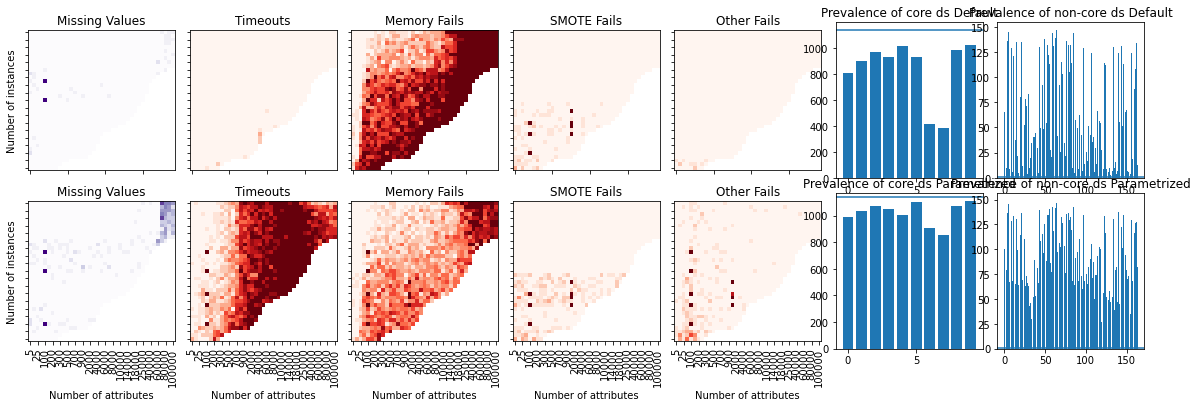

DECISIONSTUMP: Computing matrices.
Done. 35428 observations for default and 0 observations for parametrized runs (within grid). 96.23% completed.


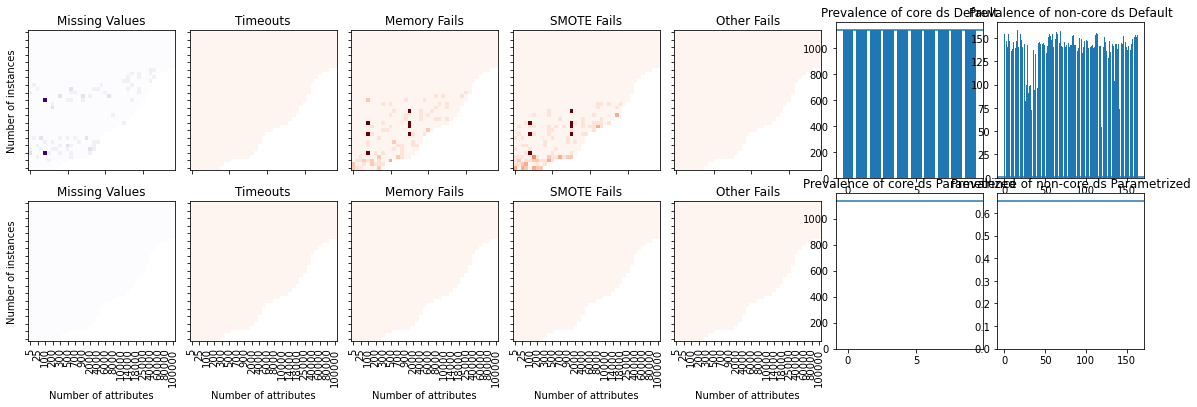

DECISIONTABLE: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.88% completed.


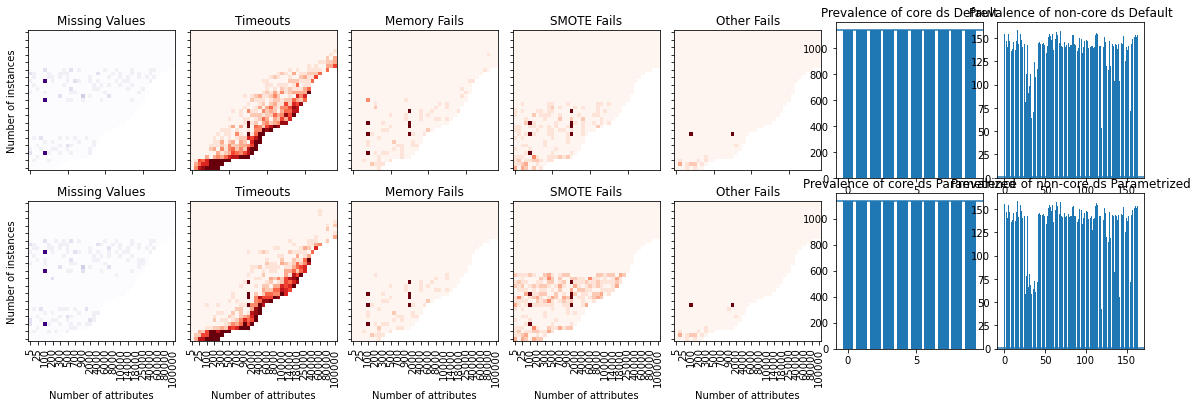

IBK: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.43% completed.


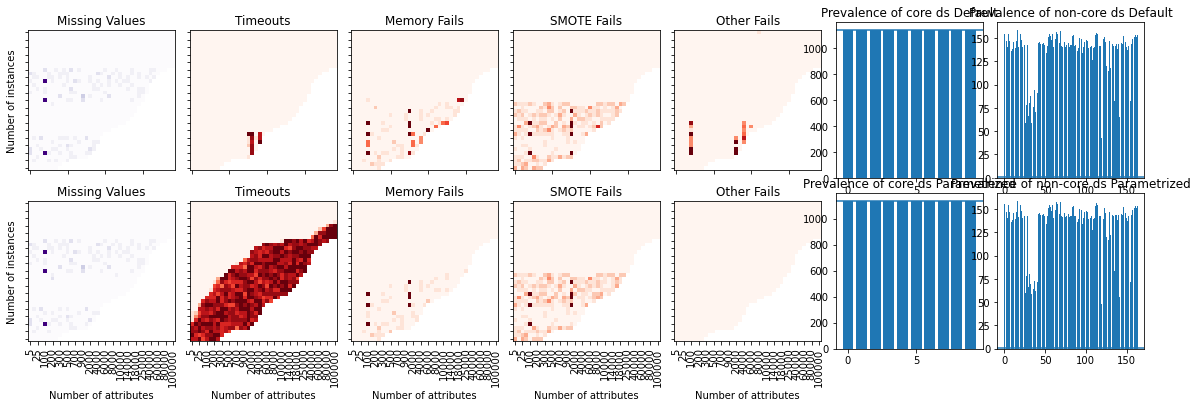

J48: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.16% completed.


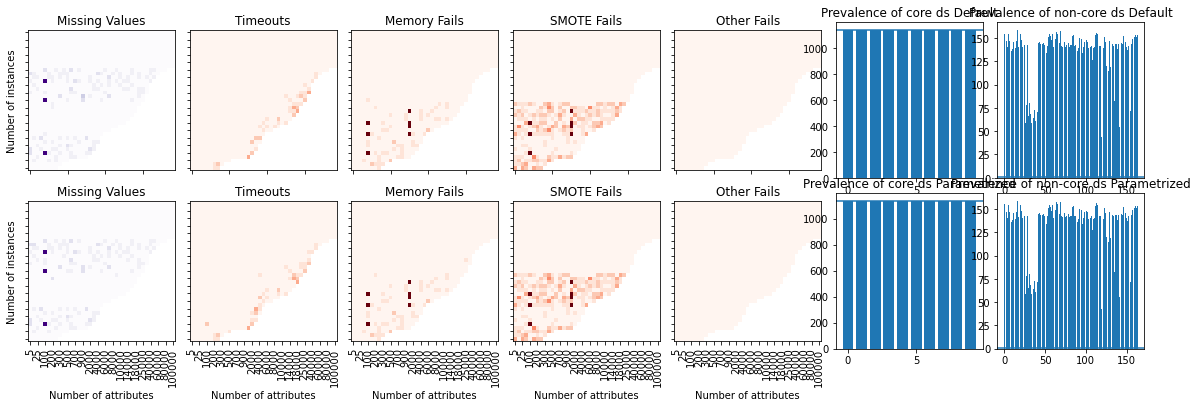

JRIP: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.17% completed.


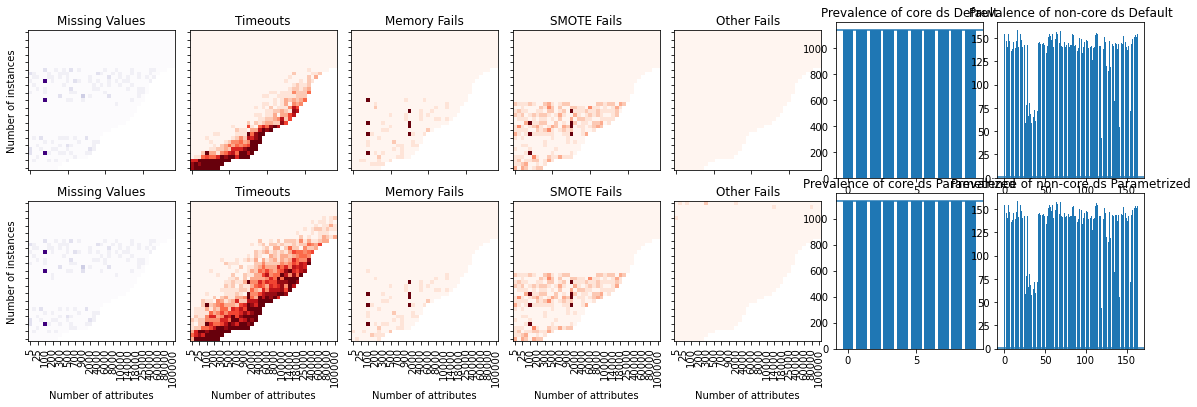

KSTAR: Computing matrices.
Done. 35428 observations for default and 0 observations for parametrized runs (within grid). 93.9% completed.


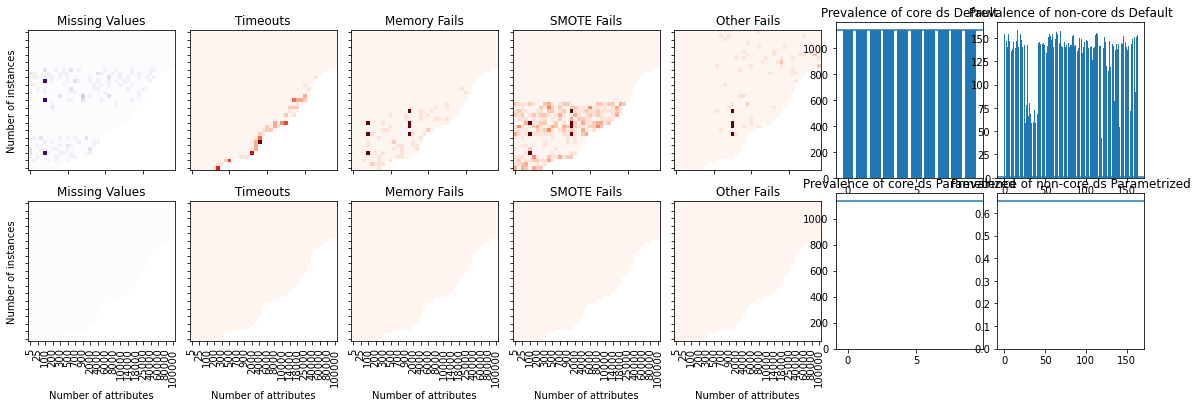

LMT: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 86.26% completed.


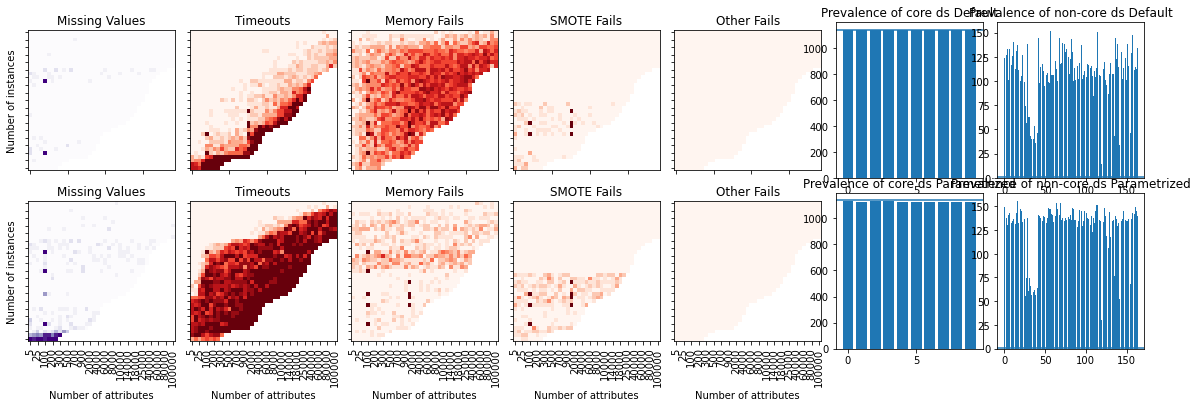

LOGISTIC: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 88.54% completed.


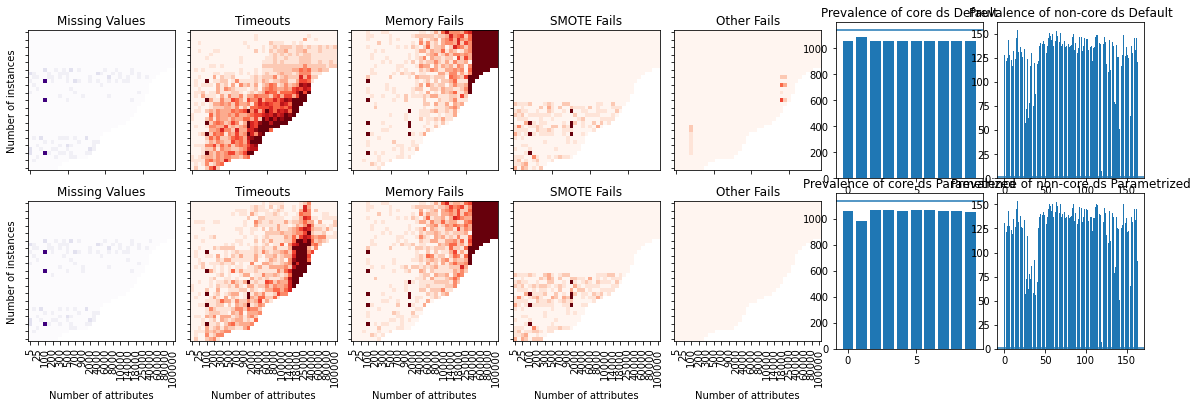

MULTILAYERPERCEPTRON: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 96.12% completed.


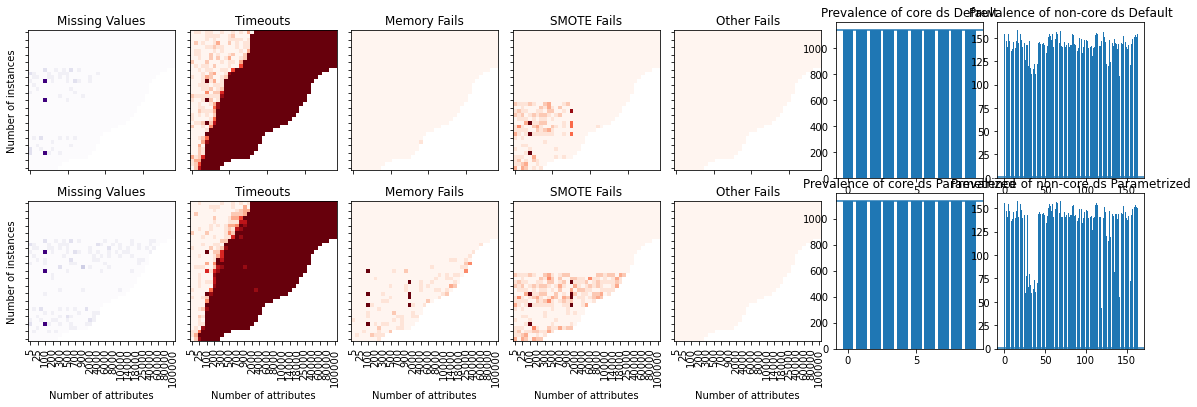

NAIVEBAYES: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 78.16% completed.


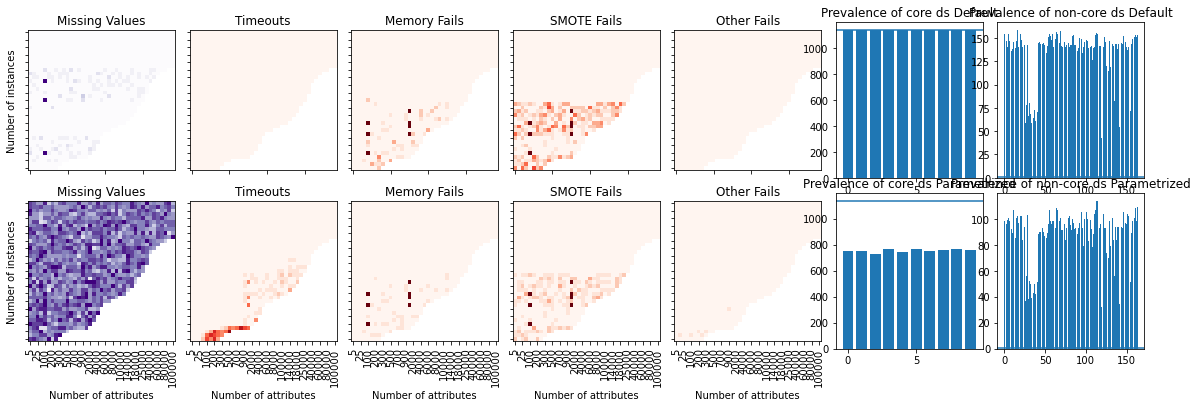

NAIVEBAYESMULTINOMIAL: Computing matrices.
Done. 35428 observations for default and 0 observations for parametrized runs (within grid). 32.21% completed.


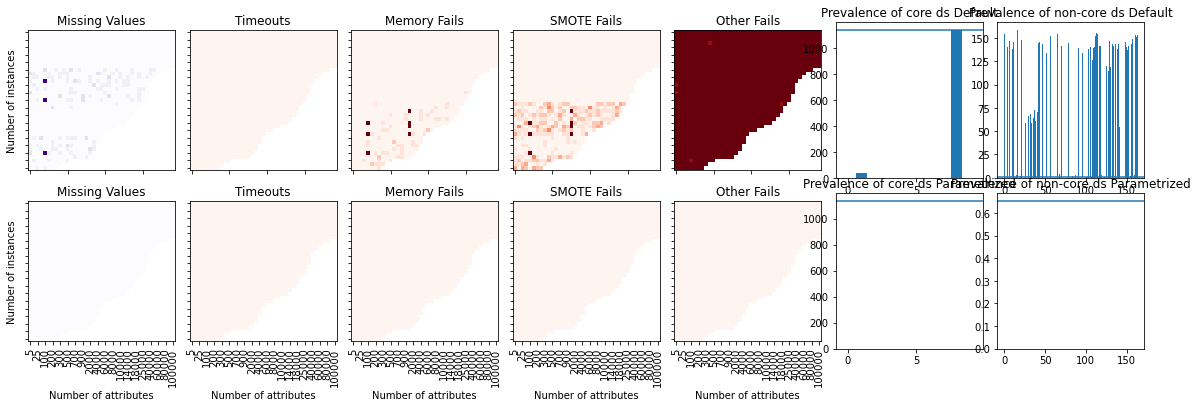

ONER: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.16% completed.


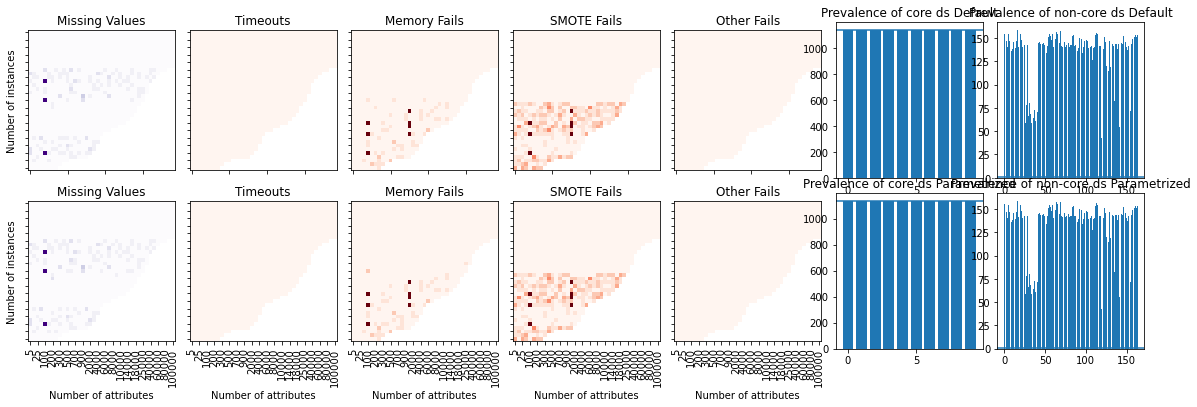

PART: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 92.03% completed.


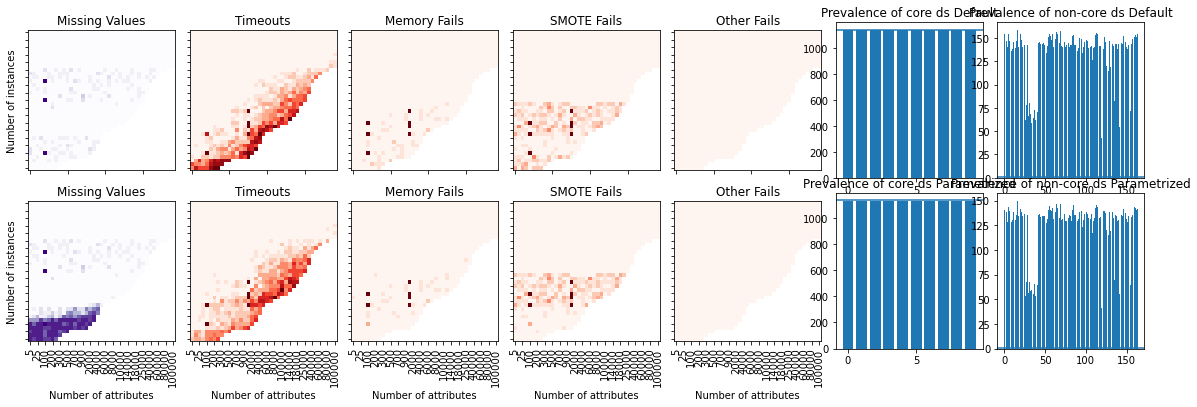

REPTREE: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 83.36% completed.


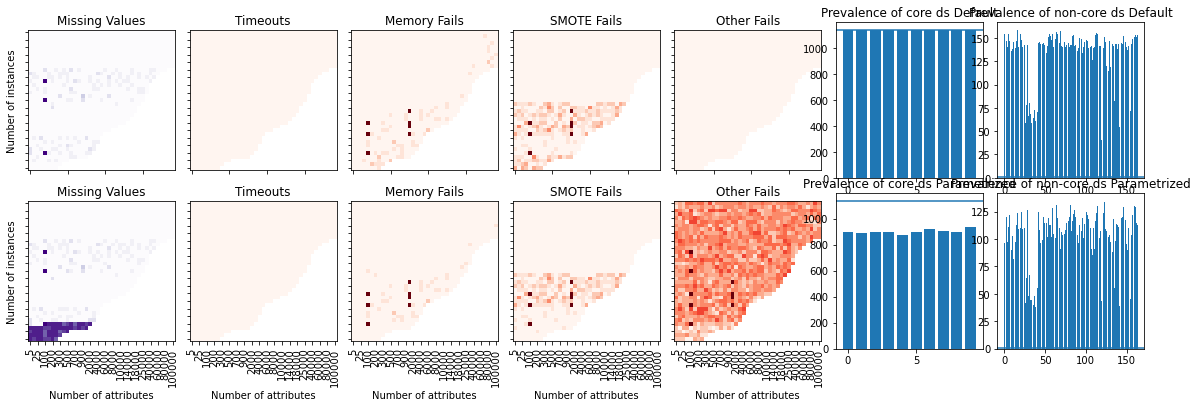

RANDOMFOREST: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.18% completed.


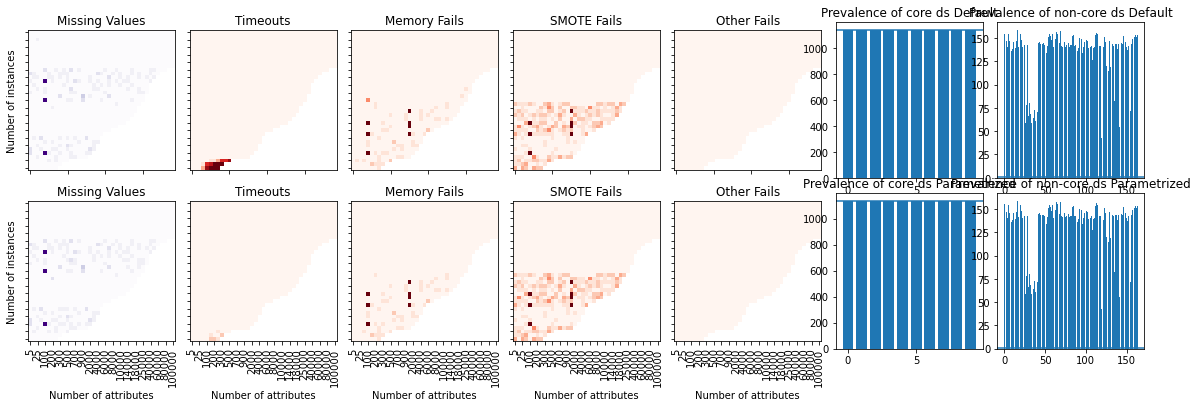

RANDOMTREE: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.16% completed.


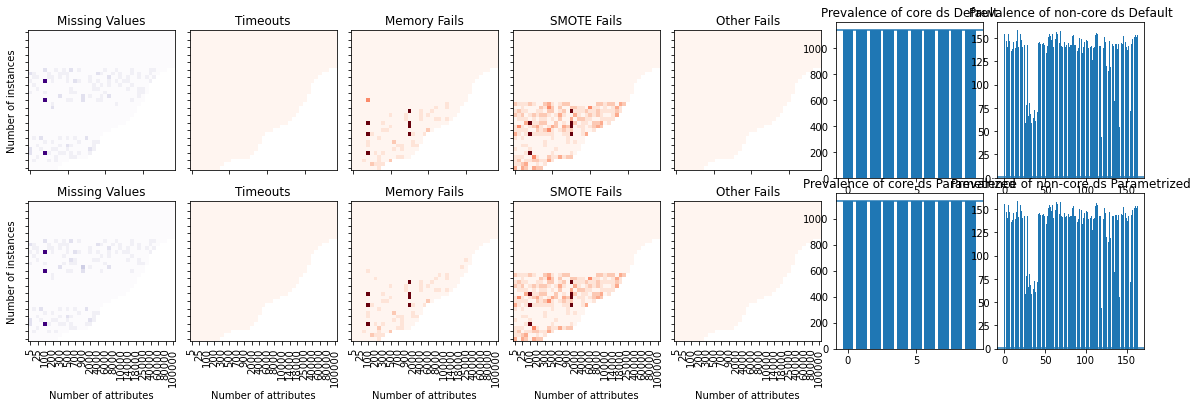

SIMPLELOGISTIC: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.21% completed.


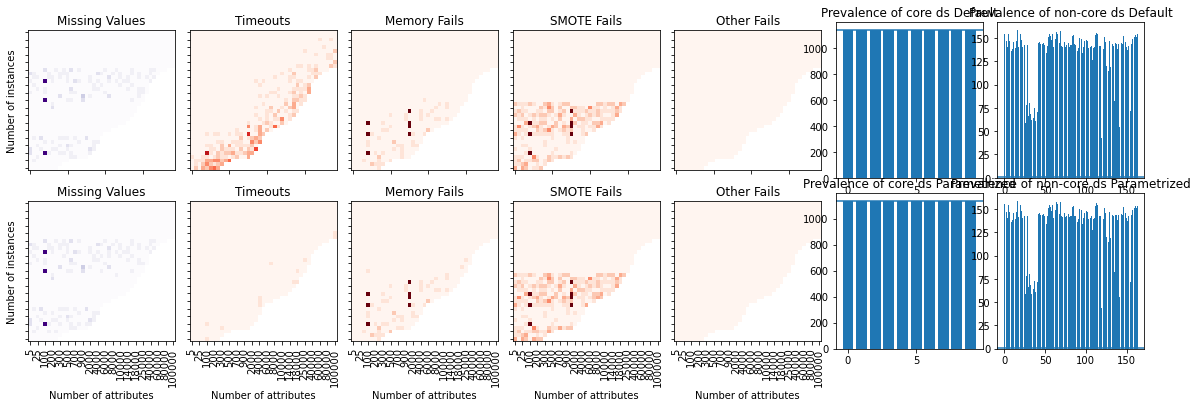

SMO: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 94.28% completed.


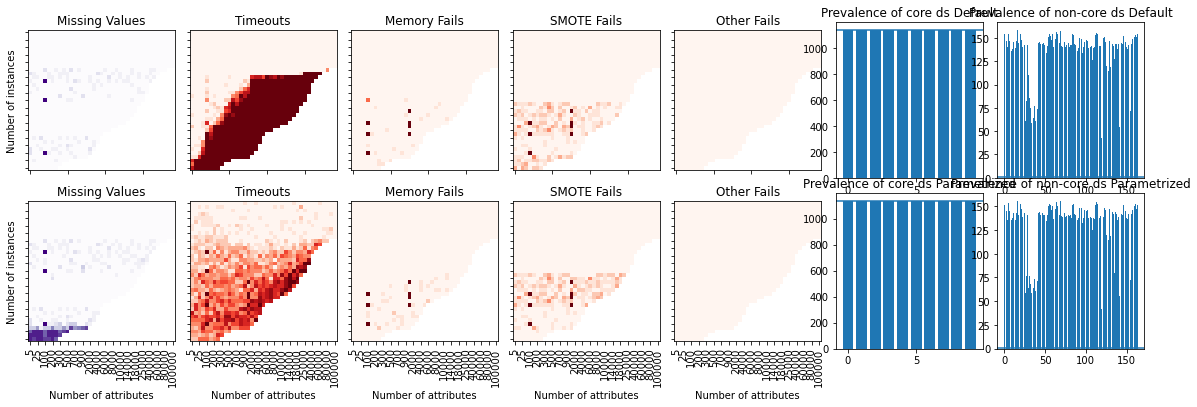

VOTEDPERCEPTRON: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 72.24% completed.


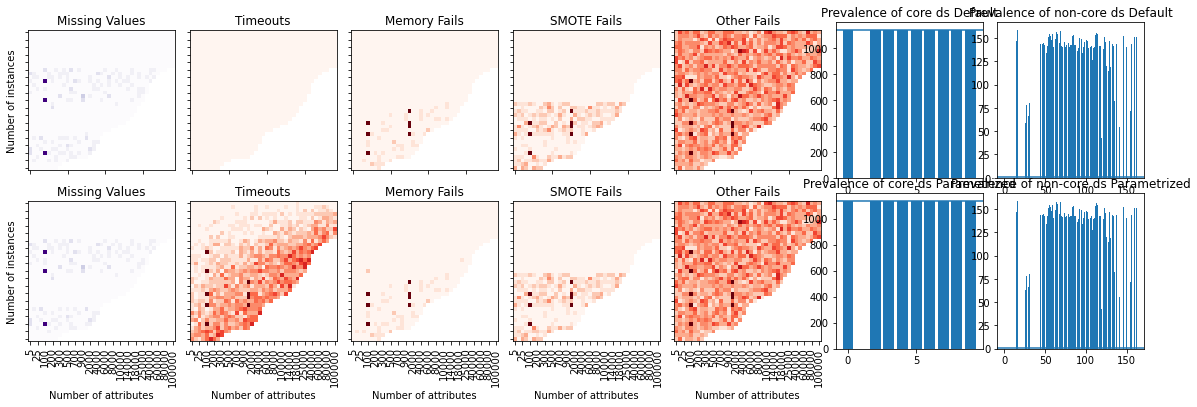

ZEROR: Computing matrices.
Done. 35428 observations for default and 0 observations for parametrized runs (within grid). 94.2% completed.


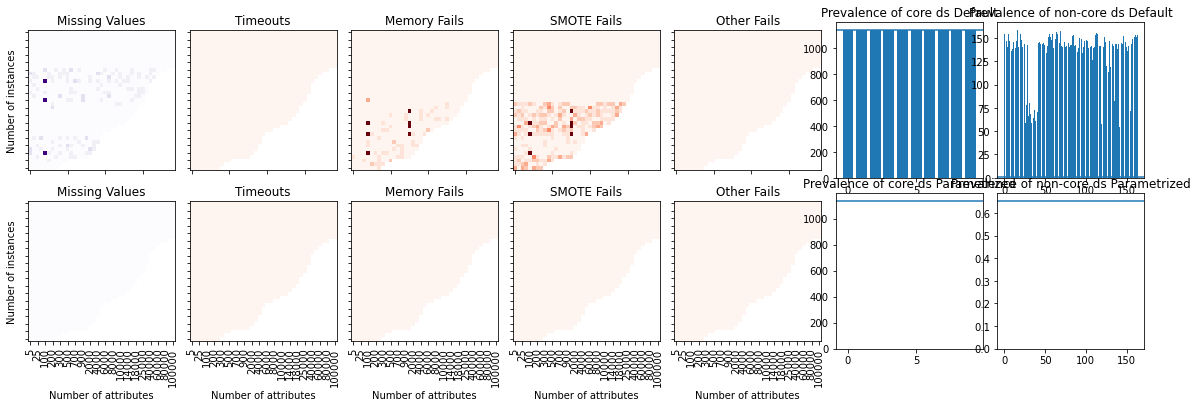

BESTFIRST_CFSSUBSETEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 36.26% completed.


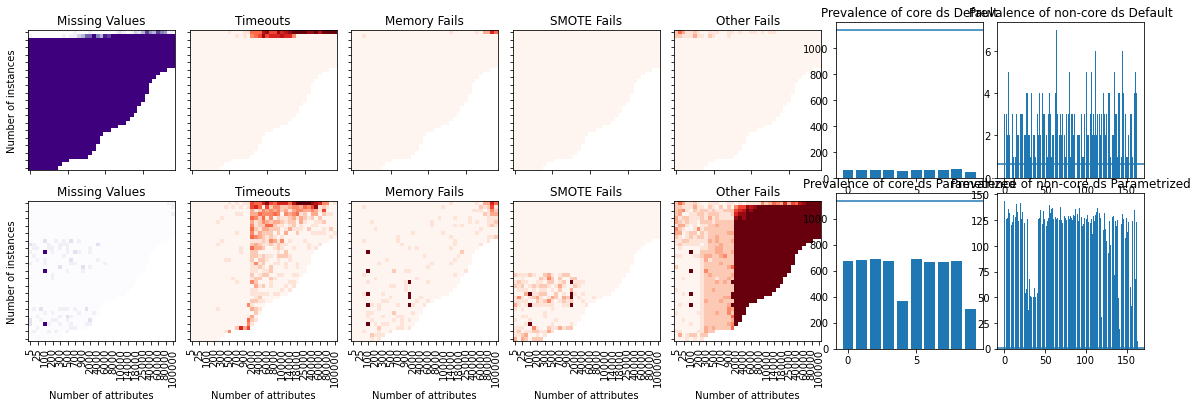

GREEDYSTEPWISE_CFSSUBSETEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 58.21% completed.


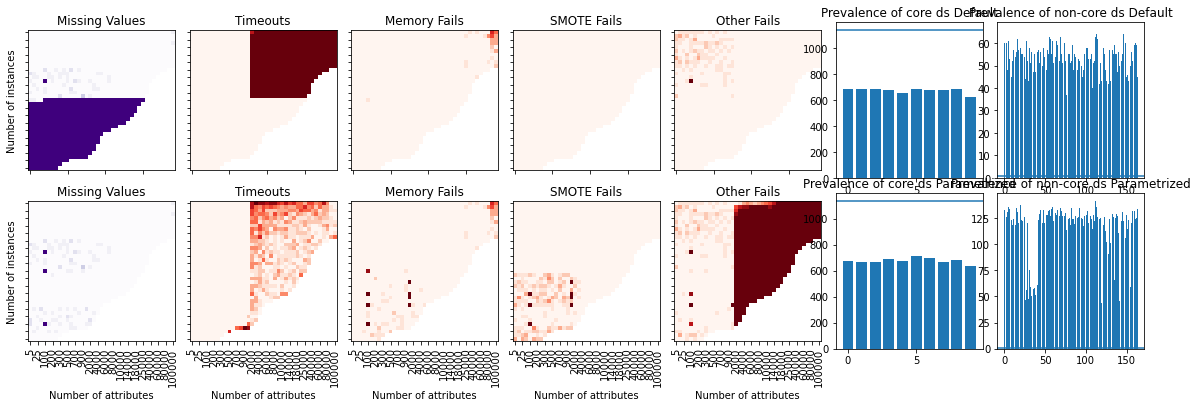

RANKER_CORRELATIONATTRIBUTEEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 47.07% completed.


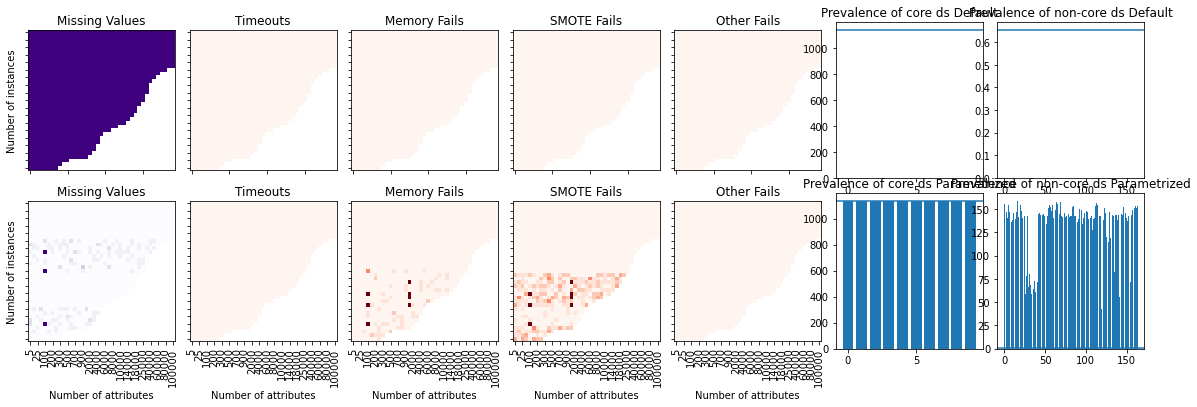

RANKER_GAINRATIOATTRIBUTEEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 74.51% completed.


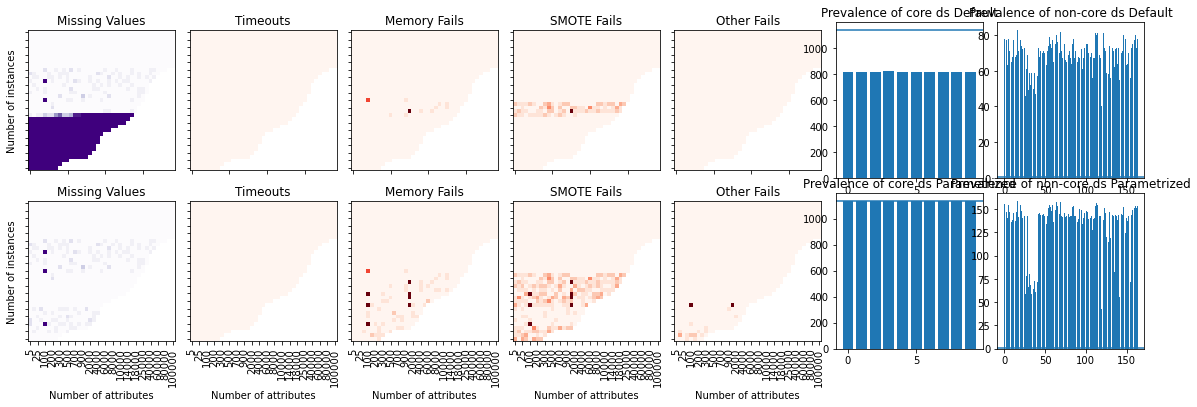

RANKER_INFOGAINATTRIBUTEEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 69.23% completed.


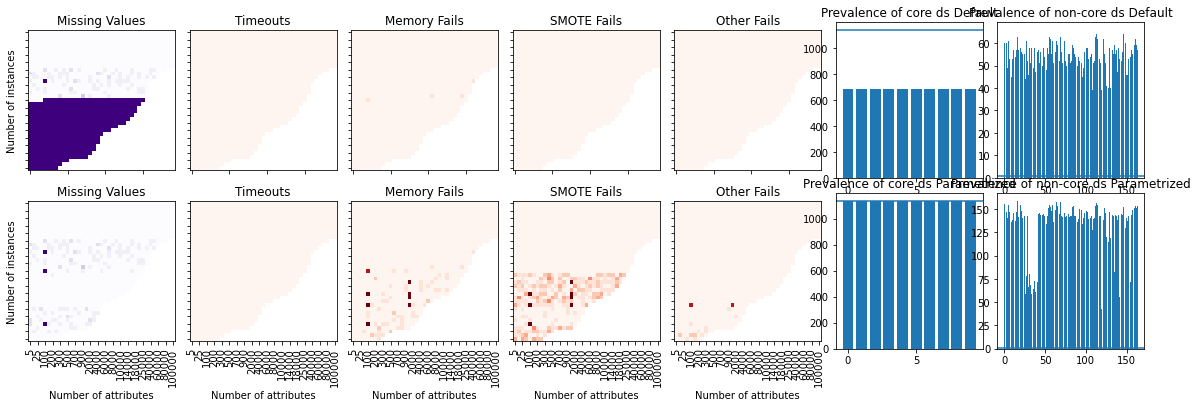

RANKER_ONERATTRIBUTEEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 62.29% completed.


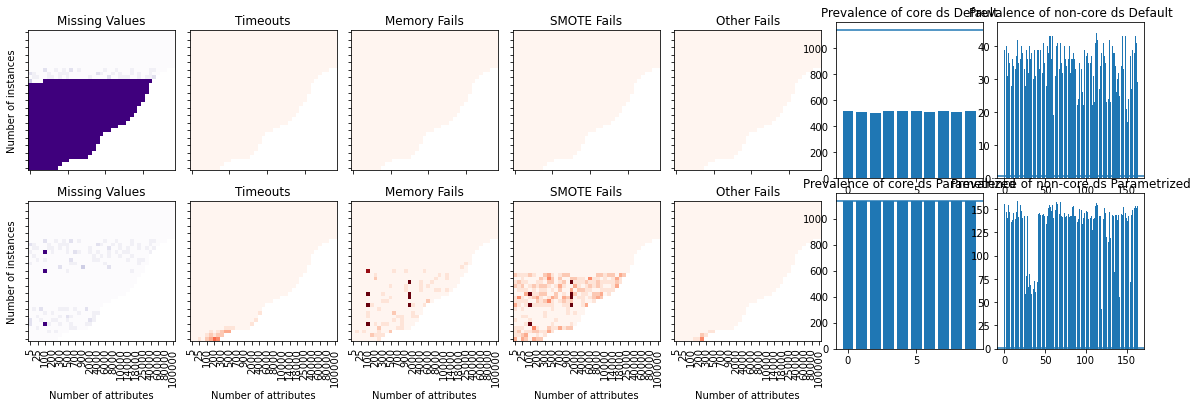

RANKER_PRINCIPALCOMPONENTS: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 40.06% completed.


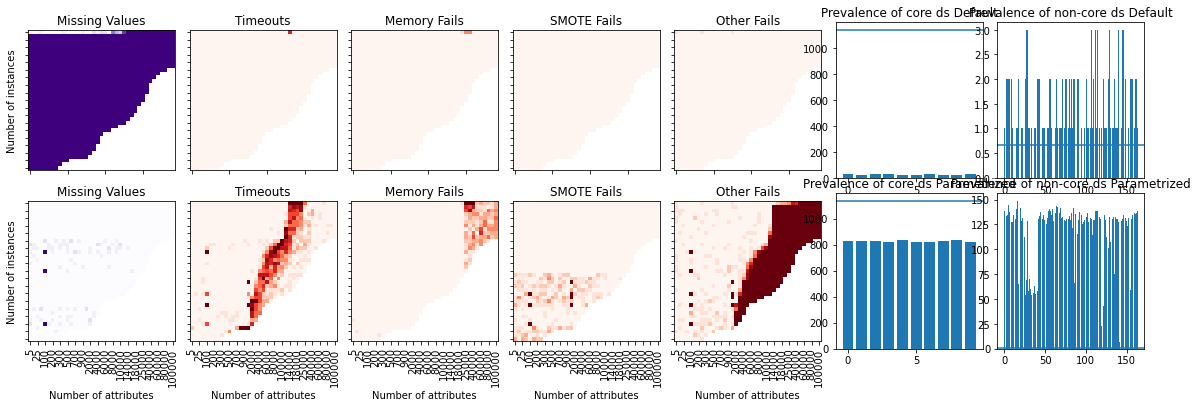

RANKER_RELIEFFATTRIBUTEEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 64.97% completed.


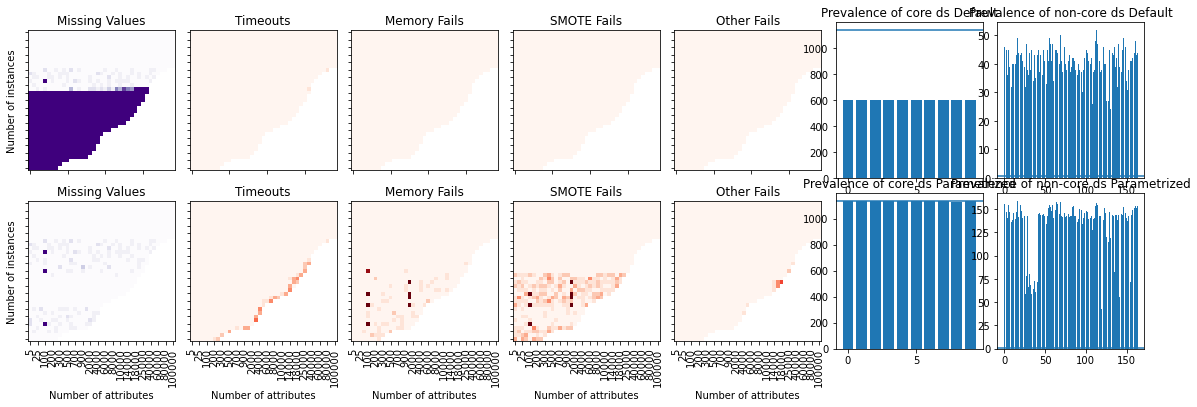

RANKER_SYMMETRICALUNCERTATTRIBUTEEVAL: Computing matrices.
Done. 35428 observations for default and 35428 observations for parametrized runs (within grid). 69.25% completed.


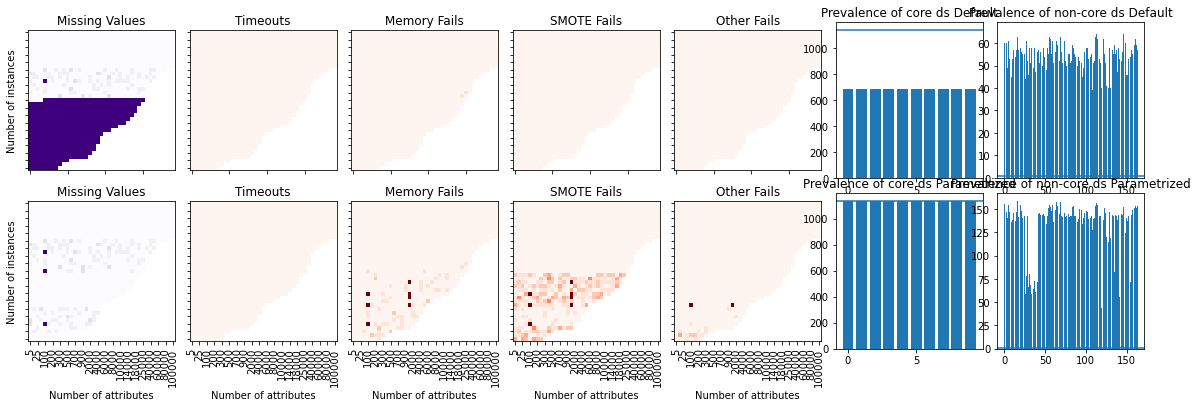

In [12]:
plotDataAvailability(STATUS_TABLES, dfErrored)

In [13]:
writeInsertQueriesForMissingPoints(STATUS_TABLES)

BAYESNET
Generated 99 queries for default experiments, and 403 for parametrized. Total number of status entries: 70856
DECISIONSTUMP
Generated 177 queries for default experiments, and 0 for parametrized. Total number of status entries: 35428
DECISIONTABLE
Generated 262 queries for default experiments, and 317 for parametrized. Total number of status entries: 70856
IBK
Generated 280 queries for default experiments, and 303 for parametrized. Total number of status entries: 70856
J48
Generated 314 queries for default experiments, and 315 for parametrized. Total number of status entries: 70856
JRIP
Generated 303 queries for default experiments, and 305 for parametrized. Total number of status entries: 70856
KSTAR
Generated 317 queries for default experiments, and 0 for parametrized. Total number of status entries: 35428
LMT
Generated 118 queries for default experiments, and 492 for parametrized. Total number of status entries: 70856
LOGISTIC
Generated 243 queries for default experiments, a

# 1. Runtime Plots (Section 4)

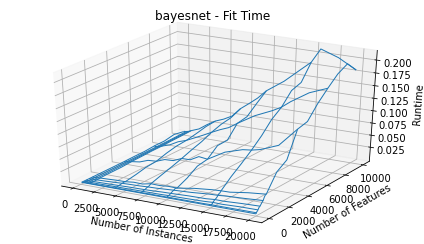

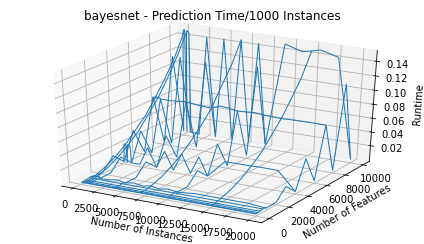

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


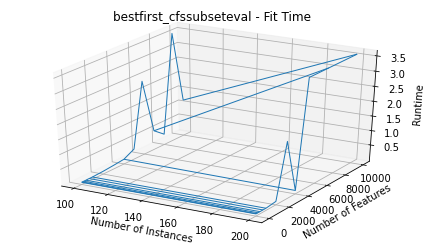

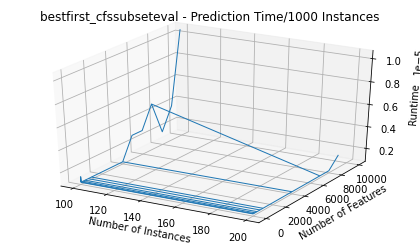

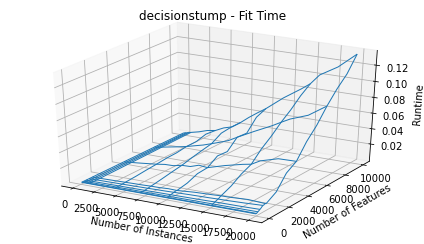

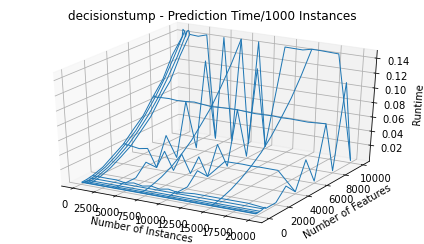

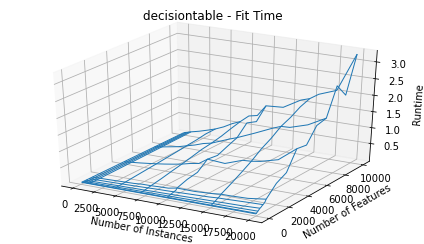

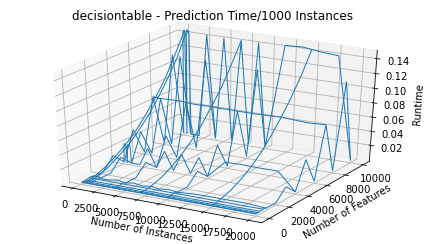

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


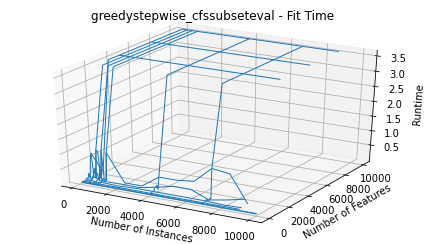

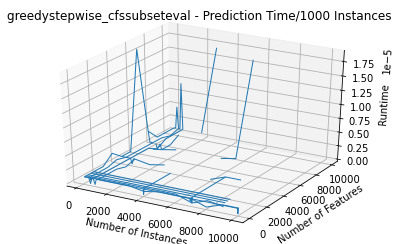

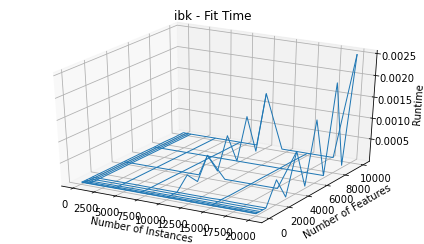

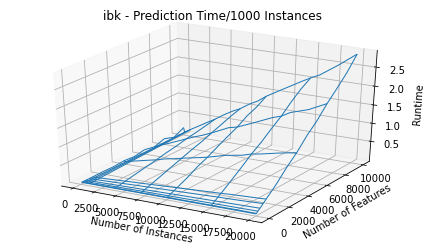

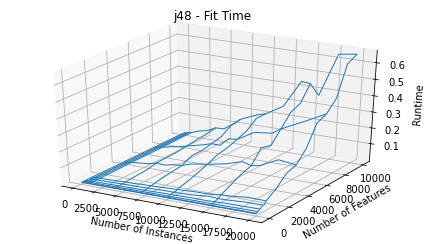

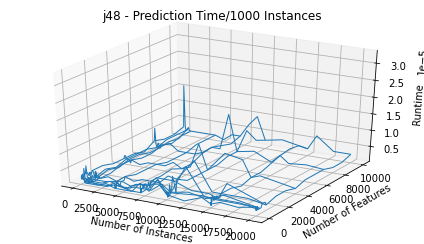

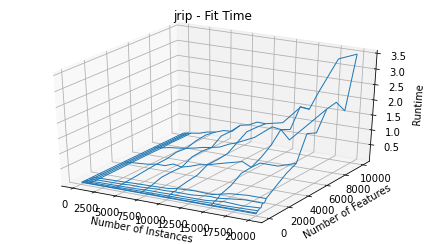

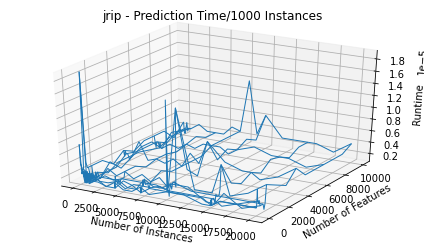

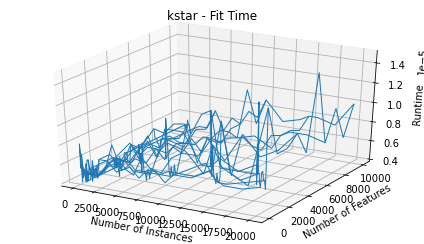

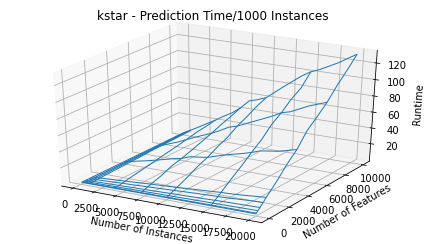

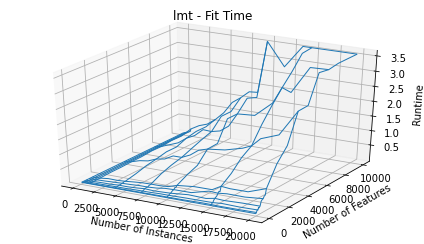

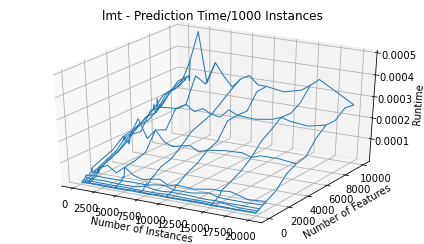

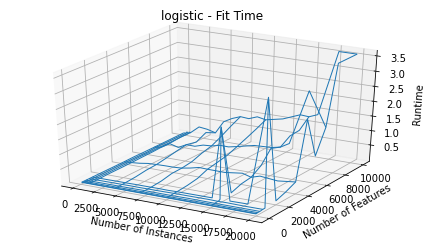

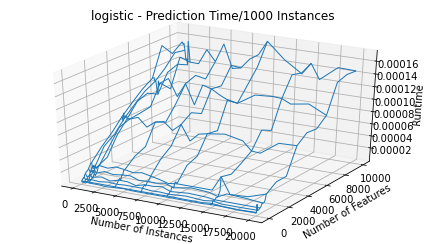

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


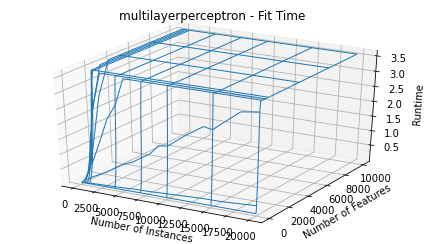

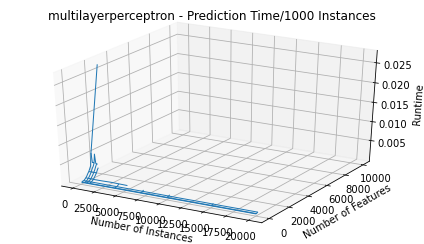

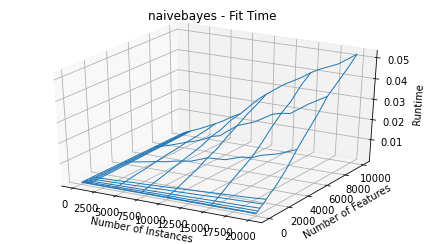

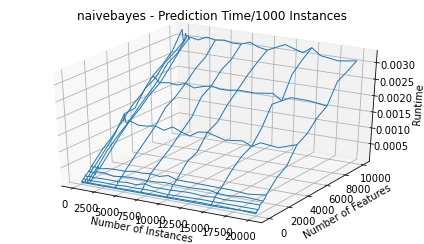

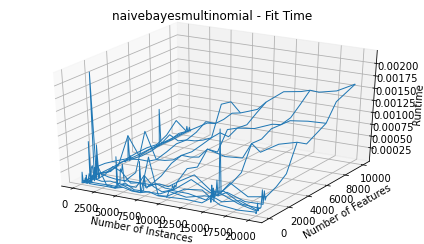

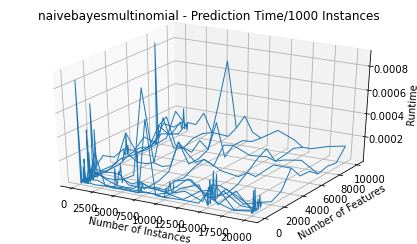

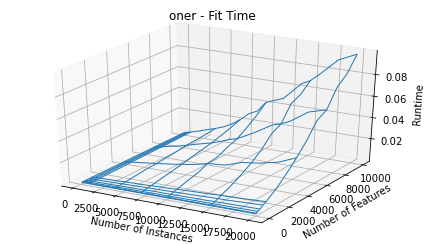

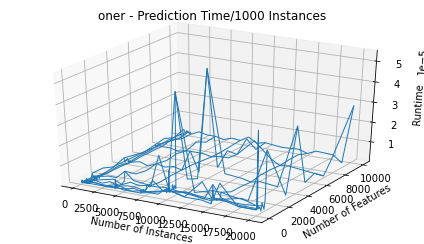

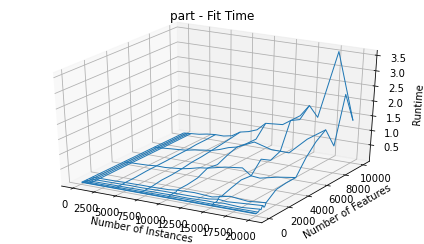

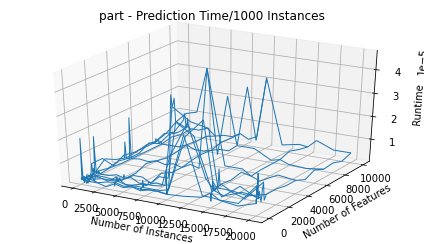

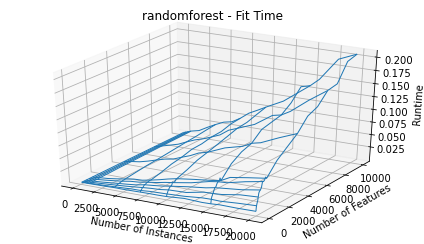

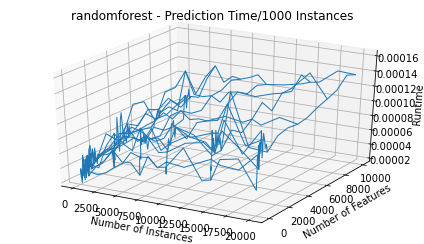

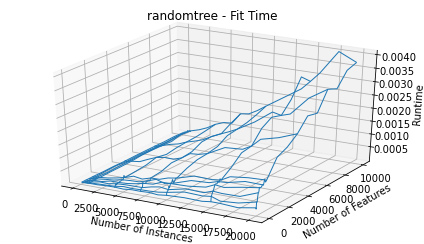

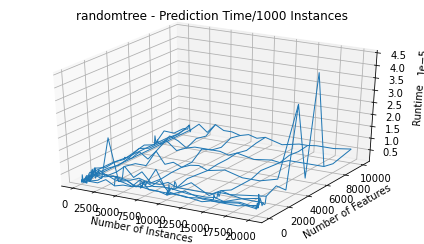

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


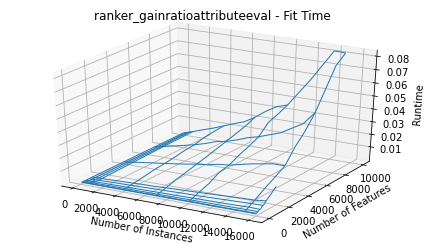

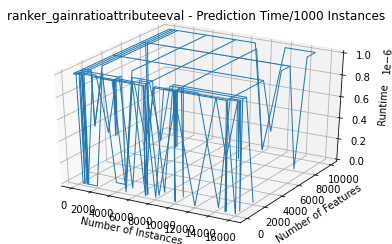

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


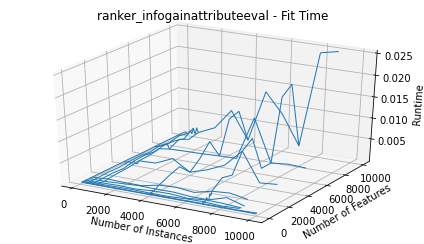

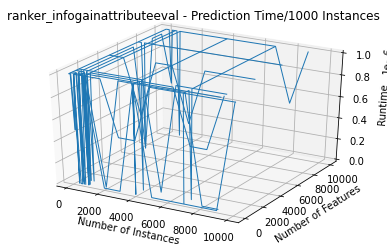

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


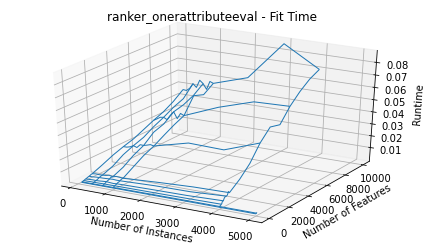

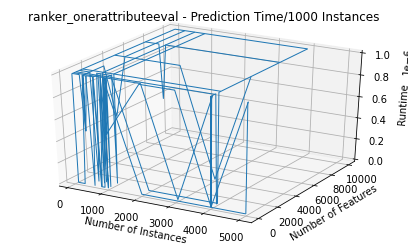

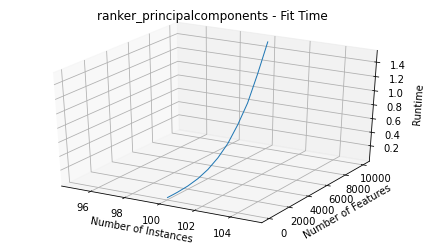

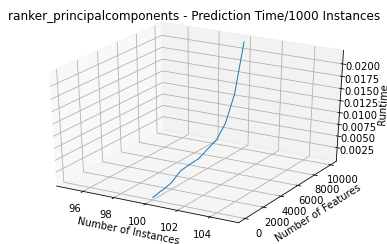

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


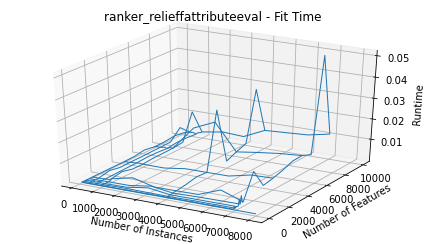

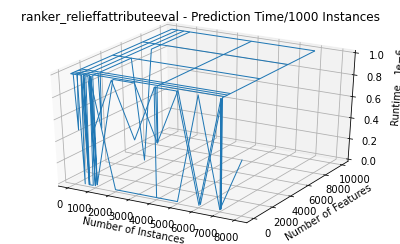

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


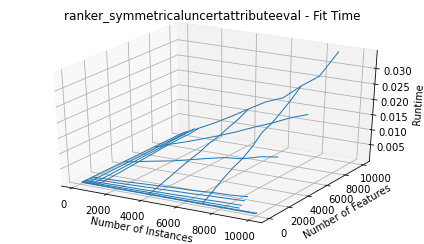

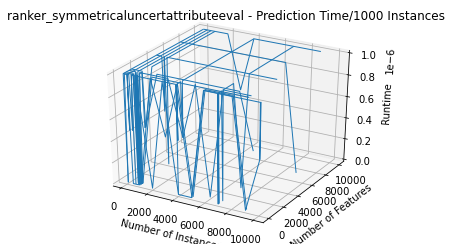

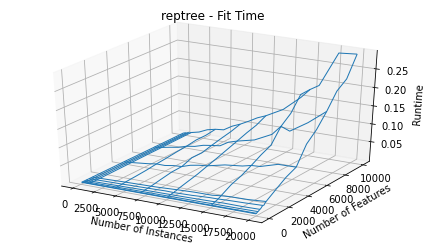

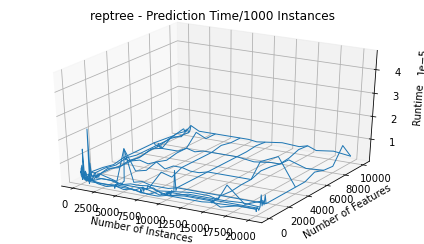

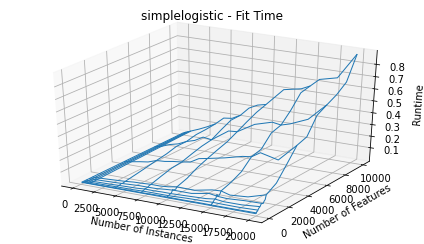

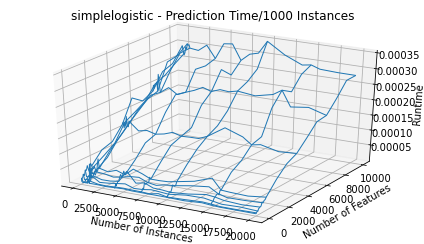

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


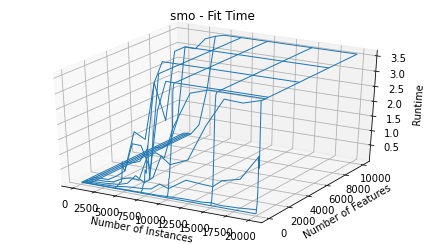

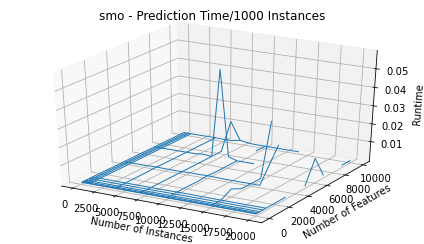

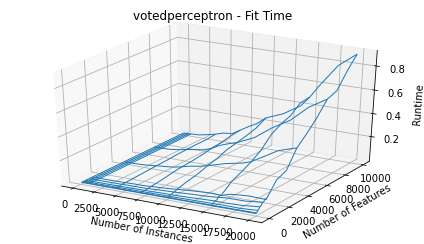

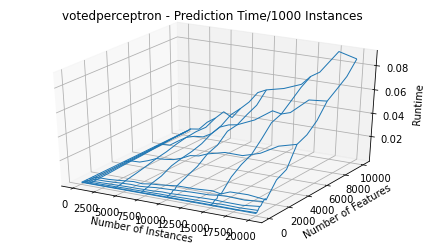

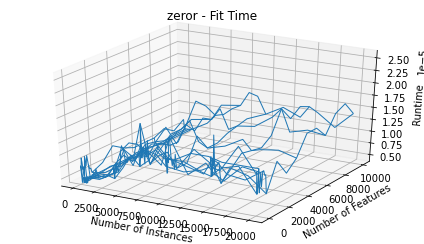

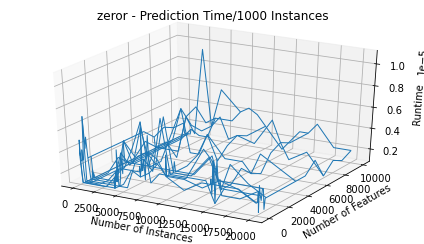

In [16]:
def plotRuntimes(dfComplete):
    for algorithm, df in dfComplete.groupby("algorithm"):
        trainpoints = sorted([s for s in np.unique(df["fitsize"]) if s <= 2 * 10**4])
        attributes = sorted([s for s in np.unique(df["fitattributes"]) if s <= 10**4])
        
        traintimes = np.zeros((len(trainpoints), len(attributes)))
        dispersion_traintimes = np.zeros((len(trainpoints), len(attributes)))
        testtimes = np.zeros((len(trainpoints), len(attributes)))
        dispersion_testtimes  = np.zeros((len(trainpoints), len(attributes)))
        for i, fitsize in enumerate(trainpoints):
            for j, numatts in enumerate(attributes):
                series = df[(df["fitsize"] == fitsize) & (df["fitattributes"] == numatts)]
                traintimes[i][j] = np.nanquantile(series["fittime"], 0.5) / 1000
                dispersion_traintimes[i][j] = np.nanstd(series["fittime"])# / np.nanmean(series["fittime"])
                testtimes[i][j] = np.nanquantile(series["applicationtimeperkinstances"], 0.5) / 1000
                dispersion_testtimes[i][j] = np.nanstd(series["applicationtimeperkinstances"])# / np.nanmean(series["applicationtimeperkinstances"])
                #traintimes[i][j] = np.nanmean(series["fittime"]) / 1000
                #testtimes[i][j] = np.nanmean(series["applicationtimeperkinstances"]) / 1000

        X, Y = np.meshgrid(trainpoints, attributes)
        #adjustLimits(projection, ax)
        for i, table in enumerate([traintimes, testtimes]):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            fig.set_figheight(3.5)
            fig.set_figwidth(6)
            ax.plot_wireframe(X, Y, table.T, rstride=3, cstride=3, linewidth=1, antialiased=True)
            ax.set_xlabel('Number of Instances')
            ax.set_ylabel('Number of Features')
            ax.set_zlabel('Runtime')
            ax.set_title(algorithm + " - " + ("Fit Time" if i == 0 else "Prediction Time/1000 Instances"))
            
            #ax = fig.add_subplot(1, 4, (2 * i + 2))
            #ax.imshow(dispersion_traintimes if i == 0 else dispersion_testtimes, vmax=1000)
            
            # The fix
            for spine in ax.spines.values():
                spine.set_visible(False)
            fig.tight_layout()
            fig.savefig("plots/runtimes_" + algorithm + "_" + ("train" if i == 0 else "predict") + ".pdf")
            
        plt.show()
        plt.close()

plotRuntimes(dfDefault)

Mean IQR:  2034.5025714285712


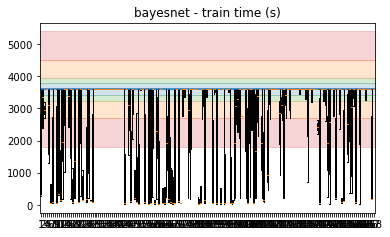

Mean IQR:  1381.929746478873


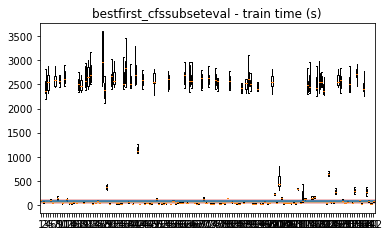

Mean IQR:  16.663120253164557


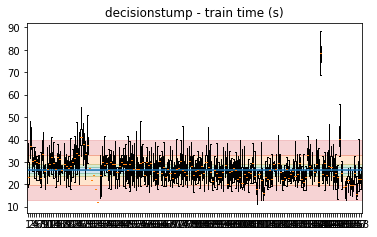

Mean IQR:  959.8080687499998


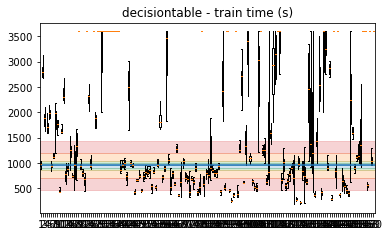

Mean IQR:  1204.71164


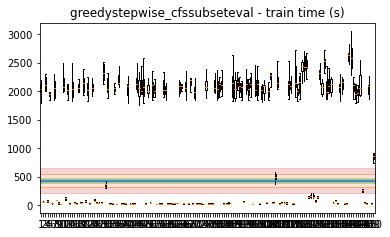

Mean IQR:  2.677026315789474


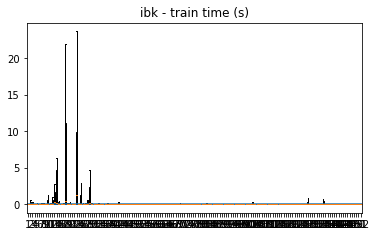

Mean IQR:  110.39171052631579


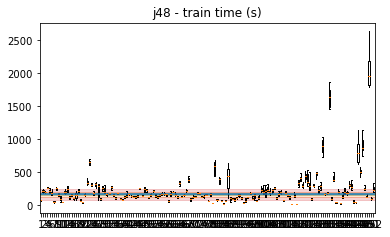

Mean IQR:  1870.846789473684


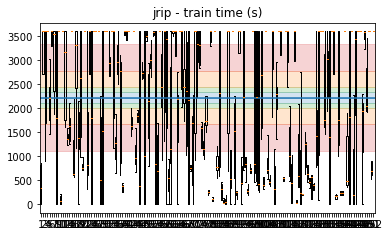

Mean IQR:  0.0


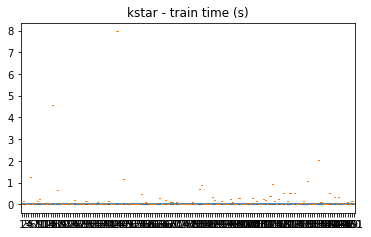

Mean IQR:  1438.084720779221


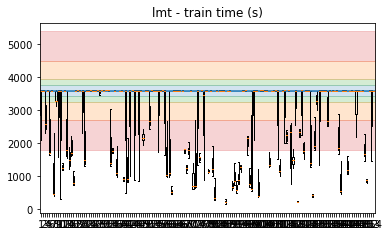

Mean IQR:  524.8315061728395


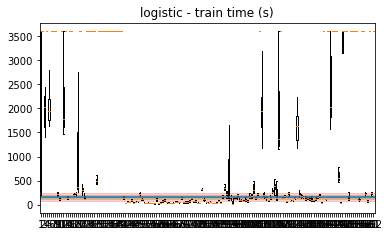

Mean IQR:  591.9363103448276


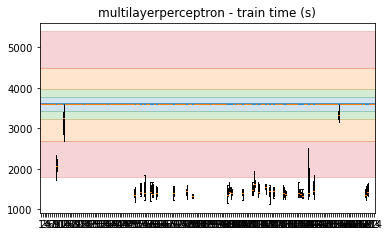

Mean IQR:  318.8605394736842


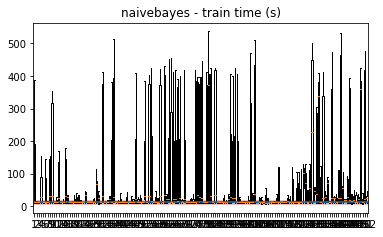

Mean IQR:  0.0


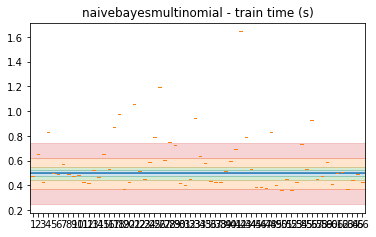

Mean IQR:  9.101217105263158


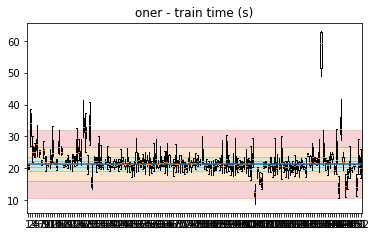

Mean IQR:  795.3888815789473


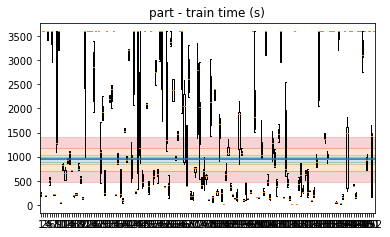

Mean IQR:  189.81165131578948


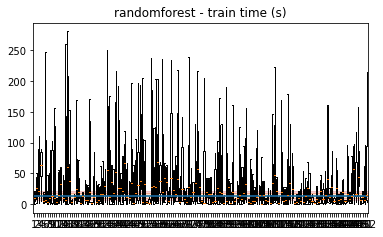

Mean IQR:  3.3492894736842103


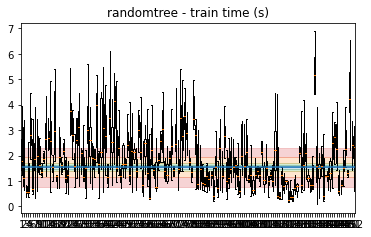

Mean IQR:  8.331940789473684


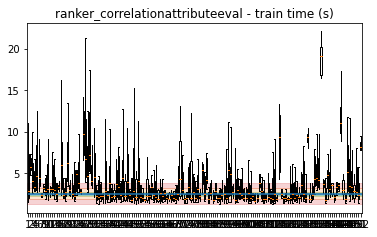

Mean IQR:  17.21305298013245


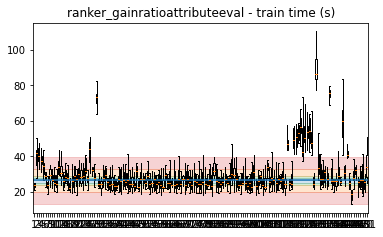

Mean IQR:  31.45399342105263


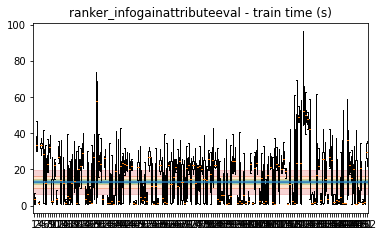

Mean IQR:  156.2753486842105


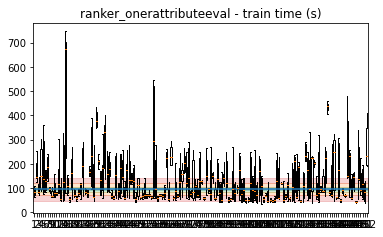

Mean IQR:  496.6675578231292


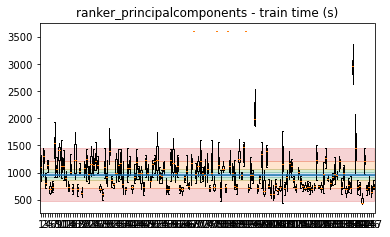

Mean IQR:  316.5229605263158


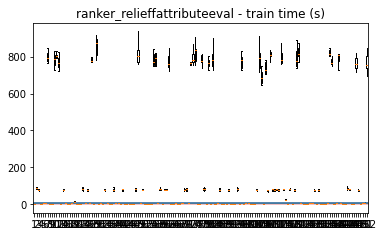

Mean IQR:  19.47194039735099


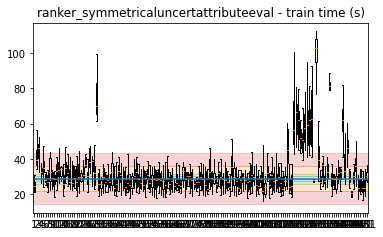

Mean IQR:  53.16389473684211


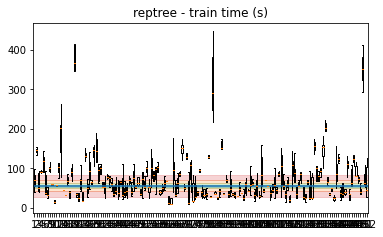

Mean IQR:  773.8697368421053


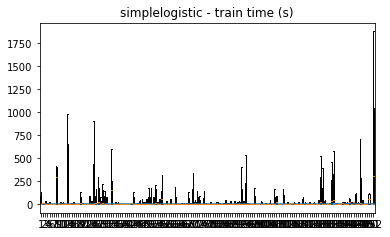

Mean IQR:  3052.8387564102563


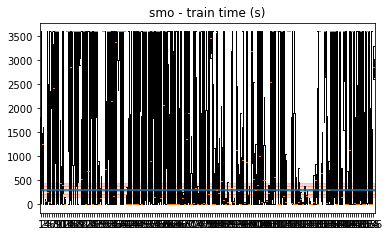

Mean IQR:  2107.6407207207208


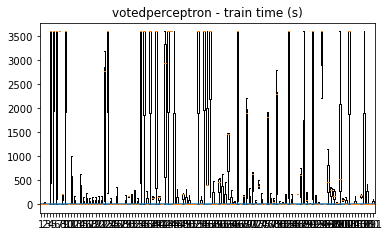

Mean IQR:  0.0


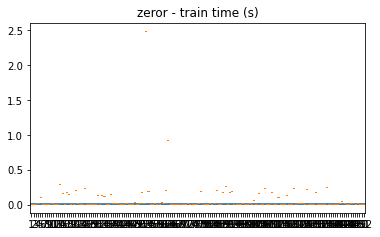

In [17]:
def plotDispersionAtValidationPoint(df):
    dfDispersion = df[(df["fitsize"] == 50000) & (df["fitattributes"] == 1000)]
    for algorithm, dfAlgo in dfDispersion.groupby("algorithm"):
        groupsTrain = []
        flatvaluesTrain = []
        groupsPredict = []
        flatvaluesPredict = []
        for openmlid, group in dfAlgo.groupby("openmlid"):
            groupsTrain.append(group["fittime"].values)
            flatvaluesTrain.append(np.median(group["fittime"].values))
            groupsPredict.append(group["applicationtimeperkinstances"].values)
            flatvaluesPredict.append(np.median(group["applicationtimeperkinstances"].values))

        fill_stepsizes = [0.05, 0.1, 0.25, 0.5]
        colors = ["C0", "C2", "C1", "C3"]

        fig, ax = plt.subplots(1, 1, figsize=(6,3.5), sharex=True)
        
        for i, (groups, flatvalues) in enumerate([(groupsTrain, flatvaluesTrain)]):#, (groupsPredict, flatvaluesPredict)]):
            ax.boxplot(groups, 0, '')
            med = np.median(flatvalues)
            ax.set_title(algorithm + " - " + ("train time (s)" if i == 0 else "prediction time per k instances (ms)"))
            ax.axhline(med)

            print("Mean IQR: ", np.mean([np.max(g) - np.min(g) for g in groups]))

            for i, size in enumerate(fill_stepsizes):
                last_size = 0 if i == 0 else fill_stepsizes[i-1]
                ax.fill_between([0.5, len(groupsTrain) + .5], med * (1 - last_size), med * (1 - size), alpha=0.2, color=colors[i])
                ax.fill_between([0.5, len(groupsTrain) + .5], med * (1 + last_size), med * (1 + size), alpha=0.2, color=colors[i])
                #ax.set_yscale("log")
        fig.savefig("plots/varianceboxplots_" + algorithm + ".pdf")
        plt.show()
        
plotDispersionAtValidationPoint(df)

# 2. Learning Curves for each regressor/algorithm combo (Section 4)
Use the feature sets that are best with respect to the samples.

## 2.1 Defining The Grid over Which the Learning Curves Are Generated

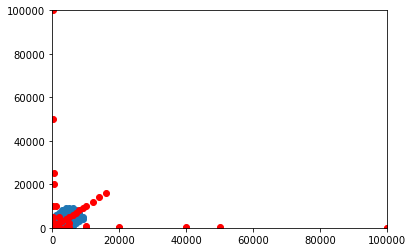

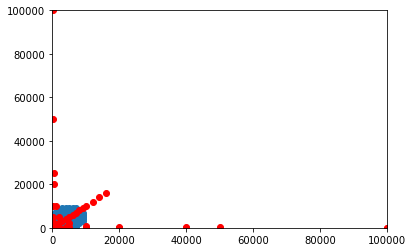

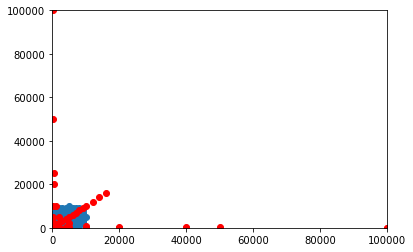

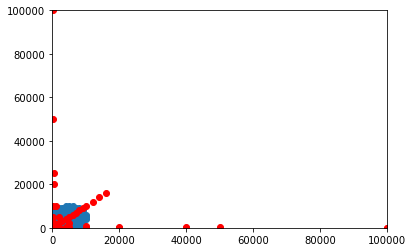

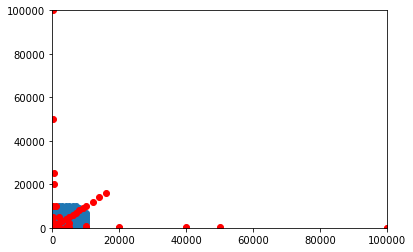

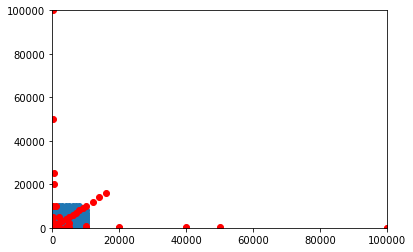

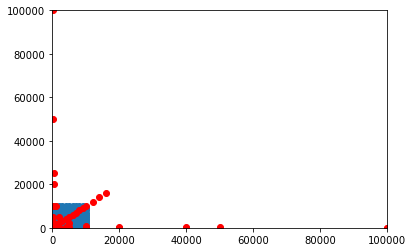

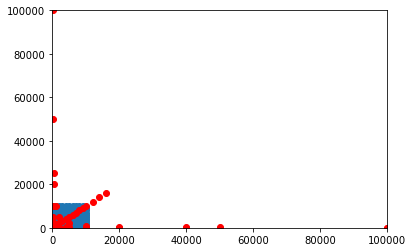

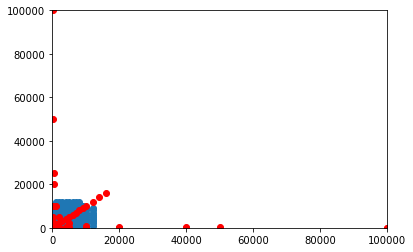

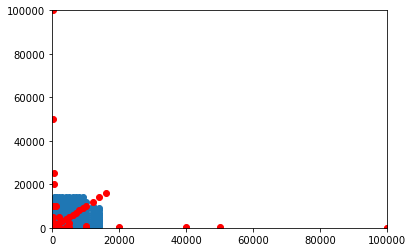

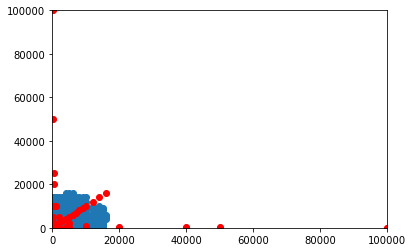

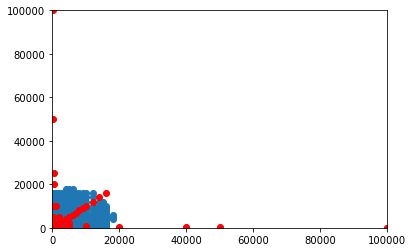

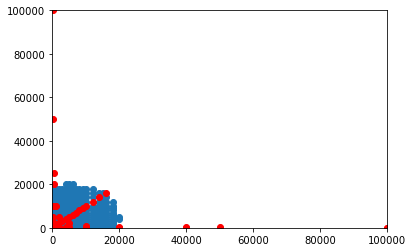

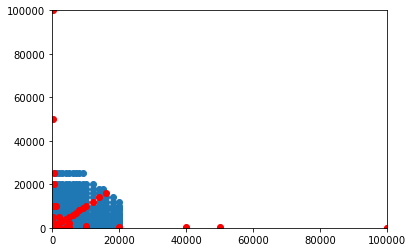

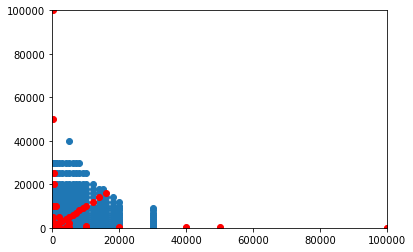

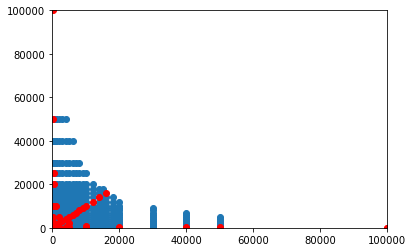

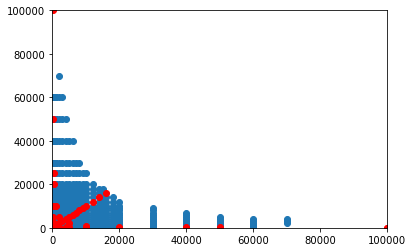

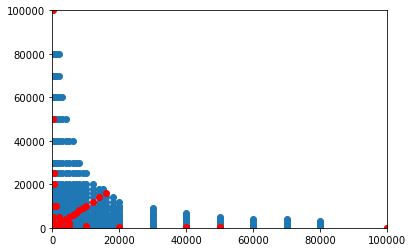

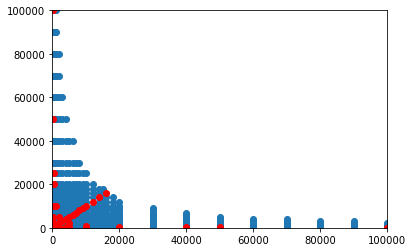

In [18]:
P = getEvaluationGridPoints()

# first define the 58 validation indices
mask = (P[:,0] == P[:,1]) | (P[:,0] * P[:,1] == 10**4) | (P[:,0] * P[:,1] == 10**5) | (P[:,0] * P[:,1] == 10**6) | (P[:,0] * P[:,1] == 10**7)
ref = np.array([5000, 5000])
trainindices = np.array(sorted(np.where(~mask)[0], key=lambda x: np.linalg.norm(ref - P[x])))
validationindices = np.where(mask)[0]

# show the points
for i in range(50, len(trainindices), 50):
    fig, ax = plt.subplots()
    ax.scatter(P[trainindices[:i],0], P[trainindices[:i],1])
    ax.scatter(P[validationindices,0], P[validationindices,1], color="red")
    ax.set_xlim([0, 10**5])
    ax.set_ylim([0, 10**5])
    plt.show()

## 2.2 Compute Data for Learning Curves

In [19]:
def getStandardTrainIndicesInGrid():
    P = getEvaluationGridPoints()

    # first define the 58 validation indices
    mask = (P[:,0] == P[:,1]) | (P[:,0] * P[:,1] == 10**4) | (P[:,0] * P[:,1] == 10**5) | (P[:,0] * P[:,1] == 10**6) | (P[:,0] * P[:,1] == 10**7)
    ref = np.array([5000, 5000])
    return np.array(sorted(np.where(~mask)[0], key=lambda x: np.linalg.norm(ref - P[x])))

'''
for a dataframe of observations and a given algorithm and number of samples used for training,
gets the indices of the rows in the dataframe that should be used for training

it uses *only* core datasets for learning, and within these also excludes those that are potentially used for validation
'''
def getTrainIndicesForDefaultModel(df, algorithm, numtraininstances, gridtrainindices = None):
    
    P = getEvaluationGridPoints()
    
    if gridtrainindices is None:
        gridtrainindices = getStandardTrainIndicesInGrid()
    
    generalMatches = (df["algorithm"] == algorithm) & (df["algorithmoptions"].isna()) & (df["seed"] == 0)
    
    # compile indices in df used for training
    rowMaskForTraining = None
    for indexOfTrainingInstance in range(int(numtraininstances * 1.1)): # 10% are off because used for validation
        openmlid = coredatasets[indexOfTrainingInstance % len(coredatasets)]
        gridpoint = P[gridtrainindices[int(np.floor(indexOfTrainingInstance / len(coredatasets))) % len(gridtrainindices) ]]
        matches = generalMatches & (df["openmlid"] == openmlid) & (df["fitsize"] == gridpoint[0]) & (df["fitattributes"] == gridpoint[1])
        rowMaskForTraining = matches if rowMaskForTraining is None else rowMaskForTraining | matches
    return rowMaskForTraining

In [20]:
import math

def trainAndGetPredictions(df, learners, trainmask, validationmask, basefeaturespace = ["fitsize", "fitattributes", "af1", "af2"], algorithmfeatures=False, defaultobservations=False, serializeModel=True):
    
    if defaultobservations and not algorithmfeatures:
        raise Exception("Invalid combination. If defaultobservations is set, algorithmfeatures must also be set")
    
    # make sure that the dataframe is consistent in that only data about a single algorithm is contained
    algorithms = pd.unique(df["algorithm"])
    if len(algorithms) != 1:
        raise Exception("Non-Unique algorithms in given dataframe: " + str(algorithms))
    algorithm = algorithms[0]
    
    if type(learners) != list:
        learners = [learners]

    # get train data and test data
    dfTrain = df[trainmask]
    dfTest = df[validationmask]
    parameterfeatures = []
    if algorithmfeatures:
        trainExtension = explodeAlgorithmOptions(dfTrain[["algorithmoptions"]], algorithm=algorithm).drop(columns=["algorithmoptions"])
        testExtension = explodeAlgorithmOptions(dfTest[["algorithmoptions"]], algorithm=algorithm).drop(columns=["algorithmoptions"])
        for col in ["searcheroptions", "evaloptions"]:
            if col in list(trainExtension.columns):
                trainExtension = trainExtension.drop(columns=[col])
                testExtension = testExtension.drop(columns=[col])
        parameterfeatures.extend(trainExtension.columns)
        print(parameterfeatures)
        dfTrain = pd.concat([dfTrain, trainExtension], axis=1)
        dfTest = pd.concat([dfTest, testExtension], axis=1)
    suitedForTrainingFittime = dfTrain["fittime"].notna()
    suitedForPredictFittime = dfTest["fittime"].notna()
    suitedForTrainingApptime = dfTrain["applicationtimeperkinstances"].notna()
    suitedForPredictApptime = dfTest["applicationtimeperkinstances"].notna()
    dfTrainFittime = dfTrain[suitedForTrainingFittime]
    dfTrainApptime = dfTrain[suitedForTrainingApptime]
    dfTestFittime = dfTest[suitedForPredictFittime]
    dfTestApptime = dfTest[suitedForPredictApptime]
    openmlids = pd.unique(pd.concat([dfTestFittime["openmlid"], dfTestApptime["openmlid"]]))
    fitpairs = list(set([gIndex for gIndex, group in dfTestFittime.groupby(["fitsize", "fitattributes"])] + [gIndex for gIndex, group in dfTestApptime.groupby(["fitsize", "fitattributes"])]))
    features = basefeaturespace + parameterfeatures
    featuresFittime = features.copy()
    featuresApptime = features.copy()
    #logging.debug("Identified " + str(len(dfTrainFittime)) + " instances usable for training fittime and " + str(len(suitedForPredictFittime)) + " to predict it.")
    #logging.debug("Identified " + str(len(suitedForTrainingApptime)) + " instances usable for training apptime and " + str(len(suitedForPredictApptime)) + " to predict it.")
    
    # if we fit a posterior model, add a column with the default runtimes to the fittime and apptime train frame
    if defaultobservations:
        #logging.debug("Default Observations: ON")
        featuresFittime = featuresFittime + ["openmlid", "fittime_default"]
        featuresApptime = featuresApptime + ["openmlid", "applicationtimeperkinstances_default"]
        suitedForTrainingFittime &= dfTrain["fittime_default"].notna()
        suitedForPredictFittime &= dfTest["fittime_default"].notna()
        suitedForTrainingApptime &= dfTrain["applicationtimeperkinstances_default"].notna()
        suitedForPredictApptime &= dfTest["applicationtimeperkinstances_default"].notna()

    # create a mask that excludes validation points
    trainsizefilters = [True for i in range(len(dfTrainFittime))]
    for fitsize, fitattributes in fitpairs:
        trainsizefilters = trainsizefilters & ~((dfTrainFittime["fitsize"] == fitsize) & (dfTrainFittime["fitattributes"] == fitattributes))
    print("After the validation filter we still have " + str(np.count_nonzero(trainsizefilters)) + " active records.")
    
    # now create validations for each openmlid id (training on the others)        
    rows = []
    for openmlid in openmlids:
        
        # restrict ourselves only to the other datasets
        trainSubIndices = trainsizefilters & (dfTrainFittime["openmlid"] != openmlid)
        print(np.count_nonzero(trainSubIndices), "active rows for training.")
        for fitsize, fitattributes in fitpairs:
            trainSubIndices = trainSubIndices & ~((dfTrainFittime["fitsize"] == fitsize) & (dfTrainFittime["fitattributes"] == fitattributes))
        dfTrainFittimeRed = dfTrain[trainSubIndices & suitedForTrainingFittime]
        dfTrainApptimeRed = dfTrain[trainSubIndices & suitedForTrainingApptime]
        
        # sanity check
        if len(dfTrainFittimeRed[dfTrainFittimeRed["openmlid"] == openmlid]) > 0:
            raise Exception()
        if len(dfTrainApptimeRed[dfTrainApptimeRed["openmlid"] == openmlid]) > 0:
            raise Exception()
        
        # check which models are required
        pairsthatwillberequired = [pair for pair in fitpairs if len(dfTestFittime[(dfTestFittime["openmlid"] == openmlid) & (dfTestFittime["fitsize"] == pair[0]) & (dfTestFittime["fitattributes"] == pair[1])]) > 0]
        
        # build models
        models = {}
        for learner in learners:
            models[learner] = {}
            reg = getRegressionAlgorithm(learner)
            
            print("Now training a " + learner + " on openmlid " + str(openmlid) + " with " + str(len(dfTrainFittimeRed)) + " instances.")
            #print("Fit:", dfTrainFittimeRed["fittime"])
            XFittime = dfTrainFittimeRed[featuresFittime]
            YFittime = dfTrainFittimeRed["fittime"]
            #logging.debug("Training model with " + str(len(XFittime)) + " instances.")
            #print(XFittime)
            #print(YFittime)
            
            # train fittime model
            reg.fit(XFittime, YFittime)
            models[learner]["fittime"] = reg
            if serializeModel:
                modeltype = "default" if not algorithmfeatures else ("posterior" if defaultobservations else "standard")
                filename = 'data/models/' + learner + '/' + modeltype + '_' + algorithm + '_' + str(openmlid) + '_fittime.mod'
                pickle.dump(reg, open(filename, 'wb'), -1)
                
            
            # train apptime model
            if len(dfTrainApptimeRed[featuresApptime]) > 0:
                reg = getRegressionAlgorithm(learner)        
                reg.fit(dfTrainApptimeRed[featuresApptime], dfTrainApptimeRed["applicationtimeperkinstances"])
                models[learner]["apptime"] = reg
                if serializeModel:
                    modeltype = "default" if not algorithmfeatures else ("posterior" if defaultobservations else "standard")
                    filename = 'data/models/' + learner + '/' + modeltype + '_' + algorithm + '_' + str(openmlid) + '_apptime.mod'
                    pickle.dump(reg, open(filename, 'wb'))
        
        # now get predictions for different sizes
        for fitsize, fitattributes in fitpairs:
            
            testSubIndices = (dfTest["openmlid"] == openmlid) & (dfTest["fitsize"] == fitsize) & (dfTest["fitattributes"] == fitattributes)
            testIndicesWithValidFittime = np.where(testSubIndices & suitedForPredictFittime)[0]
            testIndicesWithValidApptime = np.where(testSubIndices & suitedForPredictApptime)[0]

            # build models and obtain predictions
            for learner in learners:

                # initialize row
                row = [learner, algorithm, basefeaturespace, openmlid, fitsize, fitattributes, np.where(trainmask)[0], np.where(validationmask)[0]]

                # fittime
                if len(testIndicesWithValidFittime) > 0:
                    fit_truth = []
                    fit_predictions = []
                    app_truth = []
                    app_predictions = []
                    for index in testIndicesWithValidFittime:
                    
                        testrow = dfTest.iloc[index]
                        
                        reg = models[learner]["fittime"]
                        prediction = reg.predict([testrow[featuresFittime]])[0]
                        truth = testrow["fittime"]
                        #print(truth, prediction)
                        fit_truth.append(np.round(truth, 2))
                        fit_predictions.append(np.round(prediction, 2))

                        # application times belong to the fittimes
                        if "apptime" in models[learner] and (not math.isnan(testrow["applicationtimeperkinstances"])) and not (defaultobservations and math.isnan(testrow["applicationtimeperkinstances_default"])):
                            reg = models[learner]["apptime"]
                            prediction = reg.predict([testrow[featuresApptime]])[0]
                            truth = testrow["applicationtimeperkinstances"]
                            logging.debug("Truth: %s, Prediction: %s", truth, prediction)
                            app_truth.append(np.round(truth, 2))
                            app_predictions.append(np.round(prediction, 2))
                        else:
                            app_truth.append(np.nan)
                            app_predictions.append(np.nan)
                    row.extend([fit_truth, fit_predictions, app_truth, app_predictions])
                else:
                    row.extend([[], [], [], []])

                # append the row to the set of rows we have
                rows.append(row)
    
    return pd.DataFrame(rows, columns=["learner", "algorithm", "features", "openmlid", "fitsize", "fitattributes", "trainindices", "validationindices", "truth_fit", "predictions_fit", "truth_app", "predictions_app"])

In [21]:
def getRegressionAlgorithm(learner):
    if learner == 'forest':
        reg = RandomForestRegressor(n_estimators=100)
    else:
        if learner == "ann":
            reg = sk.neural_network.MLPRegressor(random_state=1, max_iter=2000)
        else:
                if learner == "linear":
                    reg = sk.linear_model.LinearRegression()
                else:
                    if learner == "isotonic":
                        reg = IsotonicRegression()
                    else:
                        raise Exception("Unknown learner " + learner)
    return reg

In [22]:
def getLearningCurveEntries(df, maxtrainpoints = 10000, stepsize=50):
    if len(trainindices) != 1000:
        raise Exception("Length of P should be 1000")
    
    dfCleaned = df[(df["algorithmoptions"].isna()) & (df["seed"] == 0)]
    dfResults = pd.read_csv(FILENAME_LEARNINGCURVES, delimiter=";") if path.exists(FILENAME_LEARNINGCURVES) else None
    
    for algorithm, dfReduced in dfCleaned.groupby("algorithm"):

        learners = regressors#[r for r in regressors if r != "ann"]
        pbar = tqdm(total=maxtrainpoints / stepsize)
        tDomain = range(stepsize, maxtrainpoints + 1, stepsize)

        # compile indices in df used for validation
        dfIndicesUsedForValidation = None
        for i in validationindices:
            gridpoint = P[i]
            for openmlid in coredatasets:
                matches = (dfReduced["openmlid"] == openmlid) & (dfReduced["fitsize"] == gridpoint[0]) & (dfReduced["fitattributes"] == gridpoint[1])
                dfIndicesUsedForValidation = matches if dfIndicesUsedForValidation is None else (matches | dfIndicesUsedForValidation)
        print("Identified " + str(np.count_nonzero(dfIndicesUsedForValidation)) + " validation indices.")

        # check that input space is sane
        for f in ["fitsize", "fitattributes", "af1", "af2"]:
            missingIndices = dfReduced[f].isna()
            missing = np.count_nonzero(missingIndices)
            if missing > 0:
                raise Exception("There are " + str(missing) + " input entries that do not have a value for \"" + f + "\".\n\n" + str(dfReduced[missingIndices]))

        for i, size in enumerate(tDomain):
            
            print("Now creating learning curve entries for " + algorithm + " with " + str(size) + " training examples.")
            
            cache_lookup = (dfResults["algorithm"] == algorithm) & (dfResults["size"] == size)
            dfCache = dfResults[cache_lookup]
            allEntriesThere = True
            for l, learner in enumerate(learners):
                for t, target in enumerate(["fit", "app"]):
                    if np.count_nonzero((dfCache["learner"] == learner) & (dfCache["target"] == target)) == 0:
                        allEntriesThere = False
                        break
            
            if not allEntriesThere:

                # compile indices in df used for training
                logging.debug("Compute training indices for a train size of " + str(size) + ".")
                dfIndicesUsedForTraining = getTrainIndicesForDefaultModel(dfReduced, algorithm, size)
                logging.debug("Ready, now checking consistency, that none of these indices are used as validation")
                if np.count_nonzero(dfIndicesUsedForTraining & dfIndicesUsedForValidation) > 0:
                        raise Exception("Train points must not be contained in validation set!")

                logging.debug("Done. Training on %s instances.", np.count_nonzero(dfIndicesUsedForTraining))
                #print("Start training")
                print(np.count_nonzero(dfIndicesUsedForTraining))
                if size - np.count_nonzero(dfIndicesUsedForTraining) > 200:
                    print("Expected " + str(size) + " train points, but only " + str(np.count_nonzero(dfIndicesUsedForTraining)) + " have been activated")
                dfResultsTmp = trainAndGetPredictions(dfReduced, learners, dfIndicesUsedForTraining, dfIndicesUsedForValidation, basefeaturespace = ["fitsize", "fitattributes", "af1", "af2"], algorithmfeatures=False, defaultobservations=False, serializeModel=False)
                rows = []
                for l, learner in enumerate(learners):
                    dfLearner = dfResultsTmp[dfResultsTmp["learner"] == learner]
                    for t, target in enumerate(["fit", "app"]):
                        A = [i for l in list(dfLearner["truth_" + target].values) for i in l]
                        F = [i for l in list(dfLearner["predictions_" + target].values) for i in l]
                        row = [algorithm, learner, size, target, RMSE(A, F)]
                        #print("RMSE on " + target + " for " + learner + ": " + str(rmse[l][i][t]) +  ". Validation based on " + str(len(A)) + " entries")
                        rows.append(row)
                        #print(A, F, rmse[l][i][t])
                dfResultsAppended = pd.DataFrame(rows, columns=["algorithm", "learner", "size", "target", "rmse"])
                dfResults = dfResultsAppended if dfResults is None else pd.concat([dfResults, dfResultsAppended], axis=0)
                dfResults.to_csv(FILENAME_LEARNINGCURVES, sep=";", index=False)
                print("Saved learning curve results to " + FILENAME_LEARNINGCURVES)
            else:
                print("All entries are in cache. Skipping.")
            pbar.update(1)
        pbar.close()
        return dfResults

In [23]:
def getLearningCurveDF(algorithms=None):
    if algorithms is None:
        algorithms = classifiers
    dfResults = None
    for algorithm in algorithms:
        print(algorithm)
        if algorithm != "naivebayesmultinomial":
            dfResultsTmp = getLearningCurveEntries(df[df["algorithm"] == algorithm], maxtrainpoints=10000, stepsize = 500)
            dfResults = dfResultsTmp if dfResults is None else pd.concat([dfResults, dfResultsTmp])
        else:
            print("Skipping, because no support for " + algorithm)
    
    return dfResults

getLearningCurveDF()

bayesnet


Identified 483 validation indices.
Now creating learning curve entries for bayesnet with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for bayesnet with 

Identified 580 validation indices.
Now creating learning curve entries for decisionstump with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisionstump with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisionstump with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisionstump with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisionstump with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisionstump with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisionstump with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisionstump with 4000 training examples.
All entries are in cache. Skipping.
Now creating l

Identified 580 validation indices.
Now creating learning curve entries for decisiontable with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisiontable with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisiontable with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisiontable with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisiontable with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisiontable with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisiontable with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for decisiontable with 4000 training examples.
All entries are in cache. Skipping.
Now creating l

Identified 580 validation indices.
Now creating learning curve entries for ibk with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for ibk with 4500 training examples.
All entries are in ca

Identified 580 validation indices.
Now creating learning curve entries for j48 with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for j48 with 4500 training examples.
All entries are in ca

Identified 580 validation indices.
Now creating learning curve entries for jrip with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for jrip with 4500 training examples.
All entries 

Identified 643 validation indices.
Now creating learning curve entries for kstar with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for kstar with 4500 training examples.
All

Identified 580 validation indices.
Now creating learning curve entries for lmt with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for lmt with 4500 training examples.
All entries are in ca

Identified 679 validation indices.
Now creating learning curve entries for logistic with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for logistic with 

Identified 759 validation indices.
Now creating learning curve entries for multilayerperceptron with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for multilayerperceptron with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for multilayerperceptron with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for multilayerperceptron with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for multilayerperceptron with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for multilayerperceptron with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for multilayerperceptron with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for multilayerperceptron with 4000 training exam

Identified 915 validation indices.
Now creating learning curve entries for naivebayes with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for naivebayes with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for naivebayes with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for naivebayes with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for naivebayes with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for naivebayes with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for naivebayes with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for naivebayes with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries fo

Identified 580 validation indices.
Now creating learning curve entries for oner with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for oner with 4500 training examples.
All entries 

Identified 580 validation indices.
Now creating learning curve entries for part with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for part with 4500 training examples.
All entries 

Identified 580 validation indices.
Now creating learning curve entries for reptree with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for reptree with 4500 trai

Identified 580 validation indices.
Now creating learning curve entries for randomforest with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomforest with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomforest with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomforest with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomforest with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomforest with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomforest with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomforest with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning 

Identified 580 validation indices.
Now creating learning curve entries for randomtree with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomtree with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomtree with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomtree with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomtree with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomtree with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomtree with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for randomtree with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries fo

Identified 580 validation indices.
Now creating learning curve entries for simplelogistic with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for simplelogistic with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for simplelogistic with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for simplelogistic with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for simplelogistic with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for simplelogistic with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for simplelogistic with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for simplelogistic with 4000 training examples.
All entries are in cache. Skipping.
Now cr

Identified 580 validation indices.
Now creating learning curve entries for smo with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for smo with 4500 training examples.
All entries are in ca

Identified 522 validation indices.
Now creating learning curve entries for votedperceptron with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for votedperceptron with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for votedperceptron with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for votedperceptron with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for votedperceptron with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for votedperceptron with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for votedperceptron with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for votedperceptron with 4000 training examples.
All entries are in cache. Skipping

Identified 580 validation indices.
Now creating learning curve entries for zeror with 500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 1000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 1500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 2000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 2500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 3000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 3500 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 4000 training examples.
All entries are in cache. Skipping.
Now creating learning curve entries for zeror with 4500 training examples.
All

algorithm learner   size target          rmse
0     bayesnet  linear    500    fit  6.695955e+01
1     bayesnet  linear    500    app  9.017361e+02
2     bayesnet     ann    500    fit  6.481992e+06
3     bayesnet     ann    500    app  6.482019e+06
4     bayesnet  forest    500    fit  3.341805e+01
...        ...     ...    ...    ...           ...
2395     zeror  linear  10000    app  2.079871e-02
2396     zeror     ann  10000    fit  9.763706e+06
2397     zeror     ann  10000    app  9.775652e+06
2398     zeror  forest  10000    fit  2.458623e-02
2399     zeror  forest  10000    app  1.960823e-02

[48000 rows x 5 columns]

## 2.3 Plot the Learning Curves

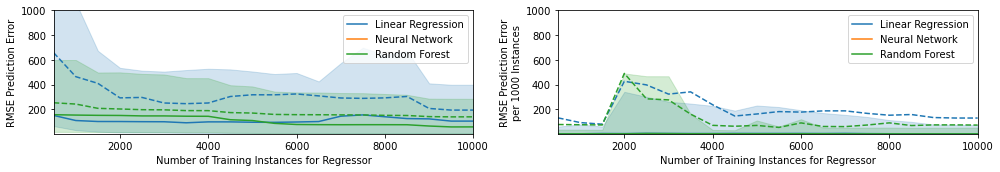

In [24]:
def plotLearningCurves(dfLearningCurveEntries):
    for algo, dfAlgo in dfLearningCurveEntries.groupby("algorithm"):
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        for i, t in enumerate(["fit", "app"]):
            
            for l, learner in enumerate(regressors):
                df = dfAlgo[(dfAlgo["target"] == t) & (dfAlgo["learner"] == learner)].sort_values("size")
                ax[i].set_title(algo)
                ax[i].plot(df["size"], df["rmse"], label=learner)
                ax[i].set_ylim([1, 10**3])
                ax[i].set_xlim([500, 10000])
                #ax[i].set_yscale("log")
                ax[i].legend()

def plotAggregatedLearningCurves(dfLearningCurveEntries):
    learnernames = {"forest": "Random Forest", "linear": "Linear Regression", "ann": "Neural Network"}
    fig, ax = plt.subplots(1, 2, figsize=(14, 2.5))
    for i, t in enumerate(["fit", "app"]):
        for l, learner in enumerate(regressors):
            dfCurve = dfLearningCurveEntries[(dfLearningCurveEntries["target"] == t) & (dfLearningCurveEntries["learner"] == learner)].sort_values("size")
            sizes = []
            means = []
            medians = []
            q25 = []
            q75 = []
            for size, group in dfCurve.groupby("size"):
                means.append(sp.stats.trim_mean(group["rmse"], 0.1))
                q25.append(np.quantile(group["rmse"], 0.25))
                medians.append(np.quantile(group["rmse"], 0.5))
                q75.append(np.quantile(group["rmse"], 0.75))
                sizes.append(size)
            
            means = np.array(means)
            medians = np.array(medians)
            q25 = np.array(q25)
            q75 = np.array(q75)
            
            ax[i].plot(sizes, medians, color="C" + str(l), label=learnernames[learner])
            ax[i].plot(sizes, means, color="C" + str(l), linestyle="--")
            #df = dfAlgo[(dfAlgo["target"] == t) & (dfAlgo["learner"] == learner)].sort_values("size")
            #ax[i].set_title(algo)
            #ax[i].plot(df["size"], df["rmse"], label=learner)
            ax[i].set_ylim([1, 10**3])
            ax[i].set_xlim([500, 10000])
            ax[i].fill_between(sizes, q75, q25, color="C" + str(l), alpha=0.2)
            ax[i].set_xlabel("Number of Training Instances for Regressor")
            ax[i].set_ylabel("RMSE Prediction Error" + ("" if i == 0 else "\nper 1000 Instances"))
            #ax[i].set_yscale("log")
            ax[i].legend()
    return fig
    
plotLC = plotAggregatedLearningCurves(pd.read_csv(FILENAME_LEARNINGCURVES, delimiter=";"))
plotLC.tight_layout()
plotLC.savefig("plots/learningcurves.pdf")

In [25]:
def getPredictionTable(parametrized = False, defaultobservations=False):
    if defaultobservations:
        FILENAME = FILENAME_PREDICTIONS_POSTERIOR
        parametrized = True
    elif parametrized:
        FILENAME = FILENAME_PREDICTIONS_PARAMETRIZED
    else:
        FILENAME = FILENAME_PREDICTIONS_DEFAULT
        
    dfResults = pd.read_csv(FILENAME, delimiter=";")
    for colname in ["features", "truth_fit", "predictions_fit", "truth_app", "predictions_app"]:
        col = dfResults[colname]
        dfResults[colname] = [eval(v.replace("nan", "0")) for v in col]
    return dfResults

# 3. Performance of Standard Models Using the RandomForest (Sec. 4.2)

## 3.1. RMSE of RF for leave-one-out

In [31]:
for algo in algorithms:
    updateValidationPredictions(algorithm=algo, defaultobservations=False, parametrized=True)

BAYESNET 1484 results are already in cache.



DECISIONTABLE 1409 results are already in cache.



IBK 1414 results are already in cache.



J48 1410 results are already in cache.



JRIP 1412 results are already in cache.



LMT 1409 results are already in cache.



LOGISTIC 1459 results are already in cache.



MULTILAYERPERCEPTRON 1410 results are already in cache.



NAIVEBAYES 1412 results are already in cache.



ONER 1411 results are already in cache.



PART 1410 results are already in cache.



REPTREE 1337 results are already in cache.



RANDOMFOREST 1410 results are already in cache.



RANDOMTREE 1410 results are already in cache.



SIMPLELOGISTIC 1412 results are already in cache.



SMO 1410 results are already in cache.



VOTEDPERCEPTRON 1004 results are already in cache.



BESTFIRST_CFSSUBSETEVAL 1365 results are already in cache.



GREEDYSTEPWISE_CFSSUBSETEVAL 1408 results are already in cache.



RANKER_CORRELATIONATTRIBUTEEVAL 1410 results are already in cache.



RANKER_GAINRATIOATTRIBUTEEVAL 1408 results are already in cache.



RANKER_INFOGAINATTRIBUTEEVAL 1411 results are already in cache.



RANKER_ONERATTRIBUTEEVAL 1412 results are already in cache.



RANKER_PRINCIPALCOMPONENTS 1384 results are already in cache.



RANKER_RELIEFFATTRIBUTEEVAL 1411 results are already in cache.



RANKER_SYMMETRICALUNCERTATTRIBUTEEVAL 1410 results are already in cache.


In [32]:
def getValidationTable(defaultobservations, parametrized):
    dfPredictions = getPredictionTable(defaultobservations=defaultobservations, parametrized=parametrized)
    return dfPredictions[["algorithm", "fitsize", "fitattributes", "truth_fit", "predictions_fit", "truth_app", "predictions_app"]].groupby(["algorithm", "fitsize", "fitattributes"]).agg(lambda g: [v for l in g.values for v in l])

In [33]:
dfValidationStandard = pd.concat([getValidationTable(defaultobservations=False, parametrized=True), getValidationTable(defaultobservations=False, parametrized=False).query("algorithm in ['decisionstump', 'kstar', 'naivebayesmultinomial',  'zeror']")])

## Detailed View On Erors per Validation Point

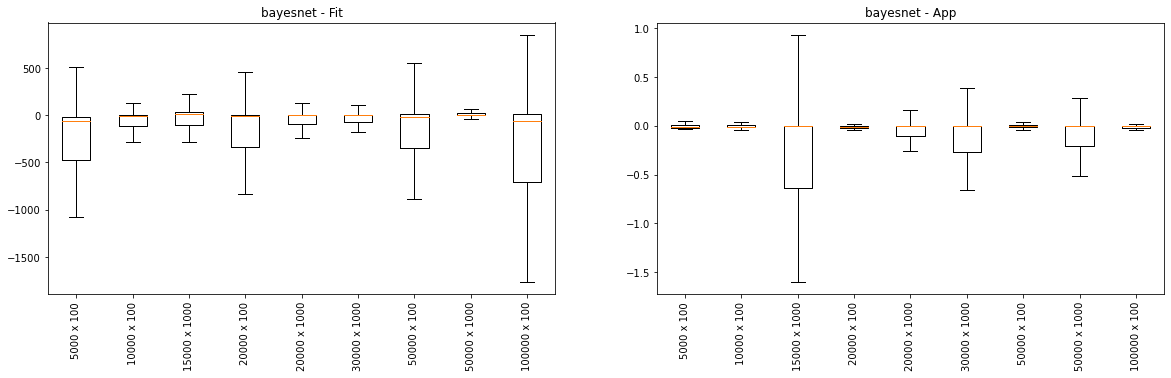

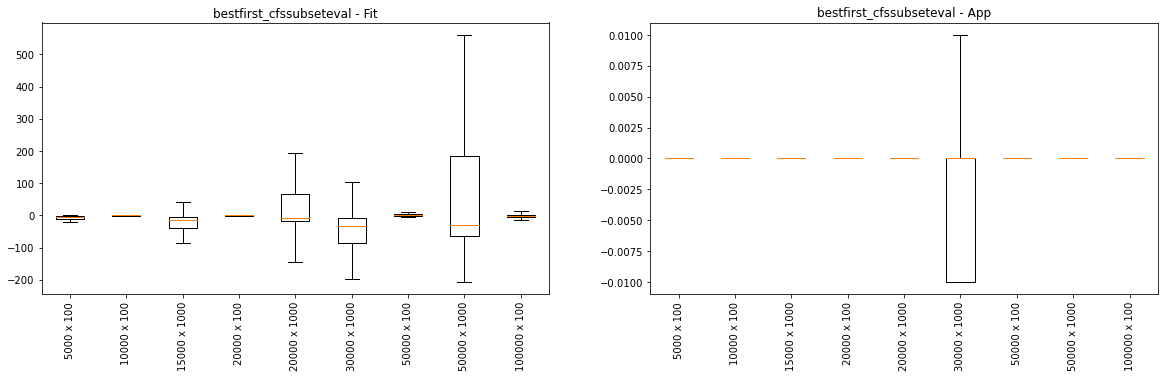

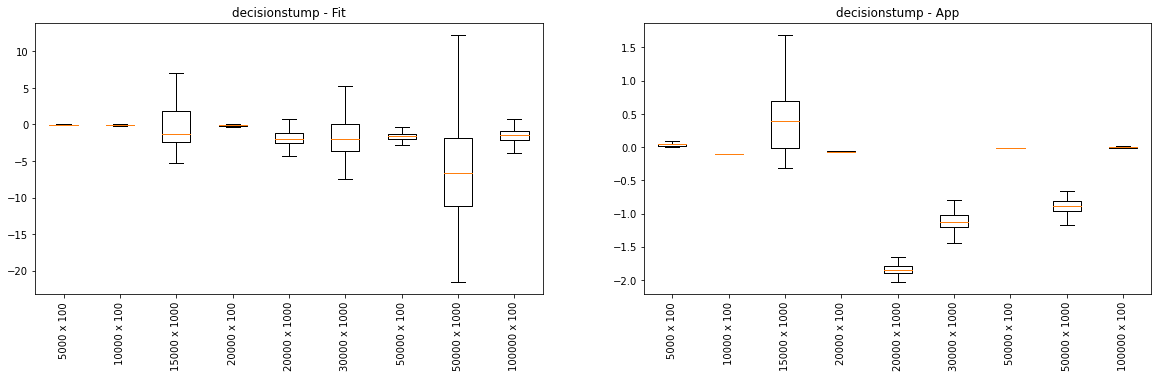

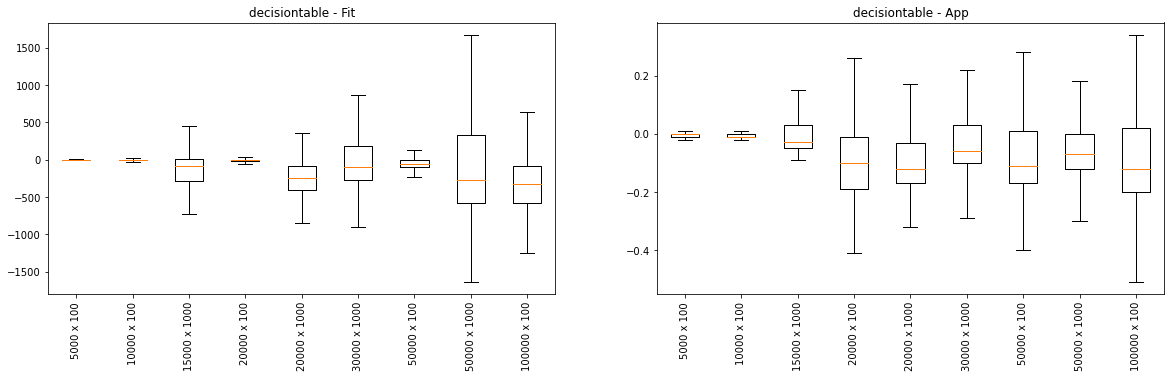

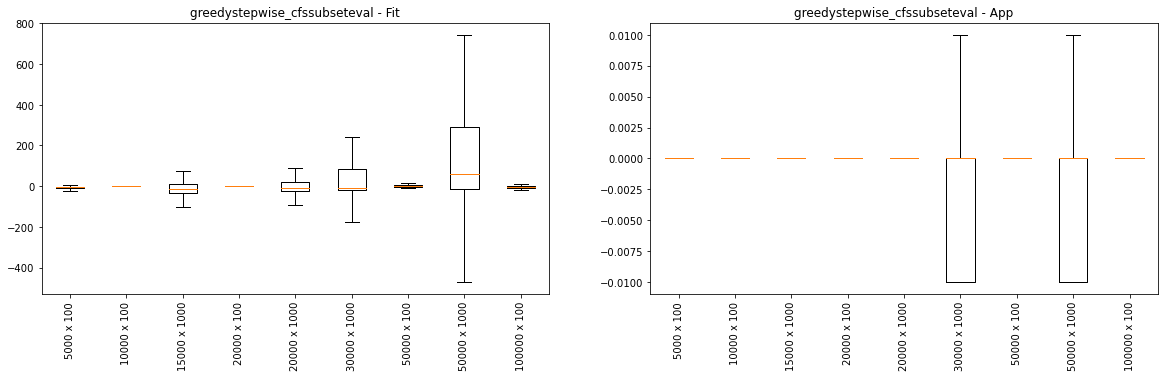

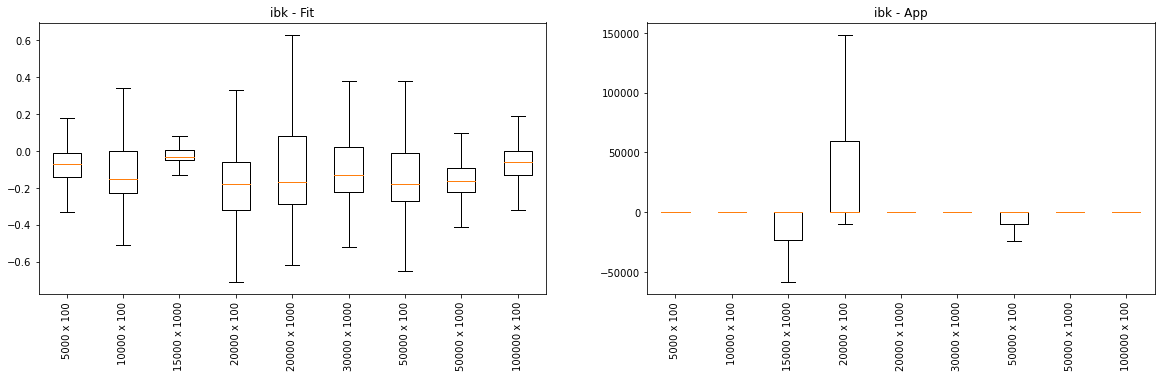

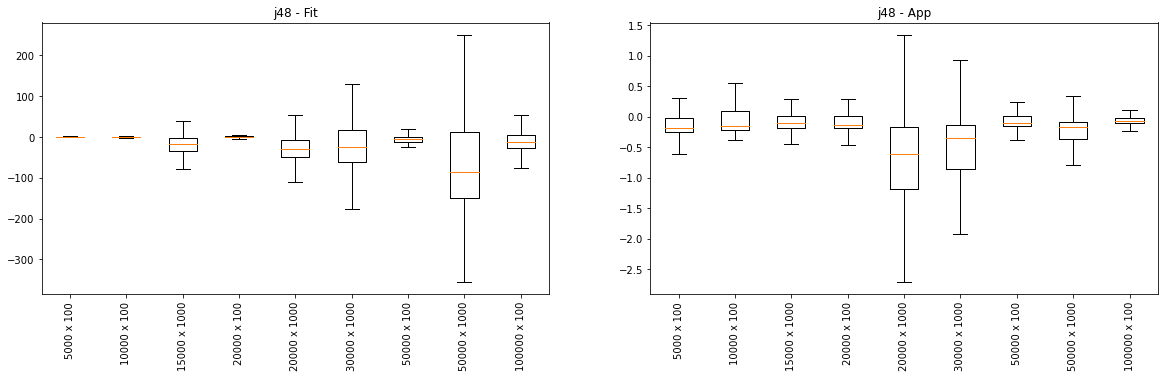

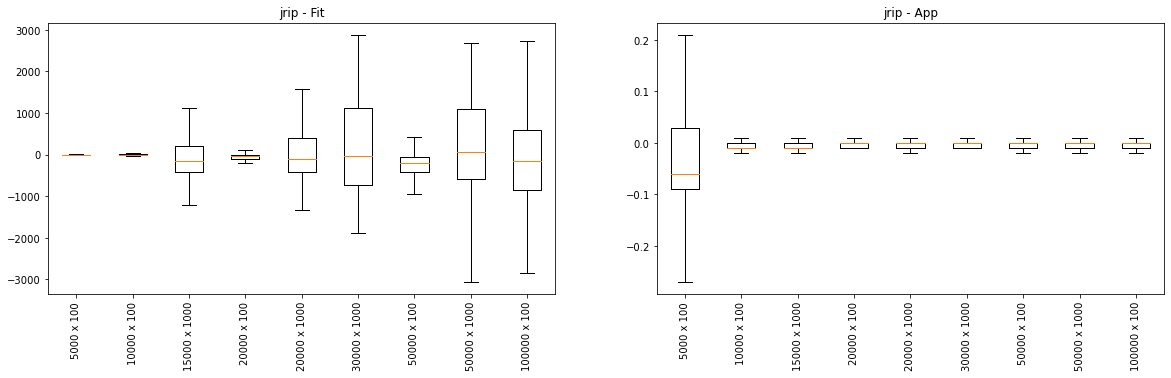

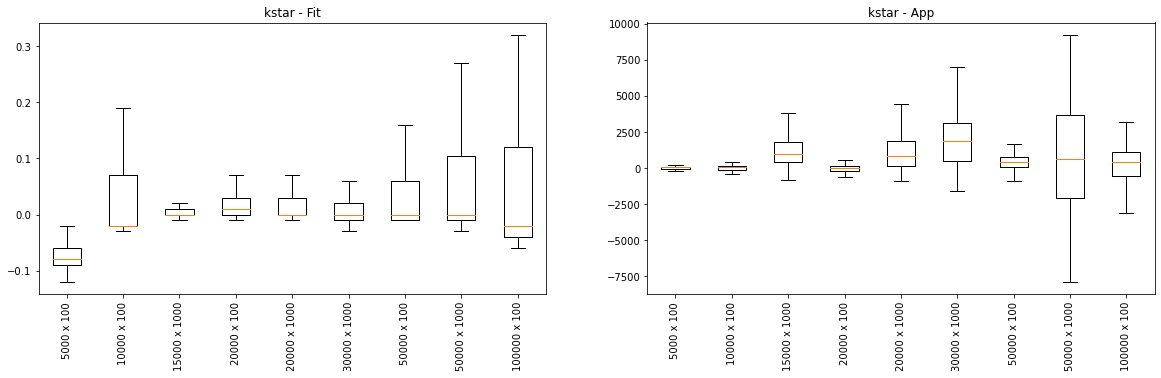

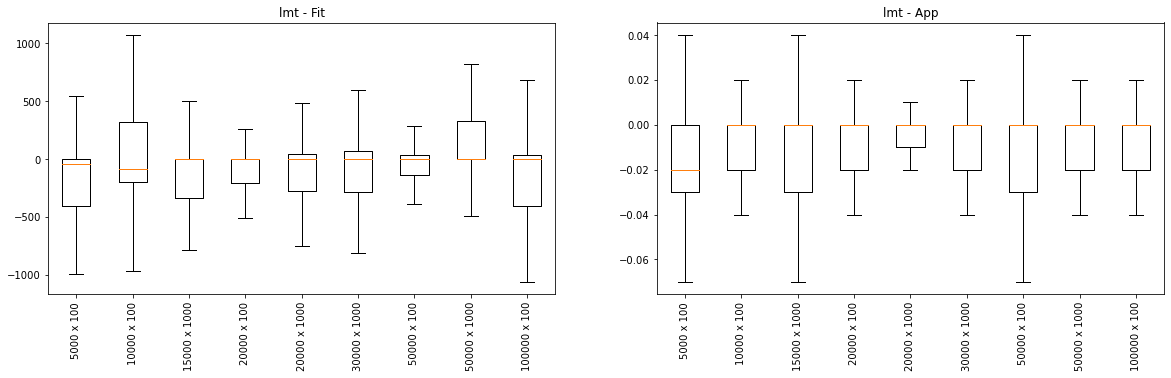

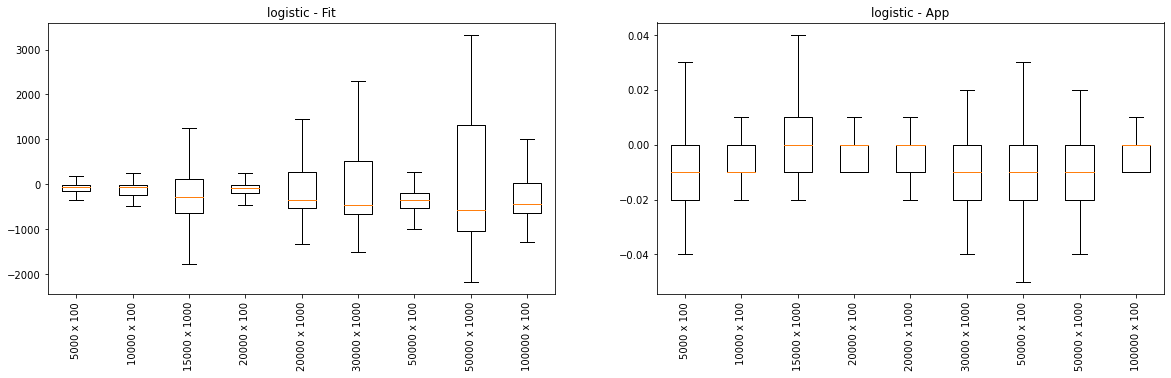

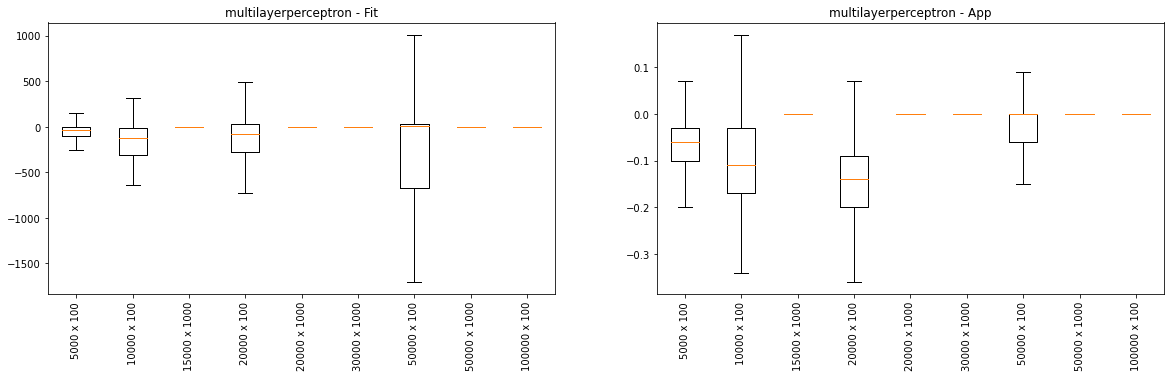

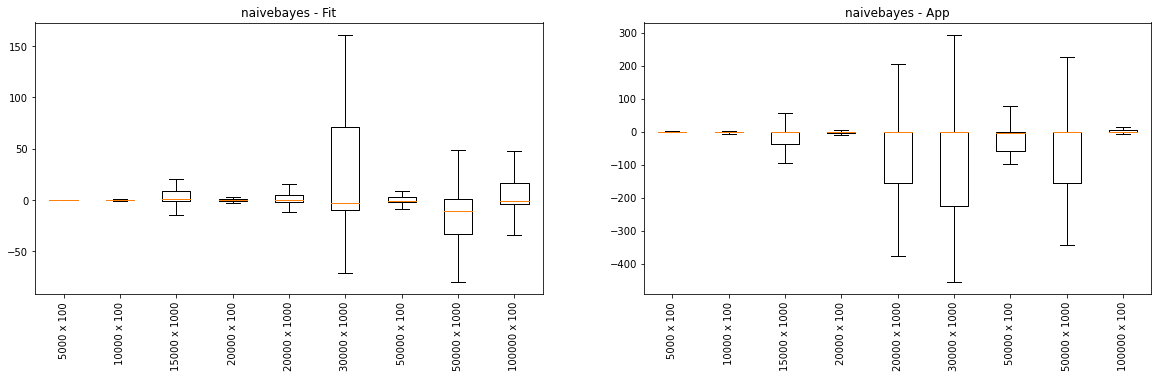

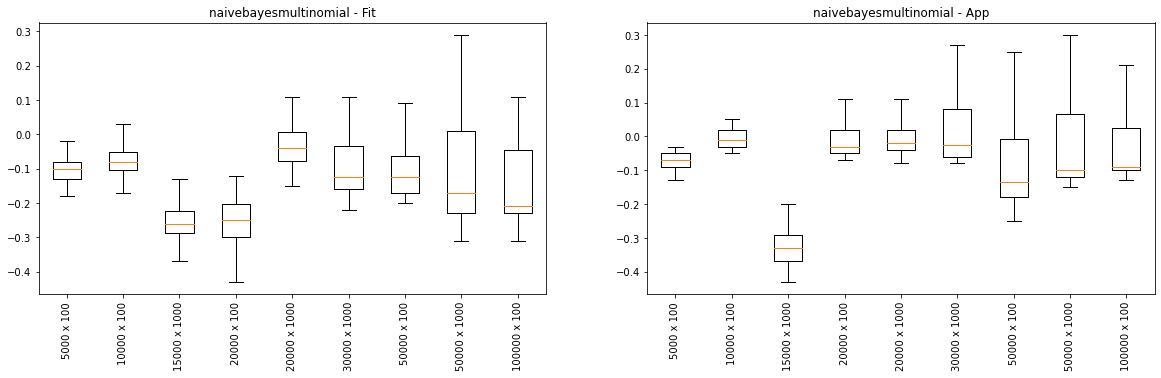

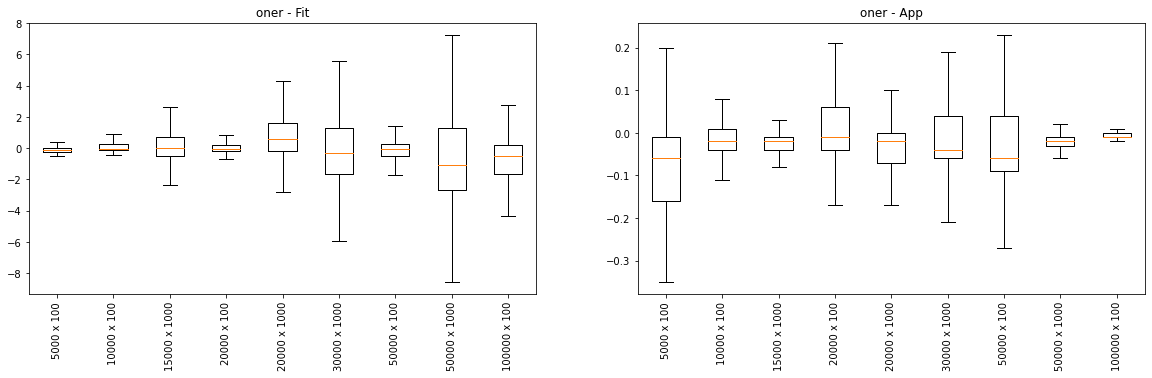

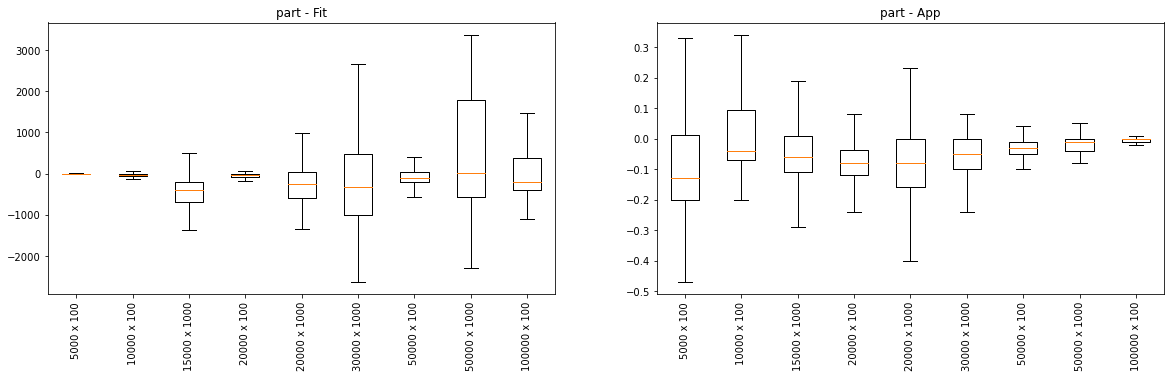

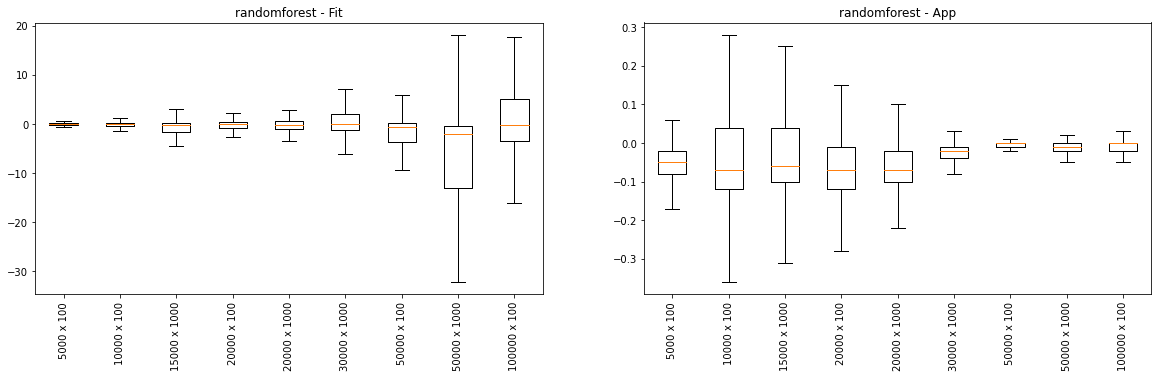

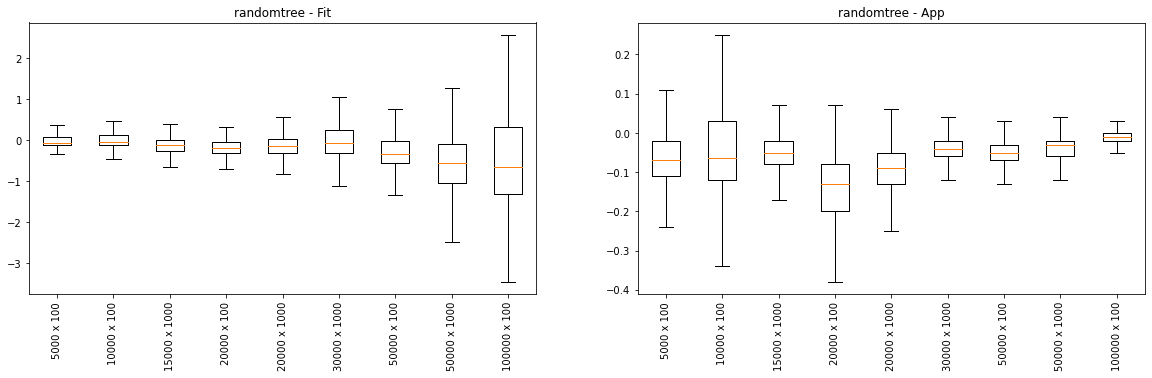

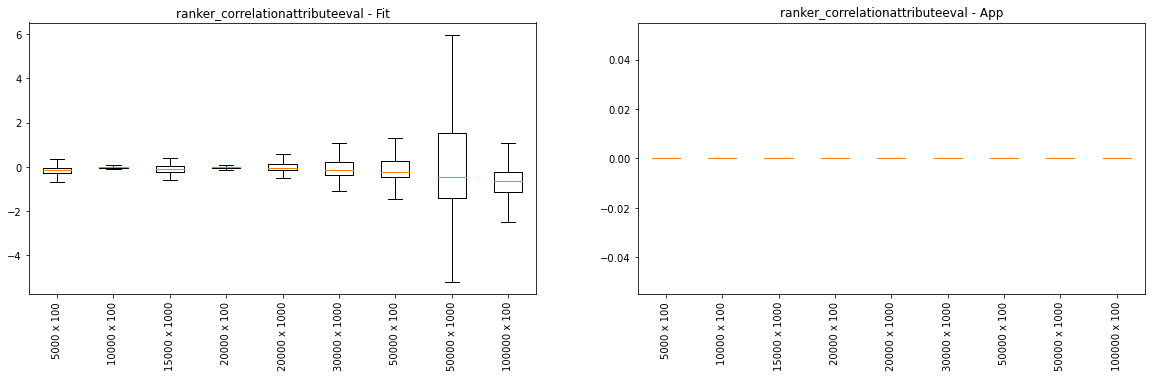

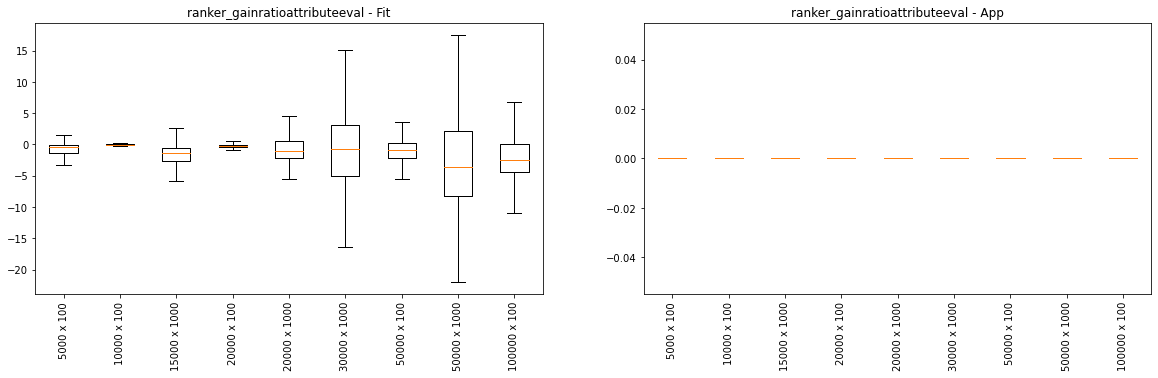

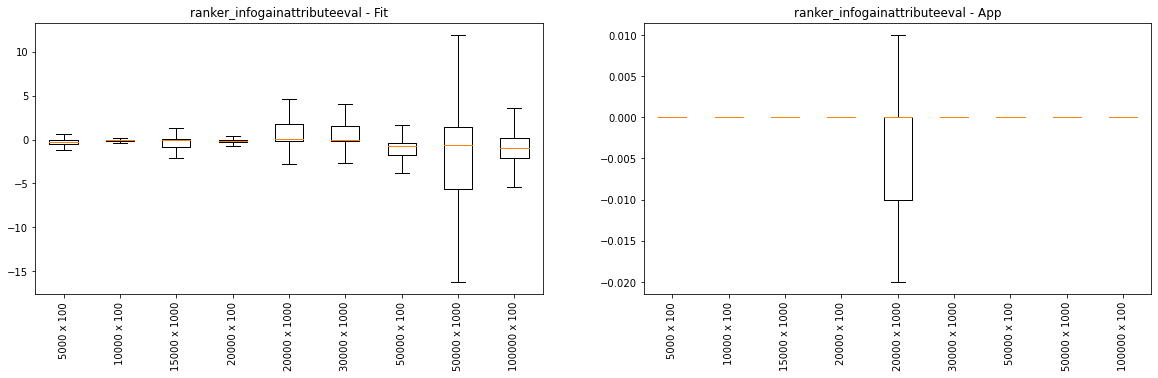

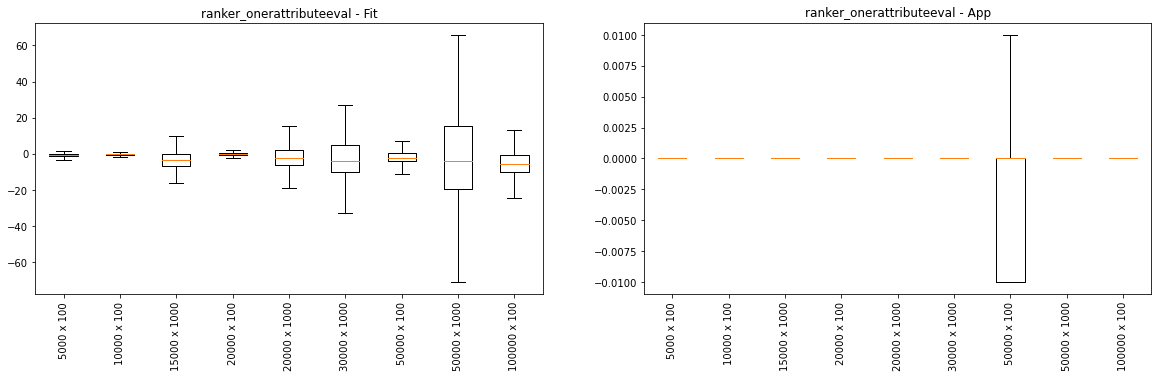

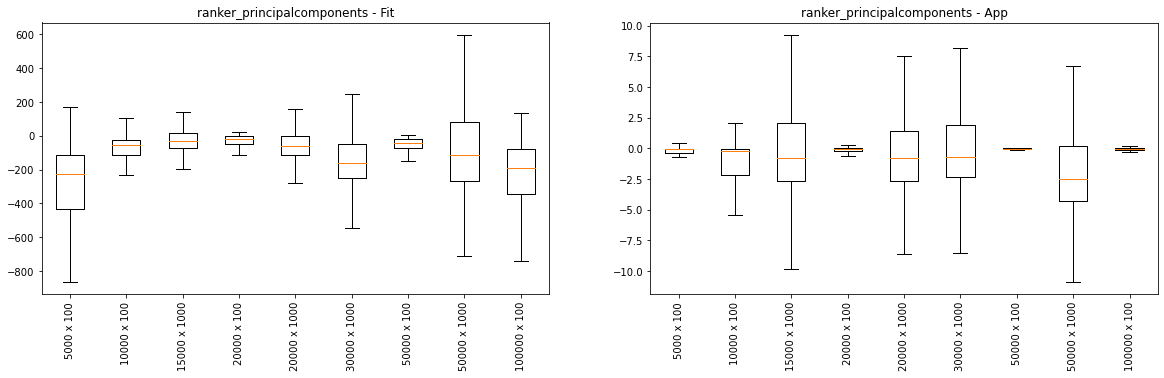

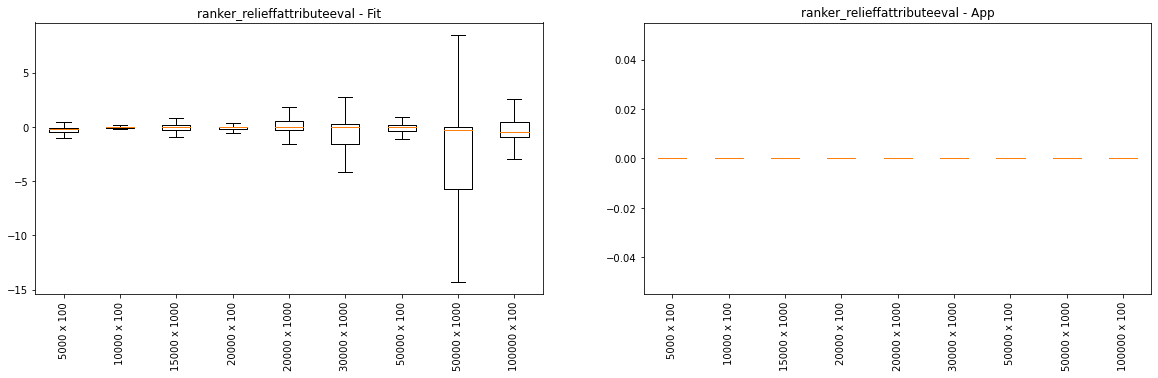

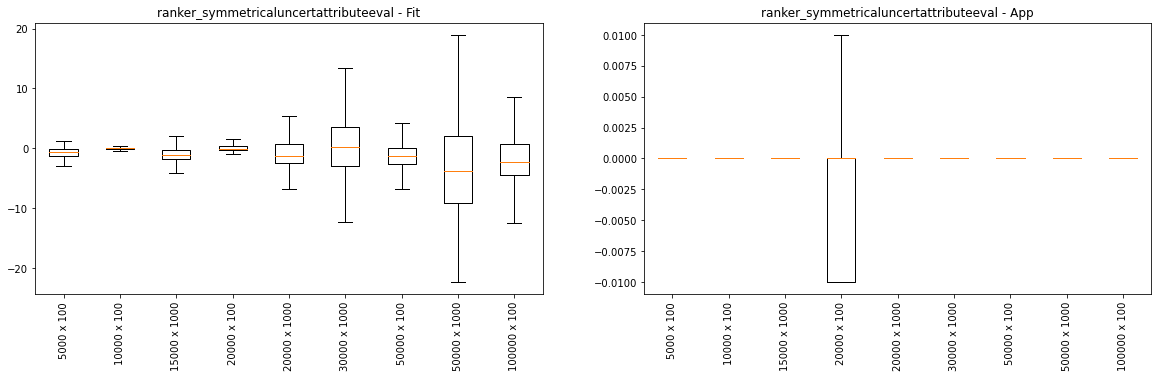

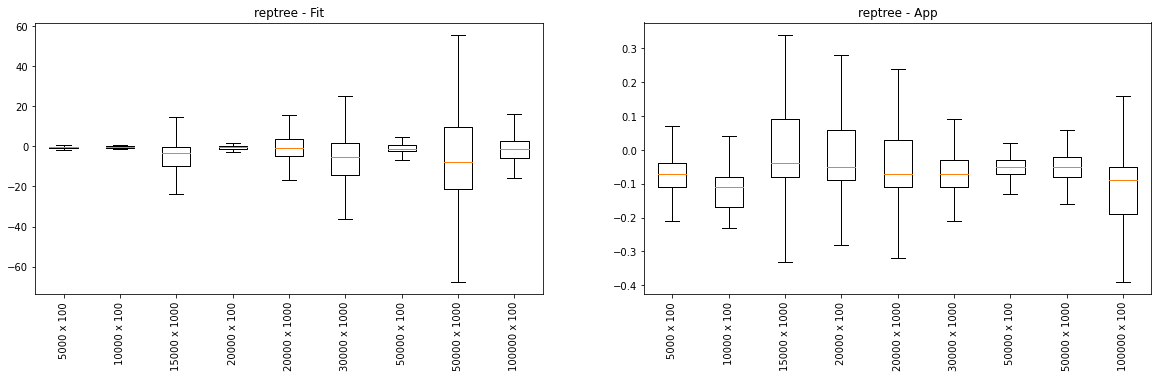

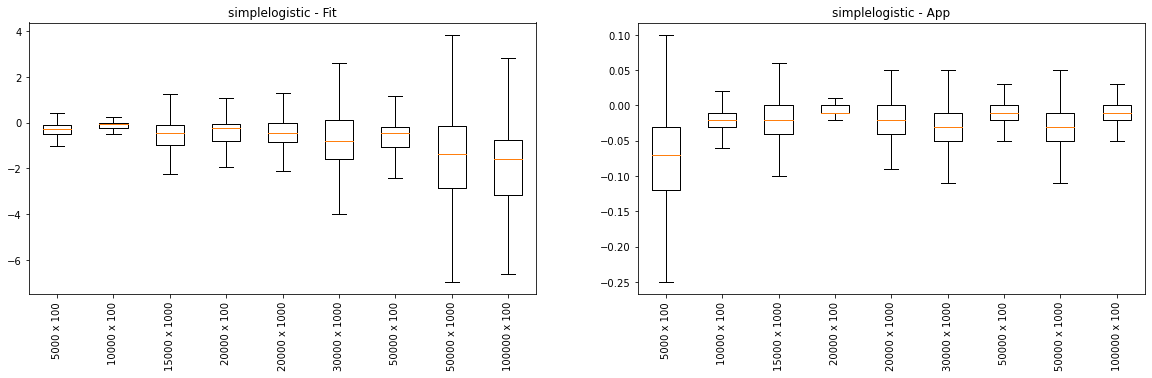

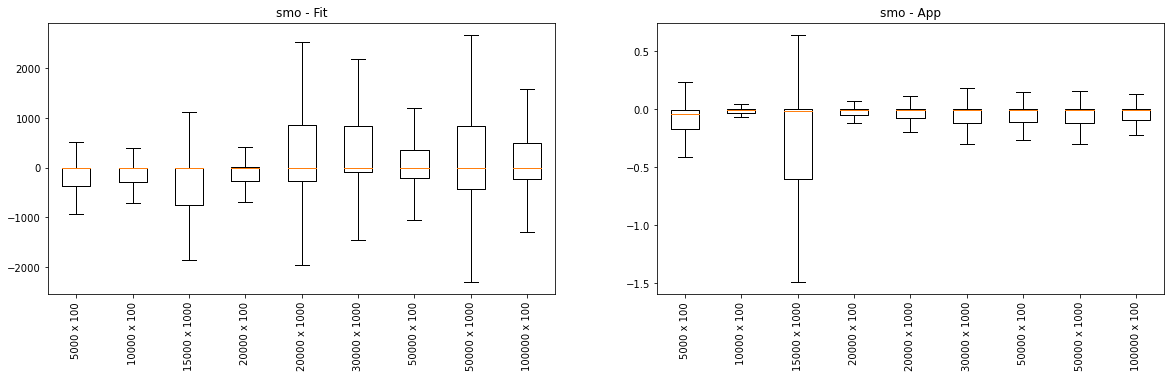

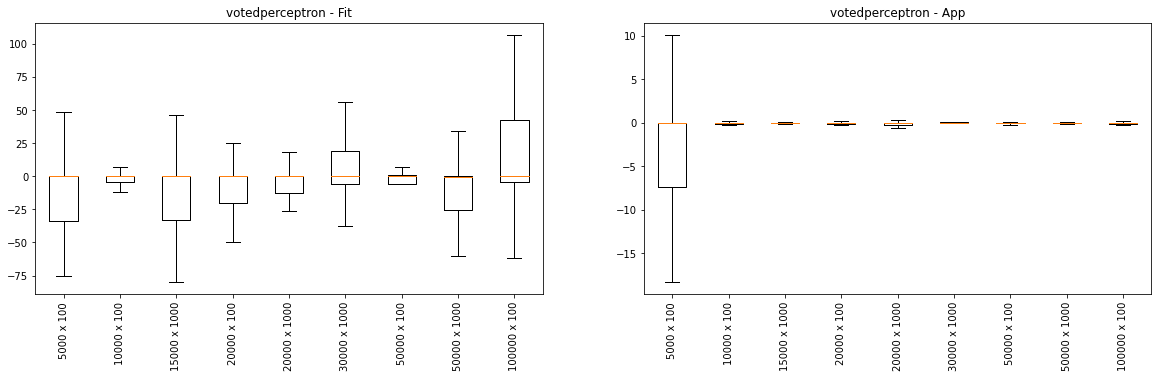

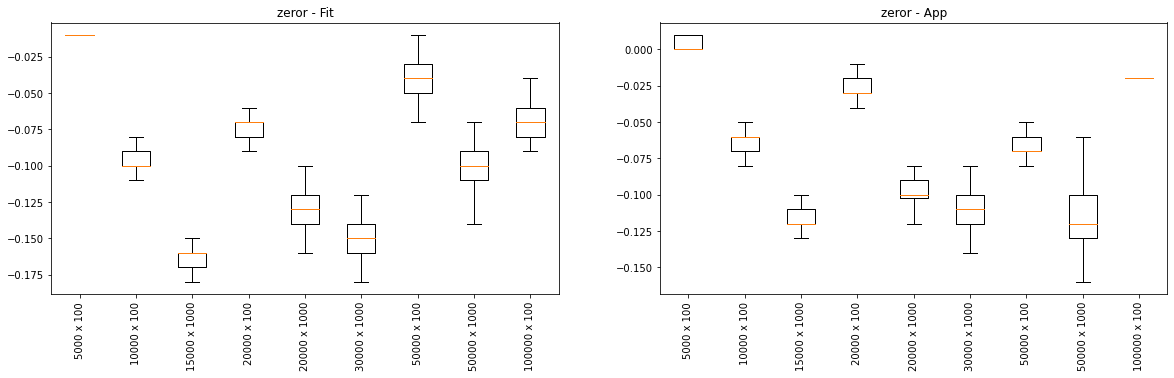

In [34]:
errorsFit = {}
errorsApp = {}
for i, row in dfValidationStandard.iterrows():
    algorithm = i[0]
    fitsize = i[1]
    fitattributes = i[2]
    
    if not algorithm in errorsFit:
        errorsFit[algorithm] = []
    if not algorithm in errorsApp:
        errorsApp[algorithm] = []
    
    for suffix in ["fit", "app"]:
        A = np.array(row["truth_" + suffix])
        F = np.array(row["predictions_" + suffix])
        
        if suffix == "fit":
            errorsFit[algorithm].append(A - F)
        if suffix == "app":
            errorsApp[algorithm].append(A - F)

algorithmsHere = sorted(np.unique([i[0] for i in dfValidationStandard.index]))
for algo in algorithmsHere:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].boxplot(errorsFit[algo], 0, '')
    ax[0].set_title(algo + " - Fit")
    ax[1].boxplot(errorsApp[algo], 0, '')
    ax[1].set_title(algo + " - App")
    for i in range(2):
        ax[i].set_xticklabels([str(i[1]) + " x " + str(i[2]) for i in dfValidationStandard.index], rotation=90)
    plt.show()

## Aggregated View On $50000 \times 1000$ validation point

In [35]:
def getPredictionPerformancePlot(df):
    
    bounds = [
        {
            "fit": [0, 300],
            "app": [0, 1]
        },
        {
            "fit": [300, 1200],
            "app": [1, 10]
        },
        {
            "fit": [1200, np.inf],
            "app": [10, np.inf]
        } 
    ]
    
    fig, ax = plt.subplots(3,2,figsize=(15,5.5), sharex=True)
    for tIndex, target in enumerate(["fit", "app"]):
        column = target + "_Absolute Error"
        
        for fold in range(3):
            
            # compute lower and upper bounds on true runtime
            lb, ub = bounds[fold][target]

            # Gather errors per algorithm at the relevant points
            M = []
            for algorithm in preprocessors + classifiers:
                #print(target, algorithm, lb, ub)
                dfAlgo = df.query("algorithm == '" + algorithm + "'")
                if len(dfAlgo) > 0:
                    A = np.array([v for v in dfAlgo["truth_" + target]])[0]
                    F = np.array([v for v in dfAlgo["predictions_" + target]])[0]
                    A = np.maximum(A, 0.00001)
                    F = np.maximum(F, 0.00001)
                else:
                    A = F = np.array([])

                # split observations into three folds, depending on true runtime
                relevantIndices = np.where((A >= lb) & (A <= ub))
                A = A[relevantIndices]
                F = F[relevantIndices]
                
                #if len(A) > 0:
                 #   print("obs", len(A), len(F))
                

                a = ax[fold][tIndex]
                M.append(A - F)

            # create boxplot and set title and labels
            targetname = {"fit": "Differences (s) Between True and Predicted Train Time", "app": "Differences (s) Between True and Predicted Prediction Time (per 1000 inst.)"}
            if fold == 0:
                a.set_title(targetname[target])
            if target == "fit":
                a.set_ylabel("True Runtime\n" + ("Between " + str(int(lb / 60)) + " and " + str(int(ub / 60)) if ub < np.inf else "at least " + str(int(lb/60))) + "m")
            else:
                a.set_ylabel("True Runtime\n" + ("Between " + str(lb) + " and " + str(ub) if ub < np.inf else "at least " + str(lb)) + "s")
                
            a.boxplot(M, 0, '')
            a.set_xticklabels([algorithmshortcuts[a] for a in preprocessors + classifiers], rotation=90)

            # add auxilliary lines
            a.axvline(len(preprocessors) + 0.5, color="black", linestyle="dotted", linewidth=1)
            margin = 2
            if target == "fit":
                bub = min(1800, ub)
                thresholds = [(bub * 0.05, "green"), (bub * 0.25, "yellow"), (bub * 0.5, "orange")]
                a.set_ylim([-margin * bub, margin * bub])
            else:
                bub = min(15, ub)
                thresholds = [(bub * 0.05, "green"), (bub * 0.25, "yellow"), (bub * 0.5, "orange")]
                a.set_ylim([-margin * bub, margin * bub])
            for i, (threshold, color) in enumerate(thresholds):
                lastThreshold = thresholds[i-1][0] if i >= 1 else 0
                a.fill_between([0, len(algorithms)], [-1 * lastThreshold, -1 * lastThreshold], [-1 * threshold, -1 * threshold], color=color, alpha=0.2)
                a.fill_between([0, len(algorithms)], [lastThreshold, lastThreshold], [threshold, threshold], color=color, alpha=0.2)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0)
    return fig

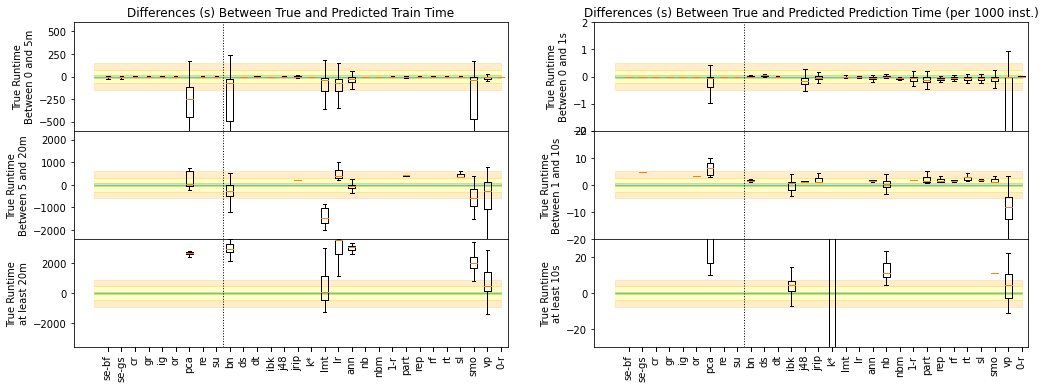

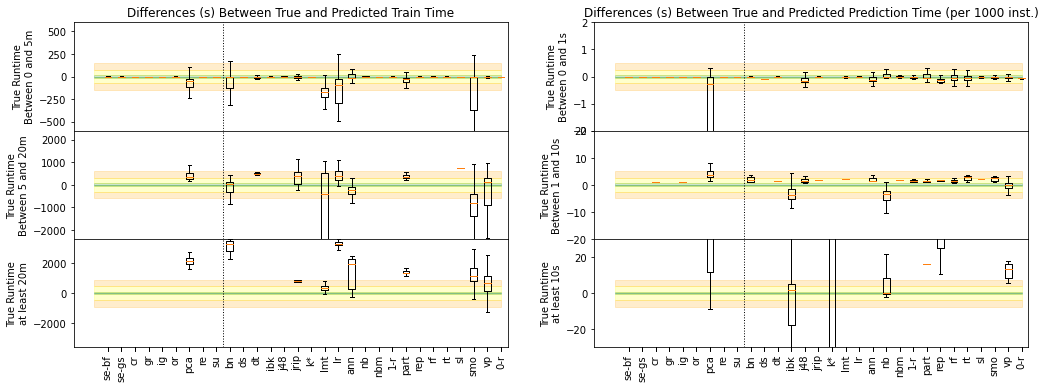

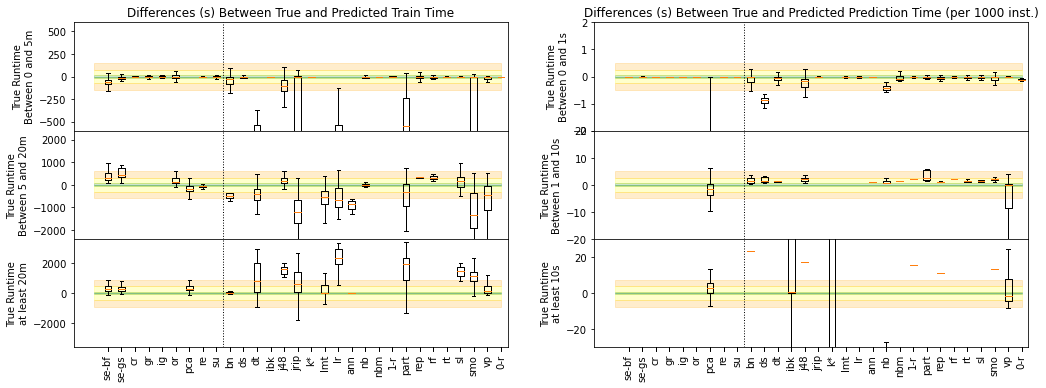

In [36]:
for pltcombo in [(5000, 100), (10000, 100), (50000, 1000)]:
    fig = getPredictionPerformancePlot(dfValidationStandard.query("fitsize == " + str(pltcombo[0]) + " and fitattributes == " + str(pltcombo[1])))
    fig.savefig("plots/predictionresults-parametrized-" + str(pltcombo[0]) + "x" + str(pltcombo[1]) + ".pdf")
    plt.show()

# 4. Critical over- and understimations of the predictor
Idea:
* Even large absolute prediction failures are **ok** if both prediction and true runtime are substantially beyond the timeout.
* Prediction failures are a **problem** if the timeout is between prediction and true timeout

We should check the timeout is between prediction and truth when
* the absolute error is large
* the absolute error is small 

## 4.1 Create plots for the Paper

## Compute True/False Positives/Negatives of Decisions per Algorithm/Timeout combination

In [37]:
timeouts = [0.5, 1, 5, 10, 15, 20, 30, 60]
def getConfusionMatrixForPredictions(dfPredictions, algorithms, timeouts):
    TP = np.zeros((len(timeouts), len(algorithms)))
    FP = np.zeros((len(timeouts), len(algorithms)))
    TN = np.zeros((len(timeouts), len(algorithms)))
    FN = np.zeros((len(timeouts), len(algorithms)))
    decisionsPos = np.zeros((len(timeouts), len(algorithms)))
    decisionsNeg = np.zeros((len(timeouts), len(algorithms)))

    cautionFactor = 1

    for j, a in enumerate(tqdm(algorithms)):

        dfAlgo = dfPredictions.query("algorithm == '" + a + "'")

        print(a)

        # compute prediction stats for different timeouts
        for i, to in enumerate(timeouts):

            # gahter actual and forecast vectors
            A = []
            F = []

            validationScenarioIndex = min(len(validationCombos) - 1, i)
            fitsize = validationCombos[validationScenarioIndex][0]
            fitattributes = validationCombos[validationScenarioIndex][1]
            match = (dfAlgo["fitsize"] == fitsize) & (dfAlgo["fitattributes"] == fitattributes)

            for _, row in dfAlgo[match].iterrows():
                A.extend(list(np.array(row["truth_fit"]) + np.array(row["truth_app"])))
                F.extend(list(np.array(row["predictions_fit"]) + np.array(row["predictions_app"])))

            if len(A) > 0:
                A = np.array(A)
                F = np.array(F)

                toInSeconds = 60 * np.array(to)
                trueTimeouts = A > toInSeconds
                predTimeouts = F * cautionFactor > toInSeconds
                for k in range(len(trueTimeouts)):
                    if predTimeouts[k]:
                        decisionsPos[i,j] += 1
                        correct = trueTimeouts[k]
                        #print("Predicting timeout " + ("correctly" if correct else "incorrectly") + " for to " + str(to) + " (" + str(F[k]) + "/" + str(A[k]) + ")")
                        if correct:
                            TP[i,j] += 1
                        else:
                            FP[i,j] += 1
                    else:
                        decisionsNeg[i,j] += 1
                        correct = not trueTimeouts[k]
                        if correct:
                            TN[i,j] += 1
                        else:
                            FN[i,j] += 1
            else:
                decisionsPos[i,j] = np.nan
                TP[i,j] = np.nan
                FP[i,j] = np.nan
                TN[i,j] = np.nan
                FN[i,j] = np.nan
    return TP, FP, TN, FN, decisionsPos, decisionsNeg

algorithms2 = preprocessors + classifiers
TP, FP, TN, FN, decisionsPos, decisionsNeg = getConfusionMatrixForPredictions(pd.concat([getPredictionTable(parametrized=True, defaultobservations=False), getPredictionTable(parametrized=False, defaultobservations=False).query("algorithm in ['decisionstump', 'kstar', 'naivebayesmultinomial', 'zeror']")]), algorithms2, timeouts)

bestfirst_cfssubseteval
greedystepwise_cfssubseteval
ranker_correlationattributeeval
ranker_gainratioattributeeval
ranker_infogainattributeeval
ranker_onerattributeeval
ranker_principalcomponents
ranker_relieffattributeeval
ranker_symmetricaluncertattributeeval
bayesnet
decisionstump
decisiontable
ibk
j48
jrip
kstar
lmt
logistic
multilayerperceptron
naivebayes
naivebayesmultinomial
oner
part
reptree
randomforest
randomtree
simplelogistic
smo
votedperceptron
zeror



### Number of Decisions

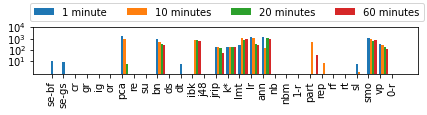

In [38]:
selectedTimeouts = [timeouts[i] for i in [1, 3, 5, 7]]
fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
a = ax
ind = np.arange(len(algorithms2)) * 2
width = 0.4
for i in range(len(decisionsPos[[1, 3, 5, 7], :])):
    a.bar(ind + width * i, decisionsPos[i], width=width, label=str(selectedTimeouts[i]) + " minute" + ("s" if selectedTimeouts[i] > 1 else ""))
#a.legend()
a.set_yscale("log")
a.set_yticks([10, 100, 1000, 10000])
a.set_xticks(np.arange(len(algorithms2)) * 2)
a.set_xticklabels([algorithmshortcuts[a] for a in algorithms2], rotation=90)
#a.invert_yaxis()
handles, labels = a.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.525, 1.08),ncol=4)
fig.tight_layout()
fig.savefig("plots/atomicalgorithmclassifications-quantity.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

### Goodness of the Decisions

In [39]:
def getDecisionPlots(dfPredictions, algorithms, timeouts):
    TP, FP, TN, FN, decisionsPos, decisionsNeg = getConfusionMatrixForPredictions(dfPredictions, algorithms, timeouts)

    fig, ax = plt.subplots(4, 1, figsize=(6, 4), sharex=True)
    fig.subplots_adjust(hspace=0.1)
    #for j, target in enumerate(["fittime", "applicationtime"]):
    for i, metric in enumerate(["tp", "fp", "tn", "fn"]):
        a = ax[i]
        if metric == "tp":
            M = TP
        if metric == "fp":
            M = FP
        if metric == "tn":
            M = TN
        if metric == "fn":
            M = FN
        cmap = "Reds" if "f" in metric else "Greens"
        MS = M / (decisionsPos if "p" in metric else decisionsNeg)
        a.imshow(MS, cmap=cmap, aspect="auto", vmax=1)
        a.set_yticks(range(0, len(timeouts), 2))
        a.set_yticklabels([t for i, t in enumerate(timeouts) if i %2 == 1])
        #if i == 3:
        a.set_xticks(range(len(algorithms2)))
        a.set_xticklabels([algorithmshortcuts[a] for a in algorithms2], rotation=90)
        #else:
        #    a.set_xticklabels([])
        #    a.set_xticks([])
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.2)
    return fig

bestfirst_cfssubseteval
greedystepwise_cfssubseteval
ranker_correlationattributeeval
ranker_gainratioattributeeval
ranker_infogainattributeeval
ranker_onerattributeeval
ranker_principalcomponents
ranker_relieffattributeeval
ranker_symmetricaluncertattributeeval
bayesnet
decisionstump
decisiontable
ibk
j48
jrip
kstar
lmt
logistic
multilayerperceptron
naivebayes
naivebayesmultinomial
oner
part
reptree
randomforest
randomtree
simplelogistic
smo
votedperceptron
zeror



/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


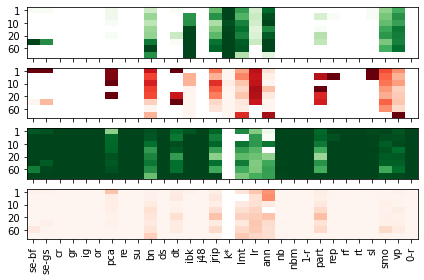

In [40]:
fig = getDecisionPlots(pd.concat([getPredictionTable(parametrized=True, defaultobservations=False), getPredictionTable(parametrized=False, defaultobservations=False).query("algorithm in ['decisionstump', 'kstar', 'naivebayesmultinomial', 'zeror']")]), preprocessors + classifiers, timeouts)
fig.savefig("plots/atomicalgorithmclassifications-goodness.pdf")

# 5. Generalization Performance of the Special Models

## 5.1. Default-Parameter Models

In [41]:
FILENAME_PREDICTIONS_DEFAULT = "data/workdata/newpredictions-default.csv"
FILENAME_PREDICTIONS_PARAMETRIZED = "data/workdata/newpredictions-parametried.csv"
FILENAME_PREDICTIONS_POSTERIOR = "data/workdata/newpredictions-posterior.csv"

In [42]:
for algo in classifiers:
    updateValidationPredictions(algorithm=algo, defaultobservations=False, parametrized=False)

BAYESNET 692 results are already in cache.



DECISIONSTUMP 1458 results are already in cache.



DECISIONTABLE 1447 results are already in cache.



IBK 1428 results are already in cache.



J48 1410 results are already in cache.



JRIP 1410 results are already in cache.



KSTAR 1406 results are already in cache.



LMT 1403 results are already in cache.



LOGISTIC 1445 results are already in cache.



MULTILAYERPERCEPTRON 1523 results are already in cache.



NAIVEBAYES 1410 results are already in cache.



NAIVEBAYESMULTINOMIAL 619 results are already in cache.



ONER 1410 results are already in cache.



PART 1410 results are already in cache.



REPTREE 1411 results are already in cache.



RANDOMFOREST 1412 results are already in cache.



RANDOMTREE 1410 results are already in cache.



SIMPLELOGISTIC 1412 results are already in cache.



SMO 1435 results are already in cache.



VOTEDPERCEPTRON 1003 results are already in cache.



ZEROR 1411 results are already in cache.


In [43]:
dfValidationDefault = getValidationTable(defaultobservations=False, parametrized=False)

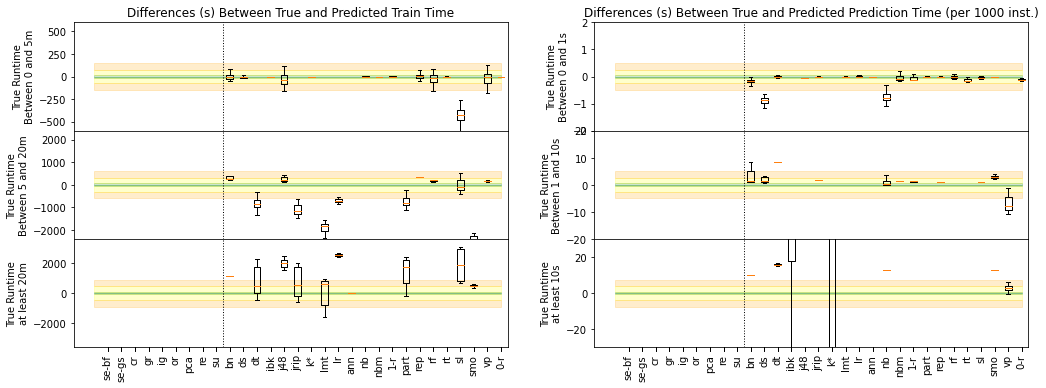

In [44]:
fig = getPredictionPerformancePlot(dfValidationDefault.query("fitsize == 50000 and fitattributes == 1000"))

## 5.2. Performance of Posterior Models (Using true Default-Runtimes)

In [45]:
for algo in classifiers:
    updateValidationPredictions(algorithm=algo, defaultobservations=True, parametrized=True)

BAYESNET 653 results are already in cache.



DECISIONTABLE 1408 results are already in cache.



IBK 1405 results are already in cache.



J48 1410 results are already in cache.



JRIP 1410 results are already in cache.



LMT 1389 results are already in cache.



LOGISTIC 1438 results are already in cache.



MULTILAYERPERCEPTRON 1410 results are already in cache.



NAIVEBAYES 930 results are already in cache.



ONER 1410 results are already in cache.



PART 1410 results are already in cache.



REPTREE 1127 results are already in cache.



RANDOMFOREST 1410 results are already in cache.



RANDOMTREE 1410 results are already in cache.



SIMPLELOGISTIC 1410 results are already in cache.



SMO 1410 results are already in cache.



VOTEDPERCEPTRON 1003 results are already in cache.


In [46]:
dfValidationPosterior = getValidationTable(defaultobservations=True, parametrized=True)

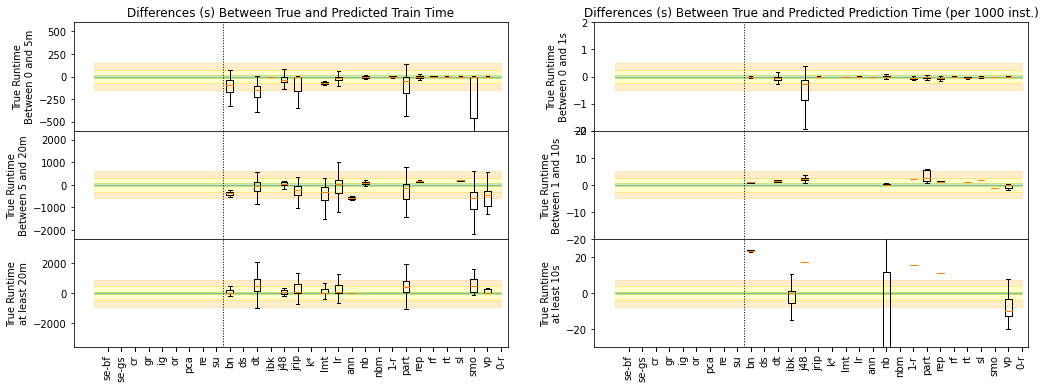

In [47]:
fig = getPredictionPerformancePlot(dfValidationPosterior.query("fitsize == 50000 and fitattributes == 1000"))
fig.savefig("plots/predictionresults-posterior-50000x1000.pdf")

In [48]:
print(preprocessors)

['bestfirst_cfssubseteval', 'greedystepwise_cfssubseteval', 'ranker_correlationattributeeval', 'ranker_gainratioattributeeval', 'ranker_infogainattributeeval', 'ranker_onerattributeeval', 'ranker_principalcomponents', 'ranker_relieffattributeeval', 'ranker_symmetricaluncertattributeeval']


bestfirst_cfssubseteval
greedystepwise_cfssubseteval
ranker_correlationattributeeval
ranker_gainratioattributeeval
ranker_infogainattributeeval
ranker_onerattributeeval
ranker_principalcomponents
ranker_relieffattributeeval
ranker_symmetricaluncertattributeeval
bayesnet
decisionstump
decisiontable
ibk
j48
jrip
kstar
lmt
logistic
multilayerperceptron
naivebayes
naivebayesmultinomial
oner
part
reptree
randomforest
randomtree
simplelogistic
smo
votedperceptron
zeror



/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


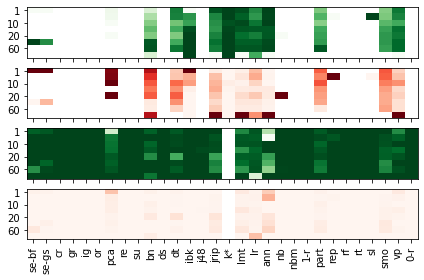

In [49]:
fig = getDecisionPlots(pd.concat([getPredictionTable(parametrized=True, defaultobservations=True), getPredictionTable(parametrized=False, defaultobservations=False).query("algorithm in ['decisionstump', 'kstar', 'naivebayesmultinomial', 'zeror']"), getPredictionTable(parametrized=True, defaultobservations=False).query("algorithm in ['bestfirst_cfssubseteval', 'greedystepwise_cfssubseteval', 'ranker_correlationattributeeval', 'ranker_gainratioattributeeval', 'ranker_infogainattributeeval', 'ranker_onerattributeeval', 'ranker_principalcomponents', 'ranker_relieffattributeeval', 'ranker_symmetricaluncertattributeeval']")]), preprocessors + classifiers, timeouts)
fig.savefig("plots/atomicalgorithmclassifications-goodness-posterior.pdf")

## 5.3. Create Comparison Plots

In [50]:
def getComparisonFrame():
    dfValidationMap = {
        "standard": getValidationTable(defaultobservations=False, parametrized=True),
        "default": getValidationTable(defaultobservations=False, parametrized=False),
        "posterior": getValidationTable(defaultobservations=True, parametrized=True)
    }

    rows = []
    for i, algo in enumerate(tqdm([a for a in parametrizablealgorithms if a in classifiers])):
        
        # gather A and F vectors for algorithm in different setups
        A = {"fit": {}, "app": {}}
        F = {"fit": {}, "app": {}}
        for t in dfValidationMap:
            dfAlgo = dfValidationMap[t].query("algorithm == '" + algo + "' and fitsize == 50000 and fitattributes == 1000")
            if len(dfAlgo) > 0:
                for target in ["fit", "app"]:
                    A[target][t] = dfAlgo["truth_" + target].values[0]
                    F[target][t] = dfAlgo["predictions_" + target].values[0]
        
        # compute metrics
        row = [algo]
        for target in ["fit", "app"]:
            A_standard = A[target]["standard"]
            F_standard = F[target]["standard"]
            rmse_standard = RMSE(A_standard, F_standard)
            mape_standard = MAPE(A_standard, F_standard)
            for t in dfValidationMap:
                if t != "standard":
                    A_comp = A[target][t]
                    F_comp = F[target][t]
                    
                    # compute improvements
                    imp_rmse = rmse_standard - RMSE(A_comp, F_comp)
                    imp_mape = mape_standard - MAPE(A_comp, F_comp)
                    row.extend([imp_rmse, imp_mape])
        rows.append(row)
        
    return pd.DataFrame(rows, columns=["algorithm", "imp_default_rmse_fit", "imp_default_mape_fit", "imp_posterior_rmse_fit", "imp_posterior_mape_fit", "imp_default_rmse_app", "imp_default_mape_app", "imp_posterior_rmse_app", "imp_posterior_mape_app"])

dfComparison = getComparisonFrame()

/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: invalid value encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: invalid value encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: invalid value encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: invalid value encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: invalid value encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: Runt

/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[i])
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/home/felix/devel/pipelineruntimprediction/python/libruntimepredictionanalysis.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  s += np.abs((A[i] - F[i]) / A[

In [51]:
dfComparison

algorithm  imp_default_rmse_fit  imp_default_mape_fit  \
0               bayesnet            557.916429             -0.138254   
1          decisiontable             65.129102             -0.321430   
2                    ibk             -1.621358                   inf   
3                    j48            -26.321125              0.405310   
4                   jrip             24.325019              0.021561   
5                    lmt           -249.680009             -0.249356   
6               logistic             85.183281             -2.156247   
7   multilayerperceptron            538.429571              0.122205   
8             naivebayes            115.612178              0.892953   
9                   oner             -0.230907              0.013917   
10                  part            125.054444             -1.144712   
11               reptree             14.890196              0.093614   
12          randomforest            -36.041990              0.532638   
13            randomtree             -0.740551              0.250279   
14        simplelogistic           -802.926088             -0.411684   
15                   smo             -4.895116             45.613138   
16       votedperceptron            528.413367              5.806880   

    imp_posterior_rmse_fit  imp_posterior_mape_fit  imp_default_rmse_app  \
0               331.919093               -0.231425              0.267315   
1               452.695631                0.392856             -0.453470   
2                 0.004868                     NaN          -2543.106132   
3               136.549956                0.533515              0.885191   
4               496.755614                1.591099             -0.136380   
5               295.976241                0.168310             -0.016767   
6               966.645120                8.024746              0.016595   
7               142.707160                0.050039              0.092934   
8                31.180782                0.450894            297.563670   
9                 0.741214               -0.013397              0.239292   
10              867.759806                2.483391              0.396951   
11                6.767143                0.211348              0.402577   
12                9.787589                0.446228             -0.014688   
13                0.304080                0.380475             -0.026657   
14               99.055999                0.235053              0.005560   
15              226.480747                3.901414             -0.557724   
16              157.146697                0.468934              0.419956   

    imp_default_mape_app  imp_posterior_rmse_app  imp_posterior_mape_app  
0                    NaN               -0.483760                     NaN  
1                    NaN               -0.009823                     NaN  
2              -0.505647             -299.065043                0.095951  
3                    NaN               -0.984000                     NaN  
4                    NaN                0.006334                     NaN  
5                    NaN               -0.018237                     NaN  
6                    NaN               -0.000598                     NaN  
7                    NaN                0.092934                     NaN  
8               0.396076             -122.803464                1.759666  
9                    NaN               -0.860289                     NaN  
10                   NaN               -0.364834                     NaN  
11                   NaN               -0.577640                     NaN  
12                   NaN                0.001700                     NaN  
13                   NaN                0.005334                     NaN  
14                   NaN               -0.052248                     NaN  
15                   NaN                0.206981                     NaN  
16                   NaN                1.449911                     NaN

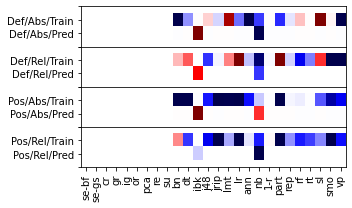

In [52]:
boundAbs = 300
boundRel = 1
L = [
    ["Def/Abs/Train", "Def/Abs/Pred"],
    ["Def/Rel/Train", "Def/Rel/Pred"],
    ["Pos/Abs/Train", "Pos/Abs/Pred"],
    ["Pos/Rel/Train", "Pos/Rel/Pred"]]
L = [["", l[0], l[1], ""] for l in L]


comparableAlgorithms = [a for a in preprocessors + classifiers if not a in ["decisionstump", "kstar", "naivebayesmultinomial", "zeror"]]

fig, ax = plt.subplots(4, 1, figsize=(5, 3), sharex = True)
localmetrics = ["rmse", "mape"]

for aIndex, modeltype in enumerate(["default", "posterior"]):
    
    # absolute avg advantages
    for mIndex, metric in enumerate(localmetrics):
        M = None
        for algo in comparableAlgorithms:
            dfAlgo = dfComparison.query("algorithm == '" + algo + "'")
            absAdvInduction = dfAlgo["imp_" + modeltype + "_" + metric + "_fit"].values if "imp_" + modeltype + "_" + metric + "_fit" in dfAlgo.columns else []
            absAdvInference = dfAlgo["imp_" + modeltype + "_" + metric + "_app"].values if "imp_" + modeltype + "_" + metric + "_app" in dfAlgo.columns else[]
            
            absAdvInduction = absAdvInduction[0] if len(absAdvInduction) > 0 else np.nan
            absAdvInference = absAdvInference[0] if len(absAdvInference) > 0 else np.nan
            
            MCol = np.array([absAdvInduction, absAdvInference])
            M = MCol if M is None else np.column_stack([M, MCol])
        
        a = ax[aIndex * len(localmetrics) + mIndex]
        a.imshow(-1 * M, cmap="seismic", vmin = -1 * (boundAbs if mIndex == 0 else boundRel), vmax = (boundAbs if mIndex == 0 else boundRel), aspect="auto")
        a.set_yticks(np.arange(4) -1)
        a.set_yticklabels(L[2 * aIndex + mIndex])

ax[3].set_xticks(np.arange(len(comparableAlgorithms)))
ax[3].set_xticklabels([algorithmshortcuts[a] for a in comparableAlgorithms], rotation=90)
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig("plots/modeladvantages.pdf")
plt.show()